# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS2024

Original von S. Suter, angepasst von S. Marcin und M. Stutz

Abgabe von: <font color='blue'>Dominik Filliger</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe Ordner "resources"
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [1]:

import os
import glob
import imageio
import logging
import numpy as np
import cupy as cp
import time
from numba import cuda, vectorize, float32
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

def load_mri_images(subfolder='001'):
    """Load MRI images from the specified subfolder"""
    try:
        folders = os.path.join('adni_png', subfolder)
        if not os.path.exists(folders):
            raise FileNotFoundError(f"MRI image folder not found: {folders}")
        
        files = sorted(glob.glob(f"{folders}/*.png"))
        if not files:
            raise FileNotFoundError(f"No MRI images found in {folders}")
        
        images = np.array([imageio.imread(f) for f in files], dtype=np.float32)
        names = [f[-17:-4] for f in files]
        logger.info(f"Successfully loaded {len(images)} MRI images from {subfolder}")
        return images, names
    except Exception as e:
        logger.error(f"Error loading MRI images: {str(e)}")
        raise

In [2]:
# Dummy Beispiel zum testen mit Numba

import math
from numba import vectorize
import numpy as np

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)
  

a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

/home/paperspace/hs24-mc2-dmnkf/.venv/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest.

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [3]:
### BEGIN SOLUTION
import math
import numpy as np
import cupy as cp
from numba import cuda
import time
import matplotlib.pyplot as plt
import timeit

def reconstruct_svd_broadcast1(u,s,vt,k):
    ### BEGIN SOLUTION
    reco = u[:,:k] * s[:k] @ vt[:k,:]
    ### END SOLUTION
    return reco

def reconstruct_svd_cp(u, s, vt, k):
    """
    Perform SVD reconstruction using CuPy's built-in dot product.
    """
    return cp.asnumpy(cp.dot(u[:,:k], cp.dot(cp.diag(s[:k]), vt[:k,:])))

def reconstruct_svd_cp_einsum(u, s, vt, k):
    """
    Perform SVD reconstruction using CuPy and einsum for matrix multiplication.
    """
    return cp.asnumpy(cp.einsum('ik,k,kj->ij', u[:,:k], s[:k], vt[:k,:]))

def reconstruct_svd_cp_broadcast(u, s, vt, k):
    """
    CuPy SVD reconstruction using broadcasting for the multiplication of S.
    """
    return cp.asnumpy(cp.dot(u[:,:k], cp.multiply(s[:k].reshape(-1, 1), vt[:k,:])))

@cuda.jit
def reconstruct_svd_kernel(u, s, vt, out, k):
    """
    CUDA kernel that reconstructs a matrix from SVD components:
      out = u * s * vt, up to rank k.
    """
    i, j = cuda.grid(2)
    if i < u.shape[0] and j < vt.shape[1]:
        tmp = 0.0
        for r in range(k):
            tmp += u[i, r] * s[r] * vt[r, j]
        out[i, j] = tmp

def reconstruct_svd_numba_device(u_d, s_d, vt_d, out_d, k):
    """
    Run the custom CUDA kernel with pre-loaded device arrays.
    out_d is also a device array. No CPU↔GPU copies are done here.
    """
    threads_per_block = (16, 16)
    blocks_per_grid = (
        math.ceil(u_d.shape[0] / threads_per_block[0]),
        math.ceil(vt_d.shape[1] / threads_per_block[1])
    )
    reconstruct_svd_kernel[blocks_per_grid, threads_per_block](u_d, s_d, vt_d, out_d, k)
    cuda.synchronize()

def reconstruct_svd_numba(u, s, vt, k):
    """
    Multiply U, S, and V^T on the GPU using a custom CUDA kernel.
    """

    # Create contiguous arrays
    U_k = np.ascontiguousarray(u[:,:k], dtype=np.float32)
    S_k = np.ascontiguousarray(s[:k], dtype=np.float32)
    VT_k = np.ascontiguousarray(vt[:k,:], dtype=np.float32)

    # Prepare output on GPU
    out = np.zeros((U_k.shape[0], VT_k.shape[1]), dtype=np.float32)
    
    u_device = cuda.to_device(U_k)
    s_device = cuda.to_device(S_k) 
    vt_device = cuda.to_device(VT_k)
    out_device = cuda.to_device(out)

    # Launch kernel
    threads_per_block = (16, 16)
    blocks_per_grid = (
        math.ceil(U_k.shape[0] / threads_per_block[0]),
        math.ceil(VT_k.shape[1] / threads_per_block[1])
    )

    reconstruct_svd_kernel[blocks_per_grid, threads_per_block](u_device, s_device, vt_device, out_device, S_k.shape[0])
    cuda.synchronize()
    return out_device.copy_to_host()

### END SOLUTION

In [4]:
def measure_reconstruction_time(
    func, 
    u_input, 
    s_input, 
    vt_input, 
    k, 
    gpu_library=None, 
    warmup=10, 
    niter=100
):
    """
    Measure average reconstruction time for either CPU or GPU-based function.
    - If gpu_library='cupy', use CuPy events
    - If gpu_library='numba', use Numba (cuda) events
    - Else measure CPU time with time.perf_counter
    """
    # Warmup (not timed)
    for _ in range(warmup):
        _ = func(u_input, s_input, vt_input, k)

    if gpu_library == 'cupy':
        # Use CuPy's event timing
        start = cp.cuda.Event()
        stop  = cp.cuda.Event()
        start.record()
        for _ in range(niter):
            _ = func(u_input, s_input, vt_input, k)
        stop.record()
        stop.synchronize()
        elapsed_ms = cp.cuda.get_elapsed_time(start, stop)
        elapsed = elapsed_ms / 1000.0
    elif gpu_library == 'numba':
        # Use Numba's event timing
        start_event = cuda.event()
        stop_event  = cuda.event()
        start_event.record()
        for _ in range(niter):
            _ = func(u_input, s_input, vt_input, k)
        cuda.synchronize()
        stop_event.record()
        gpu_time = cuda.event_elapsed_time(start_event, stop_event)
        elapsed = gpu_time / 1000.0
    else:
        # CPU
        start = time.perf_counter()
        for _ in range(niter):
            _ = func(u_input, s_input, vt_input, k)
        elapsed = time.perf_counter() - start
    
    return elapsed / niter  # average time per iteration

# --------------------------------------------------------------------------------------
# MSE / PSNR
# --------------------------------------------------------------------------------------

def measure_metrics(original, reconstructed):
    """
    Compute MSE and PSNR for the given original and reconstructed arrays.
    """
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = round(20 * np.log10(255.0 / np.sqrt(mse)), 5)
    return mse, psnr

# --------------------------------------------------------------------------------------
# Main Comparison
# --------------------------------------------------------------------------------------

def plot_reconstruction_comparison(test_image, k_values=(10, 25, 50, 100, 150)):
    """
    For each method, reconstruct the test_image with various k-values,
    measuring decomposition and reconstruction times separately.
    """
    # Implementation dict: name -> (function, is_gpu, library)
    implementations = {
        'CPU Broadcast':        (reconstruct_svd_broadcast1, False, None),
        'CuPy Basic':           (reconstruct_svd_cp,         True,  'cupy'),
        'CuPy Einsum':          (reconstruct_svd_cp_einsum,  True,  'cupy'),
        'CuPy Broadcast':       (reconstruct_svd_cp_broadcast, True,'cupy'),
        'Numba CUDA':           (reconstruct_svd_numba,       True,  'numba'),
    }

    results = {name: [] for name in implementations}

    # SVD decomposition once on CPU
    U, S, VT = np.linalg.svd(test_image, full_matrices=False)
    
    # Prepare GPU versions for CuPy
    U_gpu  = cp.asarray(U,  dtype=cp.float32)
    S_gpu  = cp.asarray(S,  dtype=cp.float32)
    VT_gpu = cp.asarray(VT, dtype=cp.float32)


    for k in k_values:
        # We'll track the first MSE for a given k so we can ensure equality across methods
        first_mse = None
        
        for name, (func, is_gpu, gpu_lib) in implementations.items():
            # Decide which inputs to pass
            if is_gpu and gpu_lib == 'cupy':
                u_input, s_input, vt_input = U_gpu, S_gpu, VT_gpu
            else:
                # CPU or Numba
                # Numba needs CPU arrays (float32)
                if gpu_lib == 'numba':
                    # We'll pass the float32 arrays: the function will do the device transfers
                    u_input, s_input, vt_input = (
                        U.astype(np.float32), 
                        S.astype(np.float32), 
                        VT.astype(np.float32)
                    )
                else:
                    # pure CPU
                    u_input, s_input, vt_input = U, S, VT

            # Measure average time (warmup + timing)
            recon_time = measure_reconstruction_time(
                func, u_input, s_input, vt_input, k,
                gpu_library=gpu_lib,
                warmup=10,
                niter=100
            )
            
            # Perform single reconstruction to get MSE, PSNR
            reconstructed = func(u_input, s_input, vt_input, k)
            mse, psnr = measure_metrics(test_image, reconstructed)
            
            # Check MSE consistency
            if first_mse is None:
                first_mse = mse
            else:
                # Confirm close
                assert np.allclose(mse, first_mse, rtol=1e-5), f"MSE mismatch for {name}"

            results[name].append({
                'k':           k,
                'recon_time':  recon_time,
                'mse':         mse,
                'psnr':        psnr,
                'reconstructed': reconstructed
            })

    # Plot reconstruction time, MSE, PSNR
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for name, data in results.items():
        ks          = [d['k']           for d in data]
        recon_times = [d['recon_time']  for d in data]
        mse_list    = [d['mse']         for d in data]
        psnr_list   = [d['psnr']        for d in data]

        axes[0].plot(ks, recon_times, '-o', label=name)
        axes[1].plot(ks, mse_list,     '-o', label=name)
        axes[2].plot(ks, psnr_list,    '-o', label=name)

    axes[0].set_title('Reconstruction Time')
    axes[0].set_xlabel('k')
    axes[0].set_ylabel('Time (s)')
    axes[0].set_yscale('log')

    axes[1].set_title('MSE')
    axes[1].set_xlabel('k')
    axes[1].set_ylabel('Mean Squared Error')
    axes[1].set_yscale('log')

    axes[2].set_title('PSNR')
    axes[2].set_xlabel('k')
    axes[2].set_ylabel('dB')
    axes[2].set_yscale('log')

    for ax in axes:
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # ----------------------------
    # Visualization of k=50
    # ----------------------------
    if 50 in k_values:
        k_idx = k_values.index(50)

        n_methods = len(implementations)
        fig, axes = plt.subplots(3, n_methods, figsize=(4*n_methods, 12))
        # Original image
        axes[0,0].imshow(test_image, cmap='gray')
        axes[0,0].set_title('Original Image')
        axes[0,0].axis('off')

        # For each method
        idx = 0
        for name, data in results.items():
            # data is a list with one entry per k
            # find the one that has k=50
            subset = [x for x in data if x['k'] == 50]
            if not subset:
                continue
            method_result = subset[0]
            reconstructed = method_result['reconstructed']
            diff_map      = np.abs(test_image - reconstructed)

            if idx == 0:
                # Already displayed the original
                pass
            else:
                axes[0,idx].imshow(reconstructed, cmap='gray')
                axes[0,idx].set_title(f'{name}\nk=50')
                axes[0,idx].axis('off')

            # Difference map
            im = axes[1,idx].imshow(diff_map, cmap='hot')
            axes[1,idx].set_title(f'Diff Map\nMSE={method_result["mse"]:.2e}')
            axes[1,idx].axis('off')
            plt.colorbar(im, ax=axes[1,idx])

            # Middle row intensity plot
            middle_row = test_image.shape[0] // 2
            axes[2,idx].plot(test_image[middle_row, :], label='Original')
            axes[2,idx].plot(reconstructed[middle_row, :], '--', label='Reconstructed')
            axes[2,idx].set_title('Middle Row Intensity')
            axes[2,idx].legend()
            axes[2,idx].grid(True)
            idx += 1
        
        plt.tight_layout()
        plt.show()

/tmp/ipykernel_139397/1577994085.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = np.array([imageio.imread(f) for f in files], dtype=np.float32)


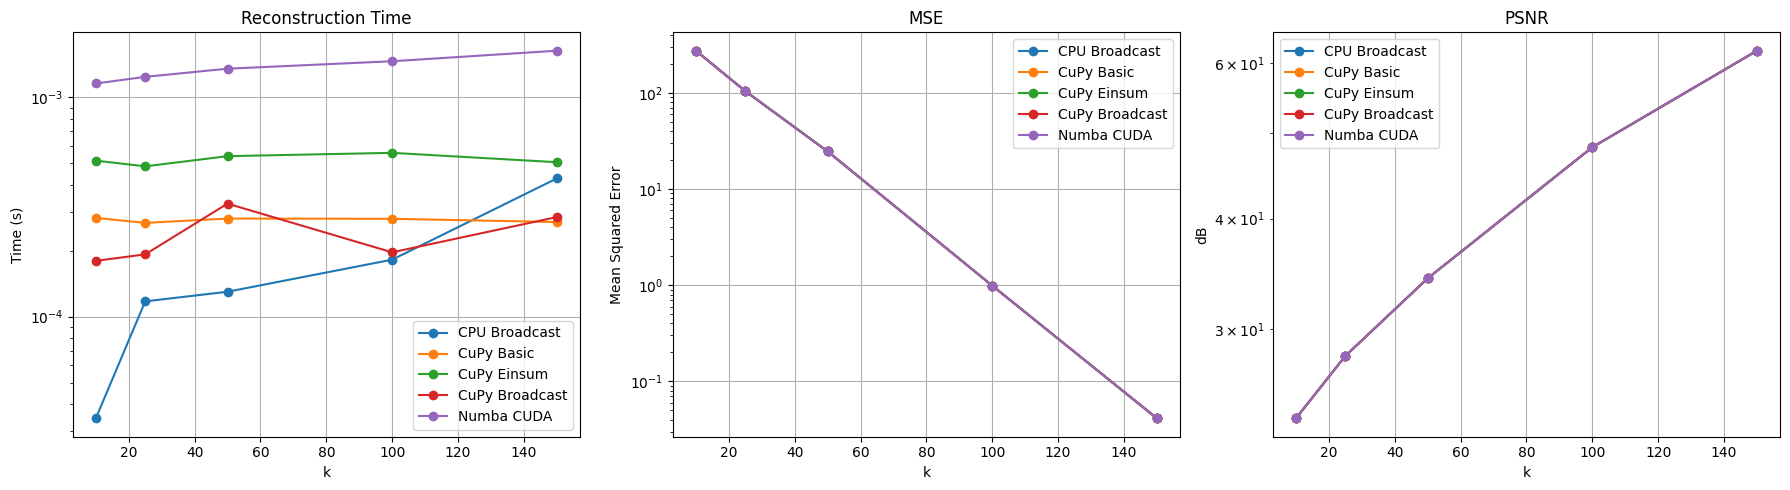

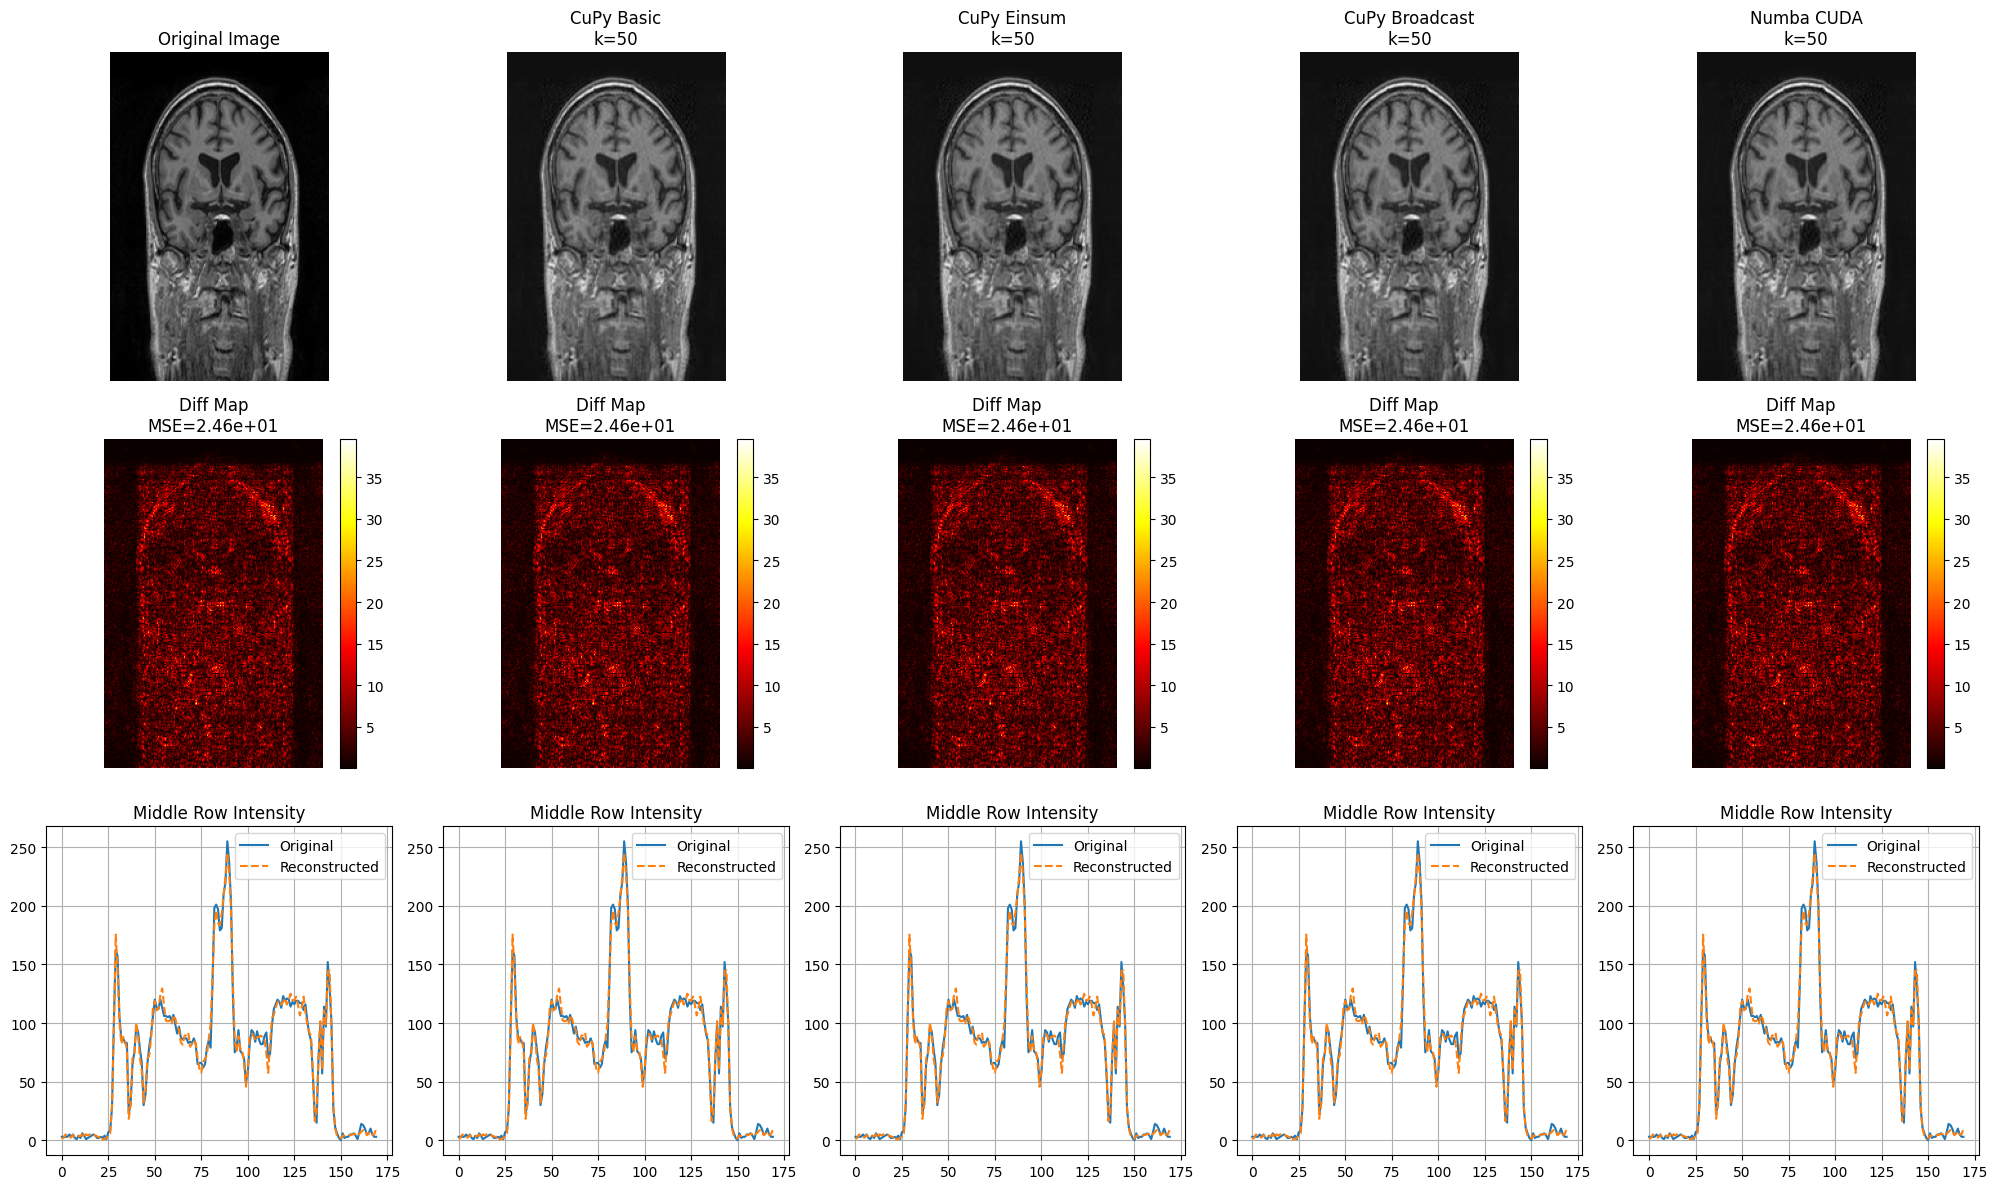

In [5]:

images, names = load_mri_images(subfolder='001')
test_image = np.ascontiguousarray(images[0])

plot_reconstruction_comparison(test_image)

<font color='blue'>

I compared CPU broadcast (from part 1) with some reimplementations in CuPy (drop in replacement for NumPy) as well as a naive reconstruction using Numba CUDA.

The plots showcase that the reconstruction yields the same results for all implementations, which is expected.

For the Numba Kernel I decided to let the cpu index the relevant submatrices (u, s, vt based on k) and then transfer them to the GPU via cuda.to_device. Nonetheless the kernel is the slowest out of the bunch, which makes sense given the size of the matrix as well as the additional overhead of transferring the data to the GPU (for the kernel). 

The general conclusion is that for these images the cpu seems to be fast enough for a certain k range. Only at around k=150 we notice the CuPy implementation undercutting the CPU. 

I like a good underdog story, for this reason I will be going with Numba and try to get the most out of it and hopefully crush CPU reconstructions.
</font>

#### 5.2 GPU-Kernel Performance

##### 5.2.1 Blocks und Input-Grösse

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Grösse der Input-Daten durch. Erstelle dafür ein neues Datenset mit beliebig grossen Matrizen, da die GPU besonders geeignet ist um grosse Inputs zu verarbeiten (Verwende diese untschiedlich grossen Matrizen für alle nachfolgenden Vergeliche und Tasks ebenfalls). Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse in Abhängigkeit mit der Input-Grösse hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse (ggf. mit Grafiken).

In [6]:
matrix_sizes = [512, 1024, 2048]


# Block configurations to test - powers of 2, respecting max 1024 threads
block_configs = [
    (x, y) for x, y in [
        (2**i, 2**j) 
        for i in range(1,6) 
        for j in range(1,9)
    ] if x * y <= 1024 and x <= y
]


# Precompute SVD decompositions for each matrix size
svd_components = {}
for N in matrix_sizes:
    A = np.random.randn(N, N).astype(np.float32)
    u, s, vt = np.linalg.svd(A, full_matrices=False)
    k = min(u.shape[1], vt.shape[0]) // 3
    svd_components[N] = {
        'u': u,
        's': s,
        'vt': vt,
        'k': k
    }

    cpu_time = timeit.timeit(lambda: reconstruct_svd_broadcast1(u, s, vt, k), number=100) / 100
    
    svd_components[N]['cpu_time'] = cpu_time


In [7]:
results_basic = []

for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']
    
    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        threadsperblock = block_size
        blockspergrid_x = math.ceil(N / threadsperblock[0])
        blockspergrid_y = math.ceil(N / threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        
        # Warm-up run
        reconstruct_svd_kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()
        
        start_event = cuda.event()
        stop_event = cuda.event()
        # Timed run
        start_event.record()
        reconstruct_svd_kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()
        stop_event.record()
        gpu_time = cuda.event_elapsed_time(start_event, stop_event) / 1000
        
        C_gpu = C_device.copy_to_host()
        
        C_cpu = np.dot(np.dot(u[:N, :k], np.diag(s[:k])), vt[:k, :N])

        assert np.allclose(C_gpu, C_cpu, atol=1e-1), "Result mismatch"
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_basic.append({
            'kernel': 'basic',
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")
        
    # Clean up device memory
    del u_device, s_device, vt_device, C_device

Block size (2, 2): GPU time = 0.0117s, Speedup = 0.05x
Block size (2, 4): GPU time = 0.0060s, Speedup = 0.09x
Block size (2, 8): GPU time = 0.0031s, Speedup = 0.17x
Block size (2, 16): GPU time = 0.0016s, Speedup = 0.34x
Block size (2, 32): GPU time = 0.0017s, Speedup = 0.31x
Block size (2, 64): GPU time = 0.0016s, Speedup = 0.33x
Block size (2, 128): GPU time = 0.0017s, Speedup = 0.32x
Block size (2, 256): GPU time = 0.0017s, Speedup = 0.31x
Block size (4, 4): GPU time = 0.0031s, Speedup = 0.17x
Block size (4, 8): GPU time = 0.0015s, Speedup = 0.35x
Block size (4, 16): GPU time = 0.0016s, Speedup = 0.34x
Block size (4, 32): GPU time = 0.0015s, Speedup = 0.35x
Block size (4, 64): GPU time = 0.0016s, Speedup = 0.34x
Block size (4, 128): GPU time = 0.0017s, Speedup = 0.32x
Block size (4, 256): GPU time = 0.0019s, Speedup = 0.28x
Block size (8, 8): GPU time = 0.0016s, Speedup = 0.34x
Block size (8, 16): GPU time = 0.0016s, Speedup = 0.34x
Block size (8, 32): GPU time = 0.0016s, Speedup = 

In [8]:
def plot_results(results, kernel_name):
    """
    Plot heatmaps and bar plots for each matrix size showing GPU times and CPU comparison.
    """
    # Extract unique sizes and configurations
    block_sizes = sorted(list(set([tuple(r['block_size']) for r in results])))
    matrix_sizes = sorted(list(set(r['matrix_size'] for r in results)))
    
    # Prepare data structures
    gpu_times = {}
    cpu_times = {}
    
    # Organize data
    for r in results:
        bs = tuple(r['block_size'])
        N = r['matrix_size']
        gpu_times.setdefault(bs, {})[N] = r['gpu_time']
        if N not in cpu_times:
            cpu_times[N] = r['cpu_time']
    
    # Create subplots for each matrix size
    for N in matrix_sizes:
        plt.figure(figsize=(18, 5))
        
        # --- Left subplot: Heatmap
        plt.subplot(1, 2, 1)
        
        # Extract block dimensions for heatmap axes
        block_x = sorted(list(set([bs[0] for bs in block_sizes])))
        block_y = sorted(list(set([bs[1] for bs in block_sizes])))
        
        # Create heatmap data - fill lower triangle
        heatmap_data = np.zeros((len(block_x), len(block_y)))
        for i, bx in enumerate(block_x):
            for j, by in enumerate(block_y):
                if (bx, by) in gpu_times and N in gpu_times[(bx, by)]:
                    heatmap_data[i,j] = gpu_times[(bx, by)][N]
                else:
                    heatmap_data[i,j] = np.nan
        
        # Find minimum time (excluding NaN values)
        min_time = np.nanmin(heatmap_data)
        
        plt.imshow(heatmap_data, cmap='magma_r', aspect='auto')  # Reversed colormap so lowest time is highlighted
        plt.colorbar(label='Time (s)')
        plt.title(f'{kernel_name} GPU Times Heatmap - Matrix Size {N}x{N}\nBest time: {min_time:.4f}s')
        plt.xlabel('Block Y Size')
        plt.ylabel('Block X Size')
        plt.xticks(range(len(block_y)), block_y)
        plt.yticks(range(len(block_x)), block_x)
        
        # Highlight the minimum value
        min_idx = np.where(heatmap_data == min_time)
        plt.plot(min_idx[1], min_idx[0], 'r*', markersize=15, label=f'Best: {min_time:.4f}s')
        plt.legend()
        
        # --- Right subplot: Bar plot
        plt.subplot(1, 2, 2)
        
        # Prepare data for bar plot
        gpu_times_N = []
        gpu_labels = []
        
        for bs in block_sizes:
            if N in gpu_times[bs]:
                gpu_times_N.append(gpu_times[bs][N])
                gpu_labels.append(f'Block {bs}')
        
        # Sort by execution time
        sorted_indices = np.argsort(gpu_times_N)
        sorted_times = [gpu_times_N[i] for i in sorted_indices]
        sorted_labels = [gpu_labels[i] for i in sorted_indices]
        
        # Create bar plot
        bars = plt.bar(range(len(sorted_times)), sorted_times)
        plt.xticks(range(len(sorted_times)), sorted_labels, rotation=45, ha='right')
        
        # Add CPU time reference line
        plt.axhline(y=cpu_times[N], color='r', linestyle='--', label=f'CPU Time')
        
        plt.yscale('log')
        plt.ylabel('Time (s)')
        plt.title(f'Execution Times - Matrix Size {N}x{N}')
        plt.grid(True, which='both', ls='-', alpha=0.2)
        plt.legend()
        
        plt.tight_layout()
        plt.show()



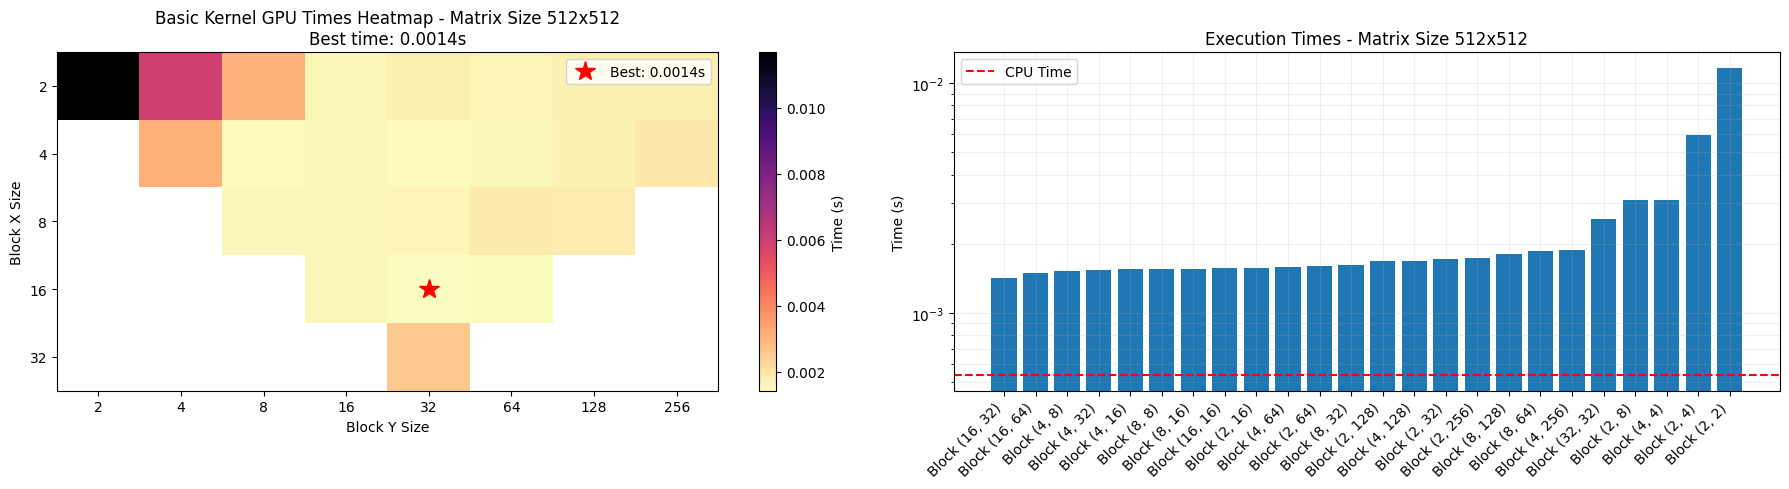

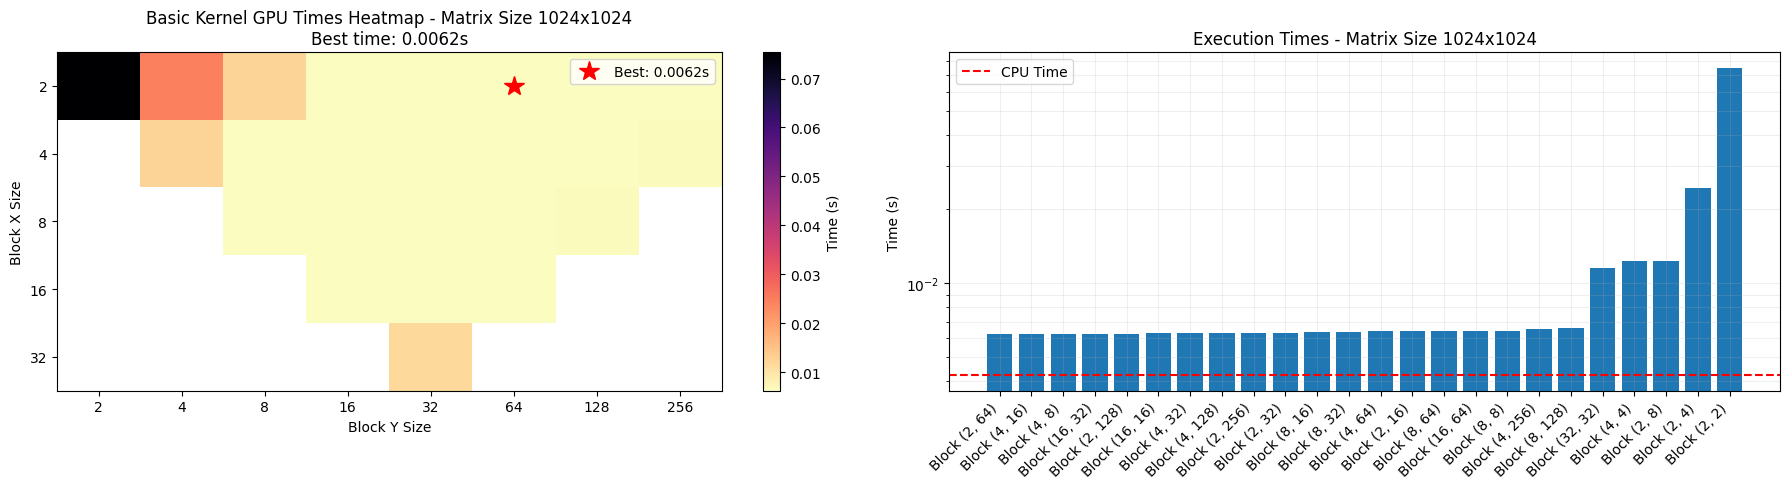

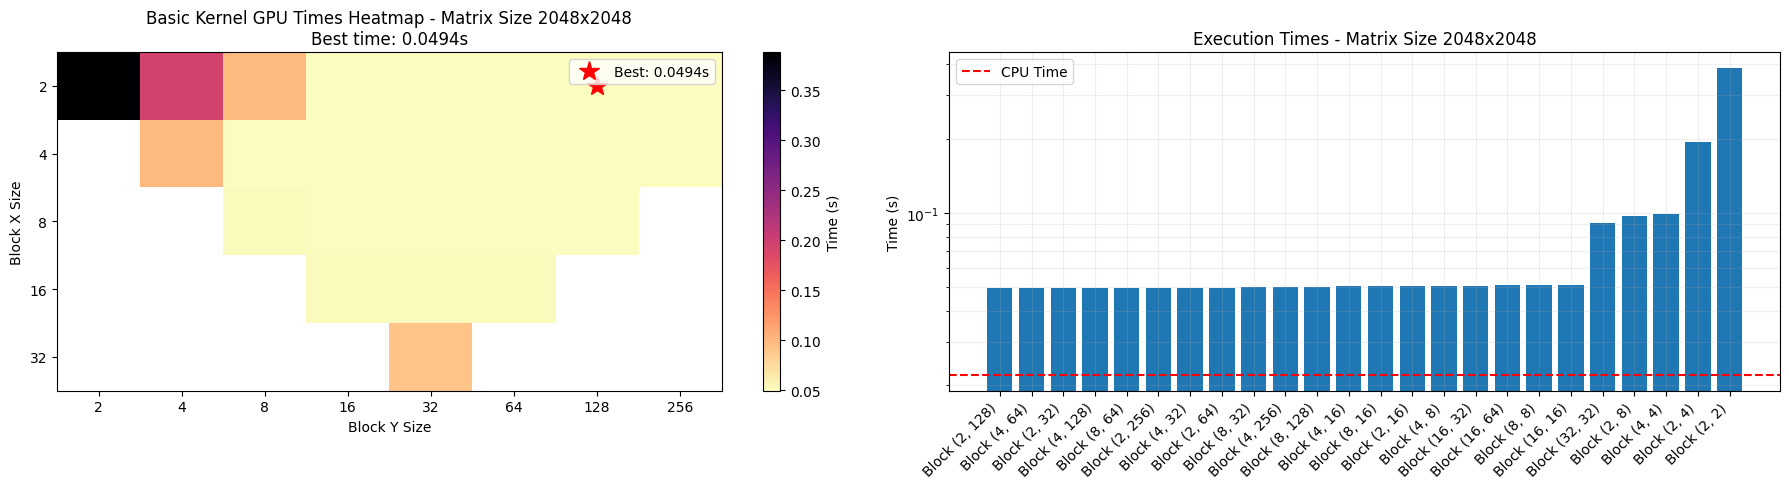


=== Best Configuration for Basic Kernel (Matrix Size 512x512) ===
Block Size: (16, 32)
GPU Time: 0.0014 seconds
Speedup over CPU: 0.38x

=== Best Configuration for Basic Kernel (Matrix Size 1024x1024) ===
Block Size: (2, 64)
GPU Time: 0.0062 seconds
Speedup over CPU: 0.68x

=== Best Configuration for Basic Kernel (Matrix Size 2048x2048) ===
Block Size: (2, 128)
GPU Time: 0.0494 seconds
Speedup over CPU: 0.44x


In [9]:
plot_results(results_basic, 'Basic Kernel')

for N in matrix_sizes:
    # Filter results for this matrix size
    results_N = [r for r in results_basic if r['matrix_size'] == N]
    best_basic = min(results_N, key=lambda x: x['gpu_time'])
    
    print(f"\n=== Best Configuration for Basic Kernel (Matrix Size {N}x{N}) ===")
    print(f"Block Size: {best_basic['block_size']}")
    print(f"GPU Time: {best_basic['gpu_time']:.4f} seconds") 
    print(f"Speedup over CPU: {best_basic['speedup']:.2f}x")

<font color='blue'>
The above code uses the naive kernel with varying block dimensions to figure out if there is some room of improvement based on the size of the blocks. 

The results show that the naive kernel on all setups underperforms. 

Since the block size effectively dictates how many threads can be allocated at once it makes sense to see how small block sizes are performing a lot worse since the GPU is heavily underutilized. 

interesting to see is how there is no real gain after a certain threshold of threads (block size) 

This however points at a poor approach which given the simplicity of the naive kernel makes sense.

</font>

##### 5.2.2 Shared Memory auf der GPU
Optimiere deine Implementierung von oben indem du das shared Memory der GPU verwendest. Führe wieder mehrere Experimente mit unterschiedlicher Datengrösse durch und evaluiere den Speedup gegenüber der CPU Implementierung.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [10]:
### BEGIN SOLUTION
def get_kernel(threads_per_block):
    # for us tileDim is equivalent to blockSize, so 1 tile is 1 block
    tileDimX, tileDimY = threads_per_block

    @cuda.jit(fastmath=True)
    def reconstruct_svd_numba_shared(u, s, vt, out, k):
        # Early exit if k <= 0
        if k <= 0:
            return

        # global coordinates of the thread in the output matrix
        global_x, global_y = cuda.grid(2)

        # Check boundaries
        if global_y >= out.shape[1] or global_x >= out.shape[0]:
            return

        u_tile  = cuda.shared.array(shape=(tileDimX, tileDimY), dtype=float32)
        vt_tile = cuda.shared.array(shape=(tileDimX, tileDimY), dtype=float32)
        s_tile  = cuda.shared.array(shape=(tileDimX,),           dtype=float32)

        threadRow = cuda.threadIdx.x
        threadColumn = cuda.threadIdx.y

        acc = float32(0.0)

        # how many blocks can we fit into the k dimension, where k is the number of singular values
        blocks_per_grid = cuda.gridDim.x 
        for block_i in range(blocks_per_grid):
            
            # so we move horizontally across the columns of u one chunk at a time
            # basically, we start at block 0, can only move in tileDimX steps (so one tile at a time) and add the current threadColumn
            col_u = block_i * tileDimX + threadColumn
            # so essentially we take the threadRow which is threadIdx.x and the threadColumn which is threadIdx.y for the shared memory tile. 
            # we then take the GLOBAL row of the output matrix from that thread and the current tile position + threadColumn to access the correct element in the u global memory matrix
            if col_u < k:
                u_tile[threadRow, threadColumn] = u[global_x, col_u]

            # same concept we move tileDimX steps across the rows of vt
            row_vt = block_i * tileDimX + threadRow
            # okay here is the not so intuitive part. 
            # for the matrix Vt we again store the tile in the shared memory. using the same coordinates for the shared memory tile as with the u_tile matrix so vt_tile[threadRow, threadColumn].
            #
            # however, we access the global memory by looking at the current tile position * tileDimX + threadRow and the global column of the output matrix.
            # this will now create u_tile and vt_tile which share the index for the the correct value from global memory at the same coordinate within the shared matrix dimensions
            # this way u * vt would now result in a partial dot product across the tile. 
            if row_vt < k:
                vt_tile[threadRow, threadColumn] = vt[row_vt, global_y] 
                s_tile[threadRow] = s[row_vt]

            # now since the threads run async we call a syncthreads so that we know that all threads have loaded the shared memory and we essentially have a full tile in the shared memory.
            cuda.syncthreads()

            # we again g
            valid_chunk = min(tileDimX, k - block_i*tileDimX)
            for n in range(valid_chunk):
                acc += u_tile[threadRow, n] * s_tile[n] * vt_tile[n, threadColumn]

            cuda.syncthreads()

        # now we write the result to the global memory at the correct position.
        out[global_x, global_y] = acc

    return reconstruct_svd_numba_shared
### END SOLUTION

In [11]:
def benchmark_kernel(get_kernel, matrix_sizes, block_configs, svd_components):
    results = []

    for N in matrix_sizes:
        # Get precomputed components
        u = svd_components[N]['u']
        s = svd_components[N]['s'] 
        vt = svd_components[N]['vt']
        k = svd_components[N]['k']

        # Allocate device memory
        u_device = cuda.to_device(u)
        s_device = cuda.to_device(s)
        vt_device = cuda.to_device(vt)
        C_device = cuda.device_array((N, N), dtype=np.float32)

        for block_size in block_configs:
            threadsperblock = block_size
            blockspergrid_x = math.ceil(N / threadsperblock[0])
            blockspergrid_y = math.ceil(N / threadsperblock[1])
            blockspergrid = (blockspergrid_x, blockspergrid_y)
            print(f"blockspergrid: {blockspergrid}, threadsperblock: {threadsperblock}")
            
            kernel = get_kernel(threadsperblock)
            
            # Warm-up run
            kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
            cuda.synchronize()
            
            start_event = cuda.event()
            stop_event = cuda.event()
            # Timed run
            start_event.record()
            kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
            cuda.synchronize()
            stop_event.record()

            gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
            gpu_time = gpu_time_ms / 1000

            # Copy result back to host
            C_gpu = C_device.copy_to_host()
            
            # check if the result is correct
            C_cpu = np.dot(np.dot(u[:N, :k], np.diag(s[:k])), vt[:k, :N])
            assert np.allclose(C_gpu, C_cpu, atol=1e-5), "Result mismatch"
            
            speedup = svd_components[N]['cpu_time'] / gpu_time
            
            results.append({
                'matrix_size': N,
                'block_size': block_size,
                'cpu_time': svd_components[N]['cpu_time'],
                'gpu_time': gpu_time,
                'speedup': speedup,
            })
            
            print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")
            
        # Clean up device memory
        del u_device, s_device, vt_device, C_device
        
    return results

results_shared = benchmark_kernel(get_kernel, matrix_sizes, block_configs, svd_components)

blockspergrid: (256, 256), threadsperblock: (2, 2)
Block size (2, 2): GPU time = 0.0132s, Speedup = 0.04x
blockspergrid: (256, 128), threadsperblock: (2, 4)
Block size (2, 4): GPU time = 0.0068s, Speedup = 0.08x
blockspergrid: (256, 64), threadsperblock: (2, 8)
Block size (2, 8): GPU time = 0.0036s, Speedup = 0.15x
blockspergrid: (256, 32), threadsperblock: (2, 16)
Block size (2, 16): GPU time = 0.0019s, Speedup = 0.29x
blockspergrid: (256, 16), threadsperblock: (2, 32)
Block size (2, 32): GPU time = 0.0016s, Speedup = 0.33x
blockspergrid: (256, 8), threadsperblock: (2, 64)
Block size (2, 64): GPU time = 0.0016s, Speedup = 0.33x
blockspergrid: (256, 4), threadsperblock: (2, 128)
Block size (2, 128): GPU time = 0.0017s, Speedup = 0.32x
blockspergrid: (256, 2), threadsperblock: (2, 256)
Block size (2, 256): GPU time = 0.0019s, Speedup = 0.28x
blockspergrid: (128, 128), threadsperblock: (4, 4)
Block size (4, 4): GPU time = 0.0023s, Speedup = 0.24x
blockspergrid: (128, 64), threadsperblock

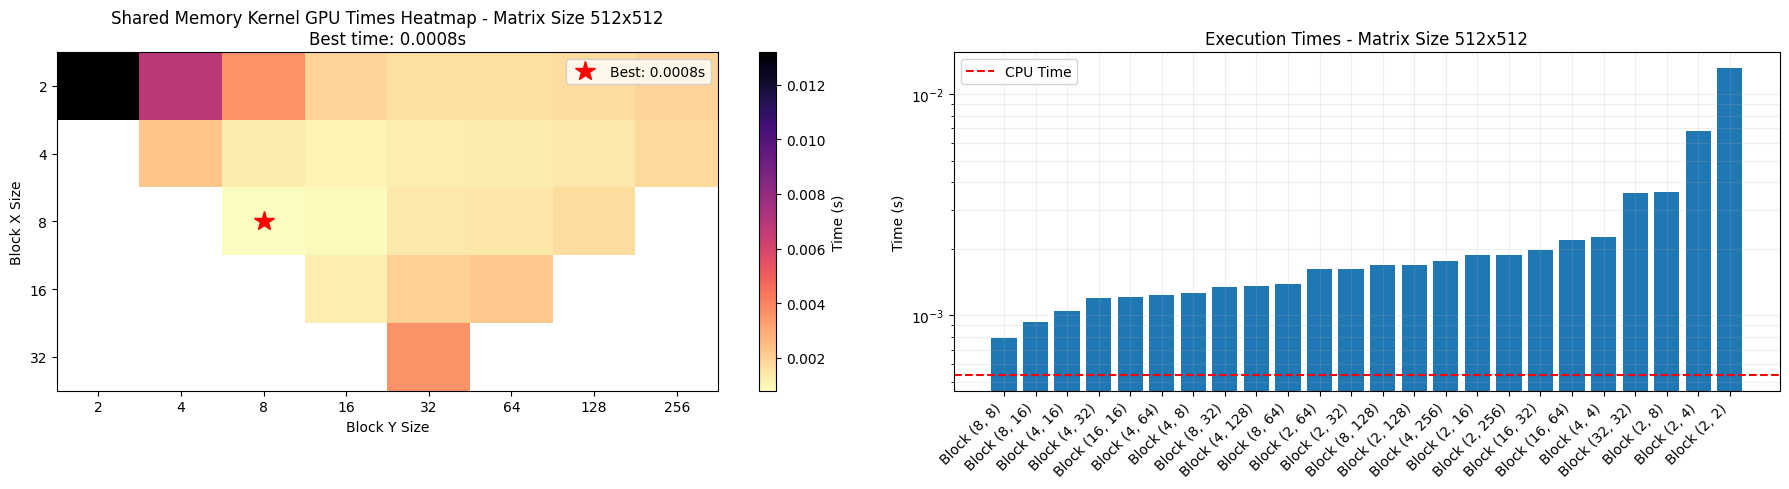

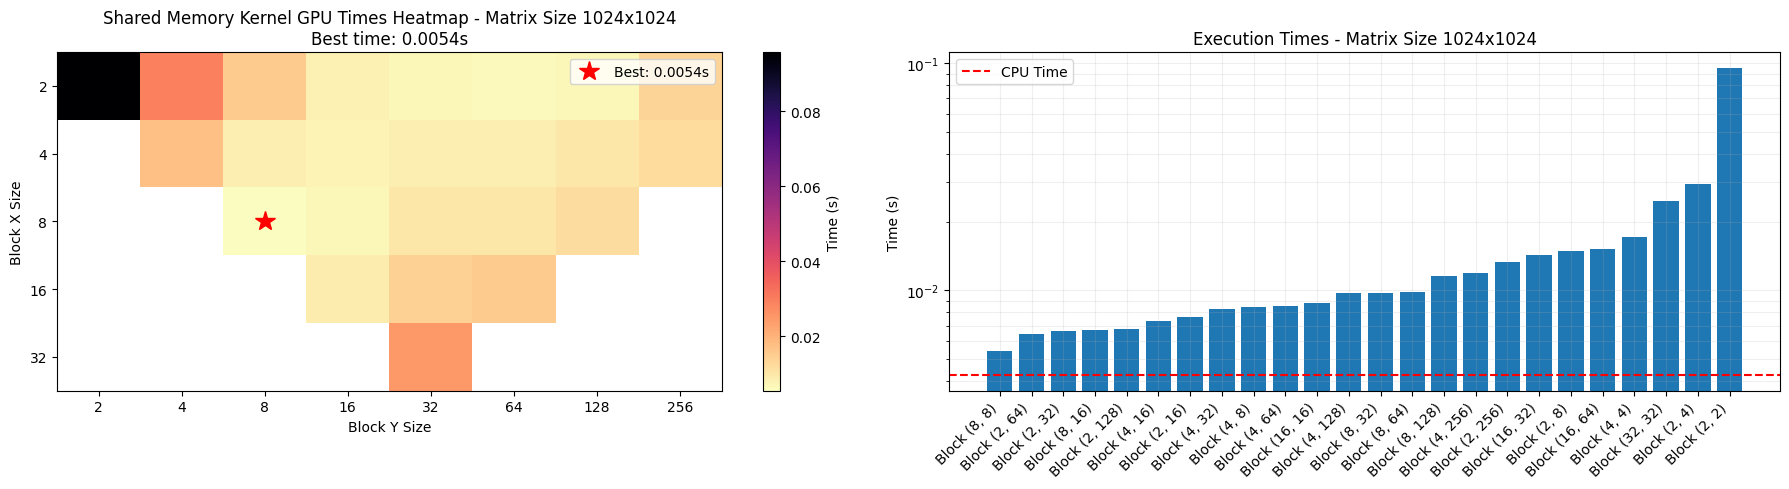

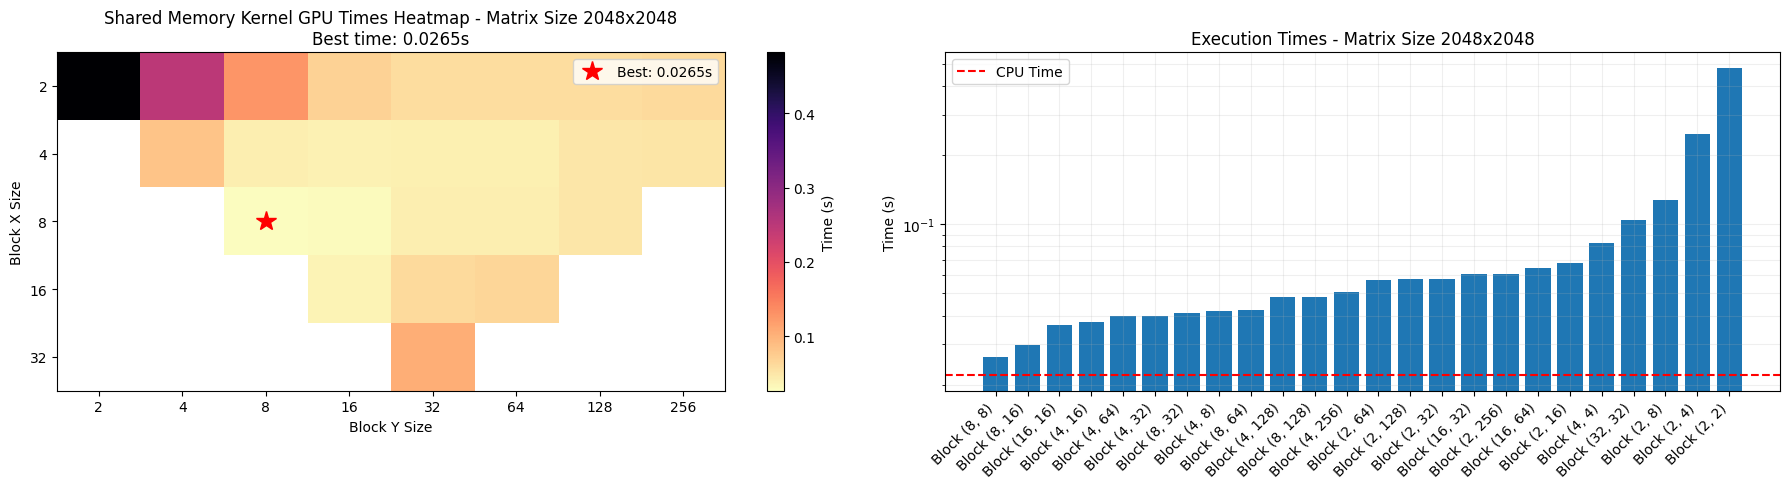

In [12]:
plot_results(results_shared, 'Shared Memory Kernel')

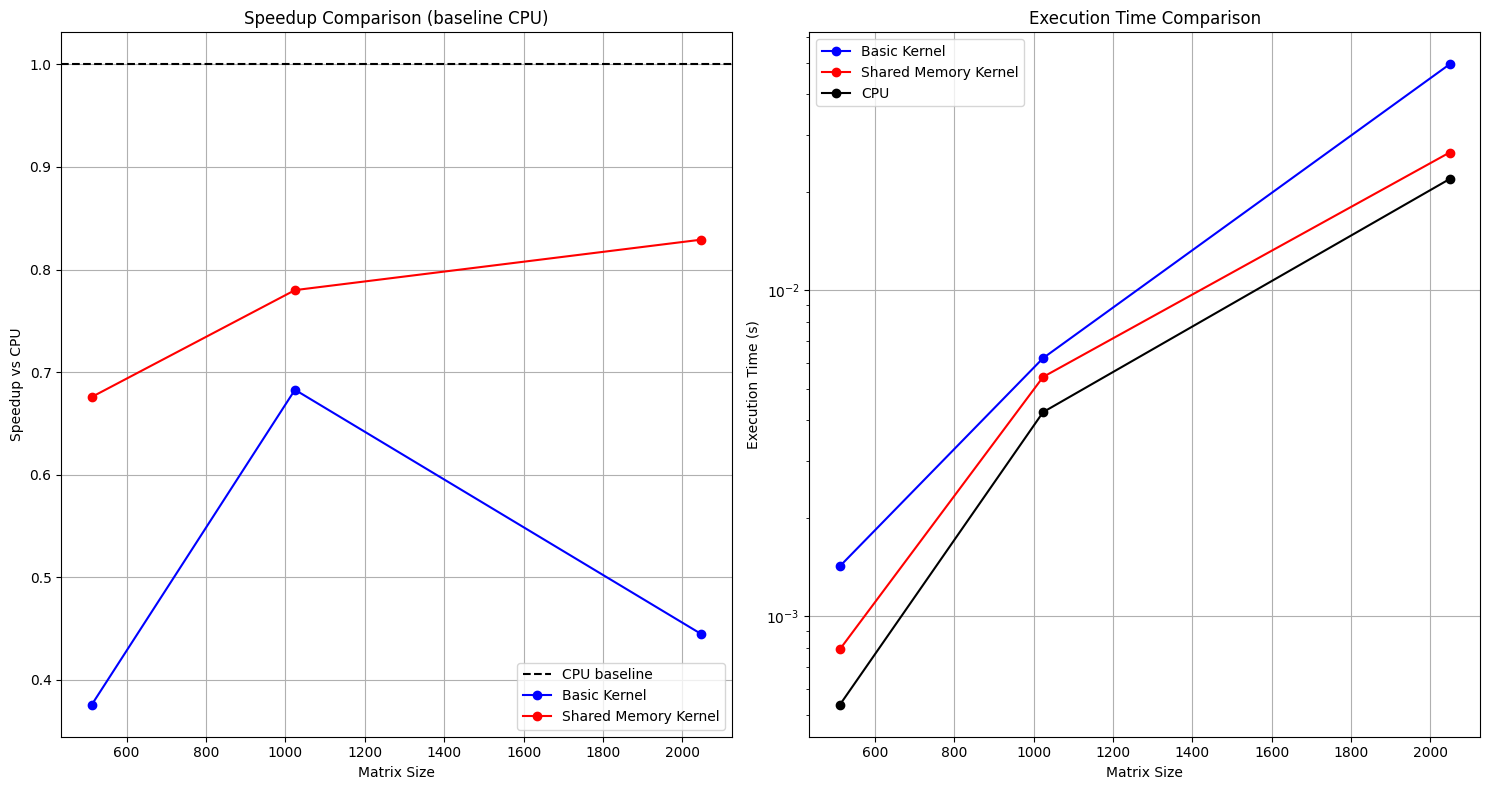


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0014    |    0.0008    | (8, 8)
    1024     |    0.0062    |    0.0054    | (8, 8)
    2048     |    0.0494    |    0.0265    | (8, 8)


In [13]:
def plot_kernel_comparison(best_times_list, labels, matrix_sizes):
    """
    Plot comparison of multiple kernel implementations
    
    Args:
        best_times_list: List of dictionaries containing best times for each implementation
        labels: List of labels for each implementation
        matrix_sizes: List of matrix sizes to plot
    """
    plt.figure(figsize=(15, 8))
    
    colors = ['b', 'r', 'g', 'c', 'm', 'y']  # Add more colors if needed
    
    # Plot speedups
    plt.subplot(1, 2, 1)
    # Add baseline CPU reference line at y=1
    plt.axhline(y=1, color='k', linestyle='--', label='CPU baseline')
    for best_times, label, color in zip(best_times_list, labels, colors):
        plt.plot(matrix_sizes, [best_times[N]['speedup'] for N in matrix_sizes], 
                f'{color}-o', label=label)
    plt.xlabel('Matrix Size')
    plt.ylabel('Speedup vs CPU')
    plt.title('Speedup Comparison (baseline CPU)')
    plt.grid(True)
    plt.legend()

    # Plot execution times
    plt.subplot(1, 2, 2)
    for best_times, label, color in zip(best_times_list, labels, colors):
        plt.plot(matrix_sizes, [best_times[N]['gpu_time'] for N in matrix_sizes], 
                f'{color}-o', label=label)
    # Add CPU time from any of the implementations (they should all have same CPU time)
    plt.plot(matrix_sizes, [best_times_list[0][N]['cpu_time'] for N in matrix_sizes], 
            'k-o', label='CPU')
    plt.xlabel('Matrix Size')
    plt.ylabel('Execution Time (s)')
    plt.title('Execution Time Comparison')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed comparison
    print("\nDetailed Performance Comparison:")
    print("-" * 100)
    header = f"{'Matrix Size':^12} |"
    for label in labels:
        header += f" {label+' Time':^12} |"
    header += f" {'Best Block Size':^20}"
    print(header)
    print("-" * 100)

    for N in matrix_sizes:
        row = f"{N:^12} |"
        for best_times in best_times_list:
            row += f" {best_times[N]['gpu_time']:^12.4f} |"
        # Use block size from last implementation
        row += f" {best_times[N]['block_size']}" if best_times[N]['block_size'] else " "
        print(row)

# Get best times for each matrix size
best_times_basic = {}
best_times_shared = {}

for N in matrix_sizes:
    basic_N = [r for r in results_basic if r['matrix_size'] == N]
    shared_N = [r for r in results_shared if r['matrix_size'] == N]
    best_times_basic[N] = min(basic_N, key=lambda x: x['gpu_time'])
    best_times_shared[N] = min(shared_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared], 
                      ['Basic Kernel', 'Shared Memory Kernel'],
                      matrix_sizes)

Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf die GPU? Interpretiere deine Resultate.

<font color='blue'>

The code above implements a shared memory kernel as per task requirements. The implementation is verbosely commented to understand each step of the process. 

But a tl;dr: 
The kernel tiles each block in shared memory, loads chunks of u and vt, multiplies them, and writes partial sums (acc) back to global memory. 


Interesting to see is how the block dimensions now do have a lot more of impact with (8, 8) being the clear fastest configuration. 

8, 8 seems to make sense as it gives 64 blocks per thread which is exactly 2 warps, which I guess for this implementation appears to be the sweet spot between.

Again I took a look a the performance gain on per block dimension configuration. While we see a clear speed improvment in comparison to the naive kernel it is still slower than the cpu, which highlights that there is more that can be done.

</font>

##### 5.2.3 Bonus: Weitere Optimierungen
Optimiere deine Implementation von oben weiter. Damit du Erfolg hast, muss der Data-Reuse noch grösser sein.

For this exercise I tried to look at 2 things I found online on how to improve speed. 

- coalesced global memory access
- giving threads block subtiles to work which require multiple calculations leading to better data reuse

<font color='blue'>


Global memory coalescing means that within a warp all threads can be executed as one. This is only possible if the data loaded is consecutive in memory and access aligned (so memory data and threads are aligned). 

If not we waste a lot of bandwidth since per warp the gpu needs to load misaligned memory, leading to bandwidth overhead.

The below image illustrates how this issue takes place with matmul operation

![Global Memory Coalescing](https://siboehm.com/assets/img/CUDA-MMM/Naive_kernel_improved_access.png)

The goal is to change the way we access the position in the final matrix so that it makes sense to put them in the same warp. 

In simple terms, we essentially just flip the whole access patterns so threads of the result matrix are aligned row wise

</font>

In [14]:
### BEGIN SOLUTION
def get_kernel_coalesced(threads_per_block):
    # for us tileDim is equivalent to blockSize, so 1 tile is 1 block
    tileDimX, tileDimY = threads_per_block

    @cuda.jit(fastmath=True)
    def reconstruct_svd_numba_shared(u, s, vt, out, k):
        # Early exit if k <= 0
        if k <= 0:
            return

        # Global coordinates in output
        global_x = cuda.threadIdx.x + cuda.blockIdx.x * tileDimX
        global_y = cuda.threadIdx.y + cuda.blockIdx.y * tileDimY

        # Shared memory tiles
        # First dimension = tileDimY (rows), second dimension = tileDimX (cols)
        u_tile  = cuda.shared.array(shape=(tileDimY, tileDimX), dtype=float32)
        vt_tile = cuda.shared.array(shape=(tileDimY, tileDimX), dtype=float32)
        s_tile  = cuda.shared.array(shape=(tileDimX,),         dtype=float32)

        threadColumn = cuda.threadIdx.x  # up to tileDimX-1
        threadRow    = cuda.threadIdx.y  # up to tileDimY-1

        acc = float32(0.0)

        blocks_per_grid = (k + tileDimX - 1) // tileDimX

        for block_i in range(blocks_per_grid):
            # Column in U (and in s)
            col_u = block_i * tileDimX + threadColumn
            # Row in V^T
            row_vt = block_i * tileDimX + threadRow

            # Load from U and s if valid
            if col_u < k and global_y < u.shape[0]:
                u_tile[threadRow, threadColumn] = u[global_y, col_u]
                s_tile[threadColumn] = s[col_u]  # index by 'threadColumn'
            else:
                u_tile[threadRow, threadColumn] = 0.0

            # Load from V^T if valid
            if row_vt < k and global_x < vt.shape[1]:
                vt_tile[threadRow, threadColumn] = vt[row_vt, global_x]
            else:
                vt_tile[threadRow, threadColumn] = 0.0

            cuda.syncthreads()

            valid_chunk = min(tileDimX, k - block_i * tileDimX)
            for n in range(valid_chunk):
                acc += u_tile[threadRow, n] * s_tile[n] * vt_tile[n, threadColumn]

            cuda.syncthreads()

        # Write result if in-bounds
        if global_x < out.shape[1] and global_y < out.shape[0]:
            out[global_y, global_x] = acc

    return reconstruct_svd_numba_shared


    return reconstruct_svd_numba_shared
### END SOLUTION

In [15]:
results_shared_coalesced = benchmark_kernel(get_kernel_coalesced, matrix_sizes, block_configs, svd_components)


blockspergrid: (256, 256), threadsperblock: (2, 2)
Block size (2, 2): GPU time = 0.0082s, Speedup = 0.07x
blockspergrid: (256, 128), threadsperblock: (2, 4)
Block size (2, 4): GPU time = 0.0044s, Speedup = 0.12x
blockspergrid: (256, 64), threadsperblock: (2, 8)
Block size (2, 8): GPU time = 0.0027s, Speedup = 0.20x
blockspergrid: (256, 32), threadsperblock: (2, 16)
Block size (2, 16): GPU time = 0.0021s, Speedup = 0.26x
blockspergrid: (256, 16), threadsperblock: (2, 32)
Block size (2, 32): GPU time = 0.0019s, Speedup = 0.28x
blockspergrid: (256, 8), threadsperblock: (2, 64)
Block size (2, 64): GPU time = 0.0018s, Speedup = 0.30x
blockspergrid: (256, 4), threadsperblock: (2, 128)
Block size (2, 128): GPU time = 0.0018s, Speedup = 0.30x
blockspergrid: (256, 2), threadsperblock: (2, 256)
Block size (2, 256): GPU time = 0.0018s, Speedup = 0.29x
blockspergrid: (128, 128), threadsperblock: (4, 4)
Block size (4, 4): GPU time = 0.0017s, Speedup = 0.31x
blockspergrid: (128, 64), threadsperblock

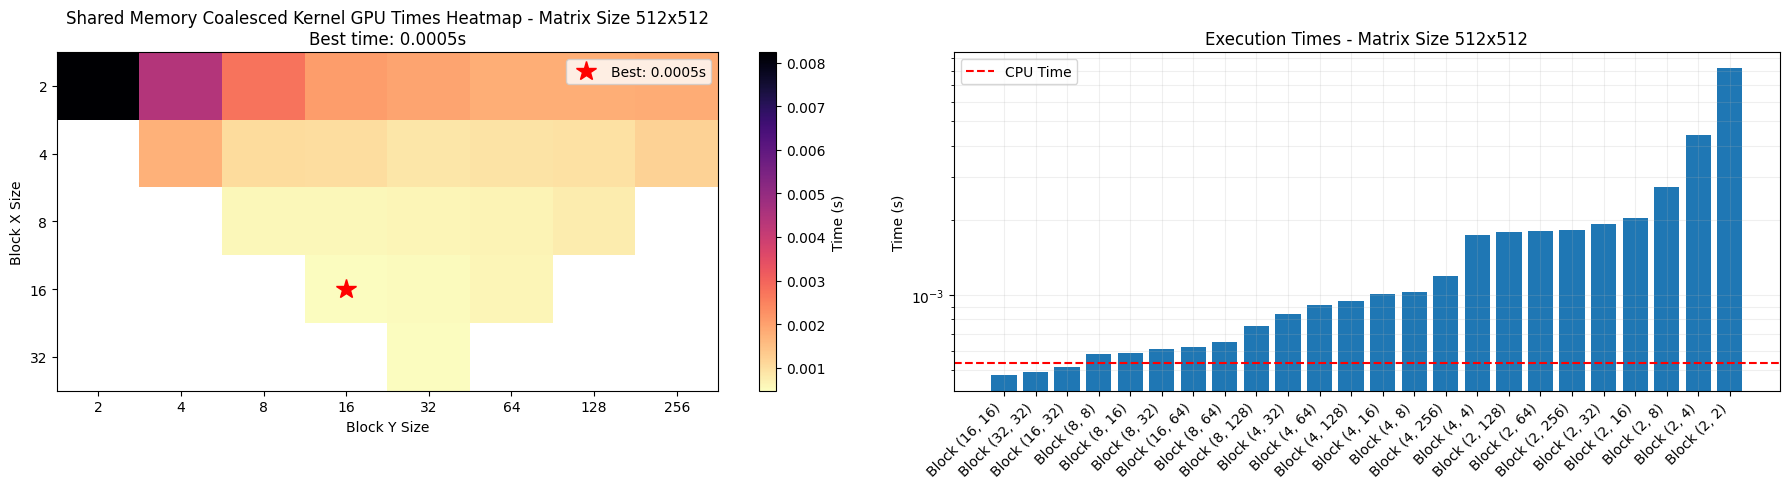

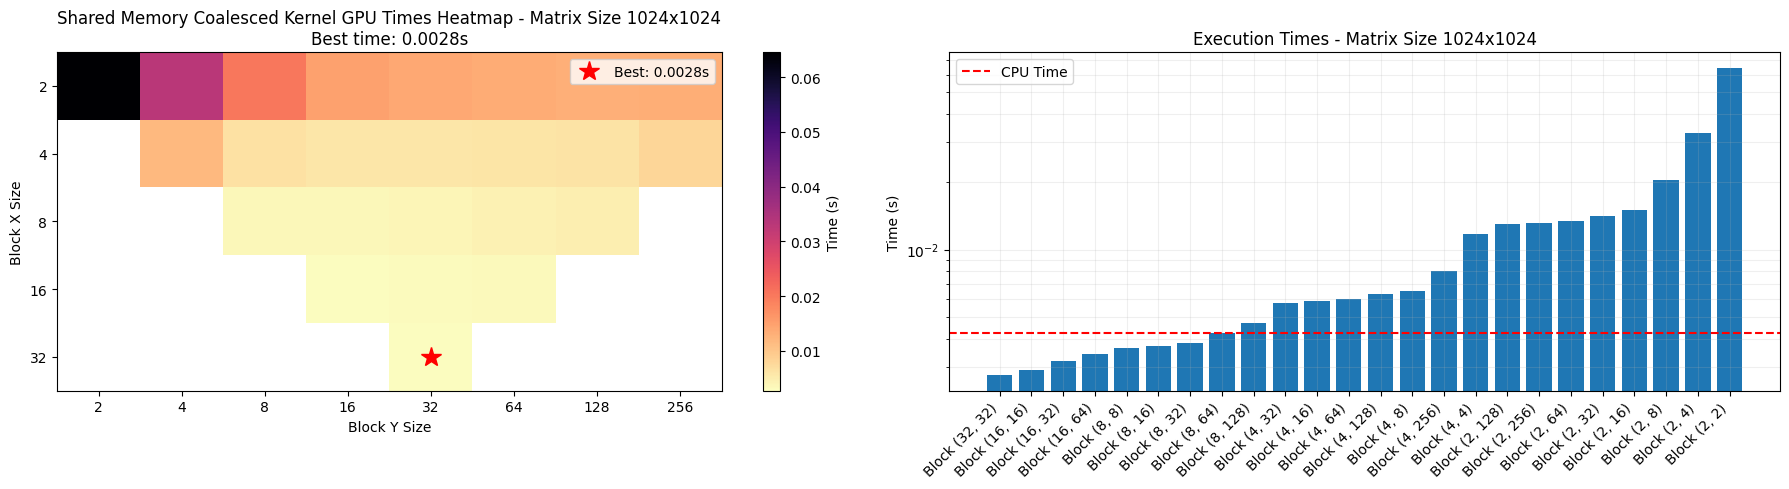

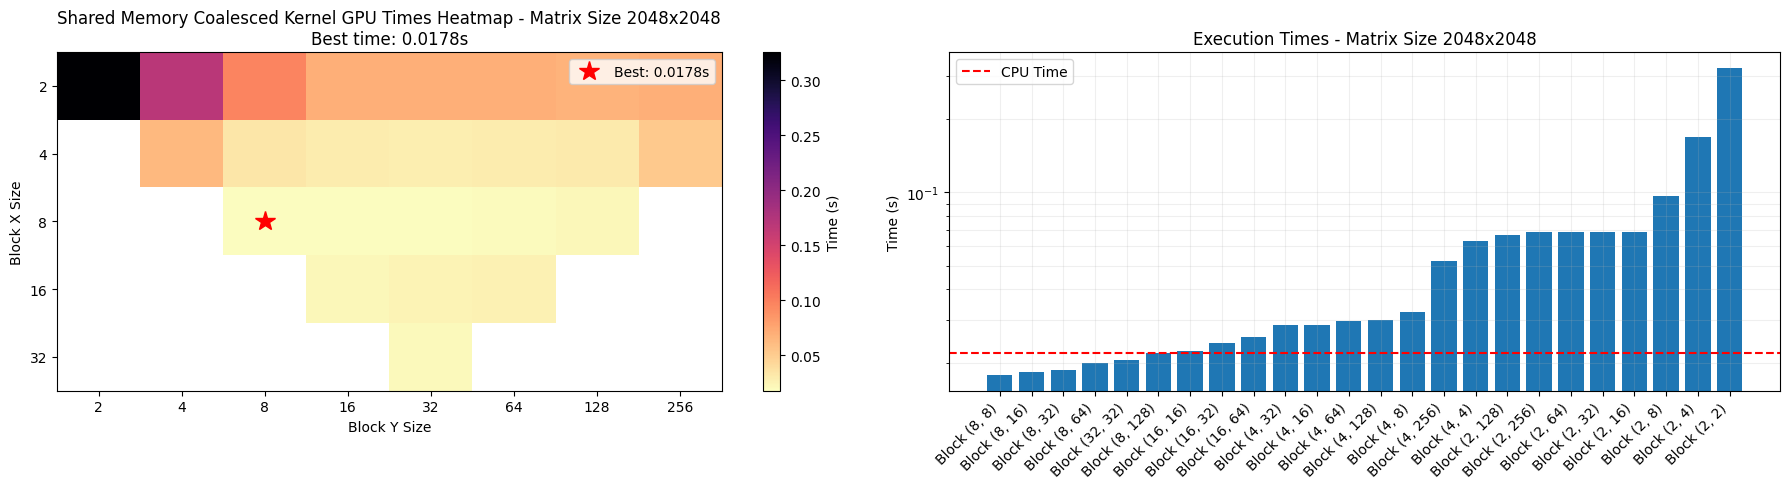

In [16]:
plot_results(results_shared_coalesced, 'Shared Memory Coalesced Kernel')

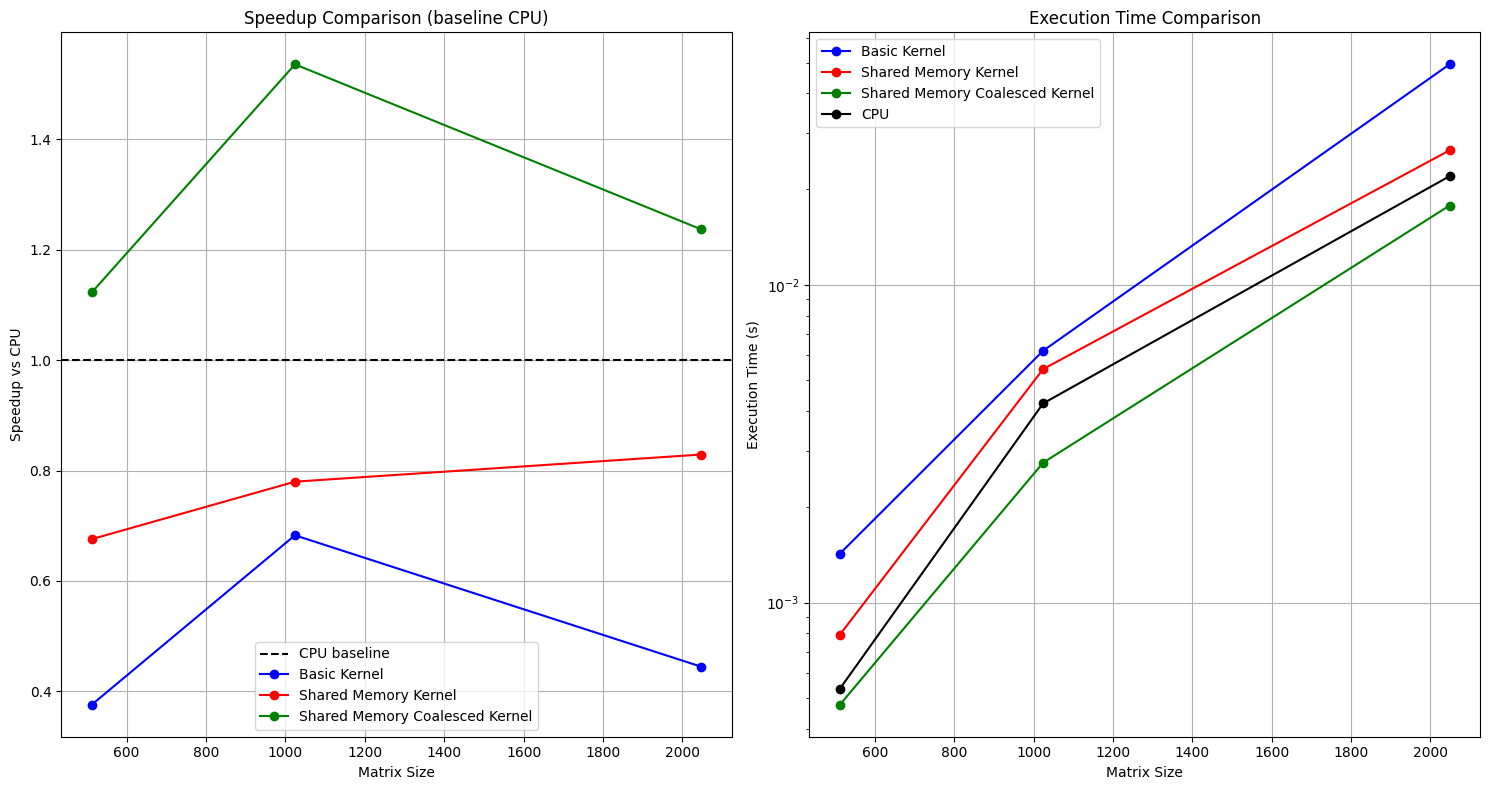


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Shared Memory Coalesced Kernel Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0014    |    0.0008    |    0.0005    | (16, 16)
    1024     |    0.0062    |    0.0054    |    0.0028    | (32, 32)
    2048     |    0.0494    |    0.0265    |    0.0178    | (8, 8)


In [17]:
best_times_shared_coalesced = {}
for N in matrix_sizes:
    shared_N = [r for r in results_shared_coalesced if r['matrix_size'] == N]
    best_times_shared_coalesced[N] = min(shared_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_shared_coalesced], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Shared Memory Coalesced Kernel'],
                      matrix_sizes)

<font color='blue'>

The results look promising. 

The cpu is finally undercut under all circumstances. 

Since the reconstruction still align with CPU, I believe this was done correctly.

</font>

<font color='blue'>
Next thing I looked into was the subtiling which is essentially "just"* that threads instead of calculating only 1 value, get a assigned a submatrix (TM, TN) for which they are responsible


\* it was not free

So we keep normal outer loop but now instead of having threads equivalent of to block dim, we assign threads multiple values within the block in the size of (TM, TN)

![Subtiling](https://siboehm.com/assets/img/CUDA-MMM/kernel_5_2D_blocktiling.png)


</font>

In [18]:

def get_kernel_tiled(BM, BN):
    
    BK = int(BM / 2)
    TM = int(BM / 4)
    TN = int(BN / 4)

    print(f"BM: {BM}, BN: {BN}, BK: {BK}, TM: {TM}, TN: {TN}")

    @cuda.jit
    def svd_reconstruct_tiled(U, S, Vt, out, M, N, K):
        """
        estimated time spent making this work dynamically: 8 hours
        Huge thanks to https://siboehm.com/articles/22/CUDA-MMM
        """

        bx = cuda.blockIdx.x
        by = cuda.blockIdx.y
        tx = cuda.threadIdx.x
        
        # This thread is responsible for TM x TN sub-results in the final C
        # We also define how many threads per block in x-dimension:
        # if total threads in a block = (BM*BN)/(TM*TN) we can find local row/col
        # But we'll keep it simpler: each block is BM x BN results, each thread produces TM x TN sub-result
        # -> we define "threadRow" & "threadCol" in that 2D sub-block:
        threads_per_block = (BM * BN) // (TM * TN)
        # safety check 
        if threads_per_block != cuda.blockDim.x:
            return  

        # The row "tile" in the block for this thread:
        threadRow = tx // (BN // TN)
        threadCol = tx %  (BN // TN)

        # Output tile base index:
        row_start = by * BM
        col_start = bx * BN

        # Shared memory for chunk of U, V^T
        # U-shape: BM x BK, V^T-shape: BK x BN
        U_shared = cuda.shared.array(shape=(BM, BK), dtype=float32)
        Vt_shared = cuda.shared.array(shape=(BK, BN), dtype=float32)

        # each thread accumulates TM x TN partial results
        result = cuda.local.array(shape=(TM, TN), dtype=float32)
        for r in range(TM):
            for c in range(TN):
                result[r, c] = 0.0


        # for each block tile in the K dimension
        for k_tile in range(0, K, BK):
            # each thread loads some portion of the BM x BK chunk
            load_x = tx
            # we'll stride along BM direction in increments of blockDim.x so downward 
            while load_x < BM:
                # go through the BK dimension (across the columns) ---> 
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (row_start + load_x) < M:
                        U_shared[load_x, kk] = U[row_start + load_x, real_k]
                    else:
                        U_shared[load_x, kk] = 0.0
                load_x += threads_per_block

            # load the tile of V^T into Bs
            load_y = tx
            # go through the BN dimension (across the columns) of V^T so to the right
            while load_y < BN:
                # go through the BK dimension (across the rows) of V^T so to the bottom
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (col_start + load_y) < N:
                        # we allocate the S tile here as well to save storage
                        Vt_shared[kk, load_y] = Vt[real_k, col_start + load_y] * S[real_k]
                    else:
                        Vt_shared[kk, load_y] = 0.0
                load_y += threads_per_block

            cuda.syncthreads()

            # compute partial sums for TM x TN sub-block in registers
            #  dotIdx is always across bk so inner dim
            for dotIdx in range(BK):
                # first row wise 
                for i in range(TM):
                    # row in As
                    rowA = threadRow * TM + i
                    aVal = U_shared[rowA, dotIdx]
                    # then col wise
                    for j in range(TN):
                        # col in Bs
                        colB = threadCol * TN + j
                        # calculate the partial sum for all the rows of that col in Bs within a thread
                        result[i, j] += aVal * Vt_shared[dotIdx, colB]

            cuda.syncthreads()

        # store results to global memory
        for i in range(TM):
            out_row = row_start + (threadRow * TM) + i
            if out_row < M:
                for j in range(TN):
                    out_col = col_start + (threadCol * TN) + j
                    if out_col < N:
                        out[out_row, out_col] = result[i, j]
    return svd_reconstruct_tiled


In [19]:

results_reuse = []


for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']

    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        # skip configs that are below 4x4
        if block_size[0] < 4 or block_size[1] < 4:
           continue
           
        # we don't have to technically spilit as our matrix is square
        M, _ = u.shape
        _, N = vt.shape
        # Tile sizes: BM=16, BN=16 => we want grid = ceil(M/16, N/16) blocks
        BM = int(block_size[0])
        BN = int(block_size[1])
        blocks_x = math.ceil(N / BN)
        blocks_y = math.ceil(M / BM)
        
        threads_per_block = (BM * BN) // (BM / 4 * BN / 4)   # = (16*16)/(4*4) = 16

        

        kernel = get_kernel_tiled(BM, BN)
        grid_dim = (blocks_x, blocks_y)
        block_dim = (int(threads_per_block),)
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        
        
        start_event = cuda.event()
        stop_event = cuda.event()
        # Timed run
        start_event.record()
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        stop_event.record()

        gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
        gpu_time = gpu_time_ms / 1000

        # Copy result back to host
        C_gpu = C_device.copy_to_host()
        
        # check if the result is correct
        C_cpu = np.dot(np.dot(u[:N, :k], np.diag(s[:k])), vt[:k, :N])
        assert np.allclose(C_gpu, C_cpu, atol=1e-1), "Result mismatch"
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_reuse.append({
            'kernel': 'shared',
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")



BM: 4, BN: 4, BK: 2, TM: 1, TN: 1
Block size (4, 4): GPU time = 0.0031s, Speedup = 0.17x
BM: 4, BN: 8, BK: 2, TM: 1, TN: 2
Block size (4, 8): GPU time = 0.0017s, Speedup = 0.32x
BM: 4, BN: 16, BK: 2, TM: 1, TN: 4
Block size (4, 16): GPU time = 0.0010s, Speedup = 0.55x
BM: 4, BN: 32, BK: 2, TM: 1, TN: 8
Block size (4, 32): GPU time = 0.0007s, Speedup = 0.78x
BM: 4, BN: 64, BK: 2, TM: 1, TN: 16
Block size (4, 64): GPU time = 0.0008s, Speedup = 0.67x
BM: 4, BN: 128, BK: 2, TM: 1, TN: 32
Block size (4, 128): GPU time = 0.0011s, Speedup = 0.48x
BM: 4, BN: 256, BK: 2, TM: 1, TN: 64
Block size (4, 256): GPU time = 0.0014s, Speedup = 0.39x
BM: 8, BN: 8, BK: 4, TM: 2, TN: 2
Block size (8, 8): GPU time = 0.0009s, Speedup = 0.59x
BM: 8, BN: 16, BK: 4, TM: 2, TN: 4
Block size (8, 16): GPU time = 0.0006s, Speedup = 0.96x
BM: 8, BN: 32, BK: 4, TM: 2, TN: 8
Block size (8, 32): GPU time = 0.0005s, Speedup = 1.05x
BM: 8, BN: 64, BK: 4, TM: 2, TN: 16
Block size (8, 64): GPU time = 0.0006s, Speedup = 0.8

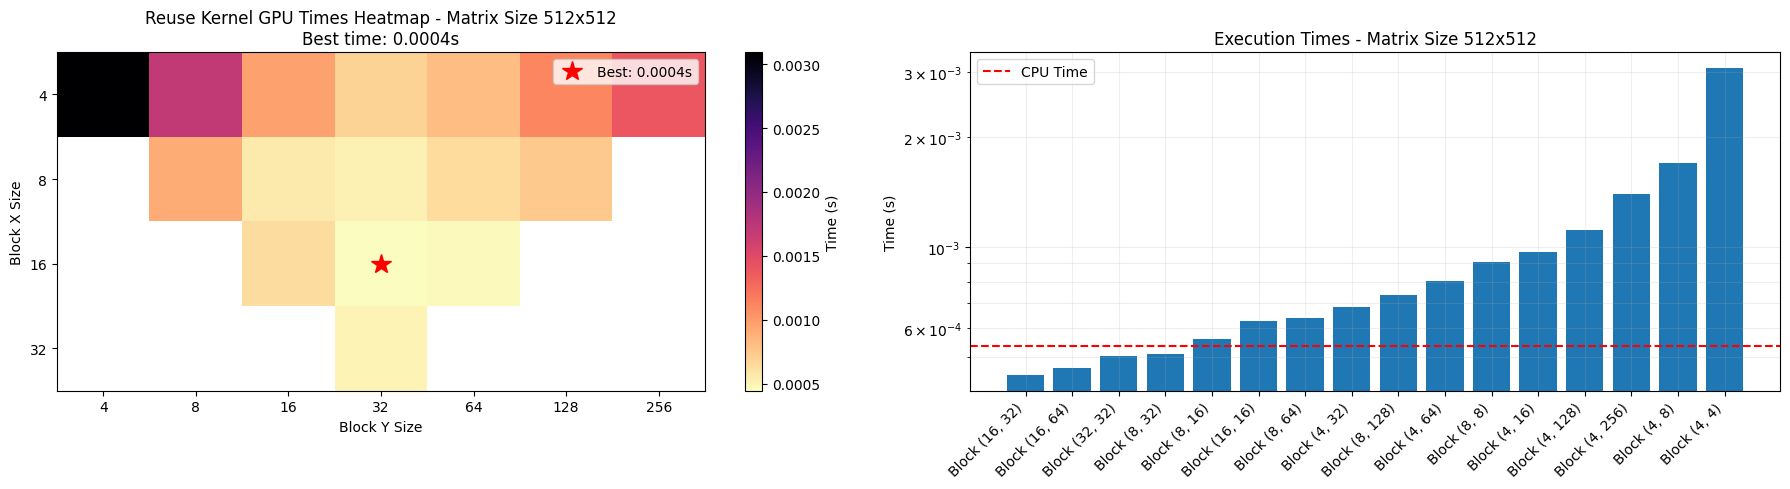

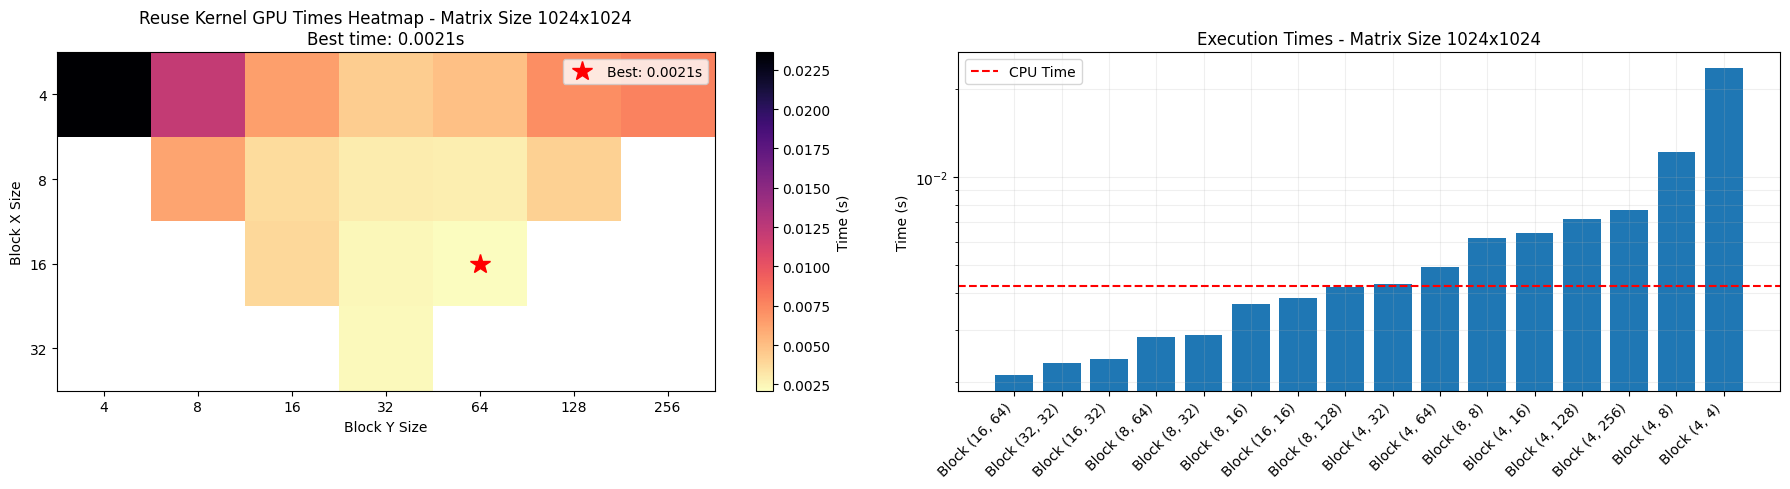

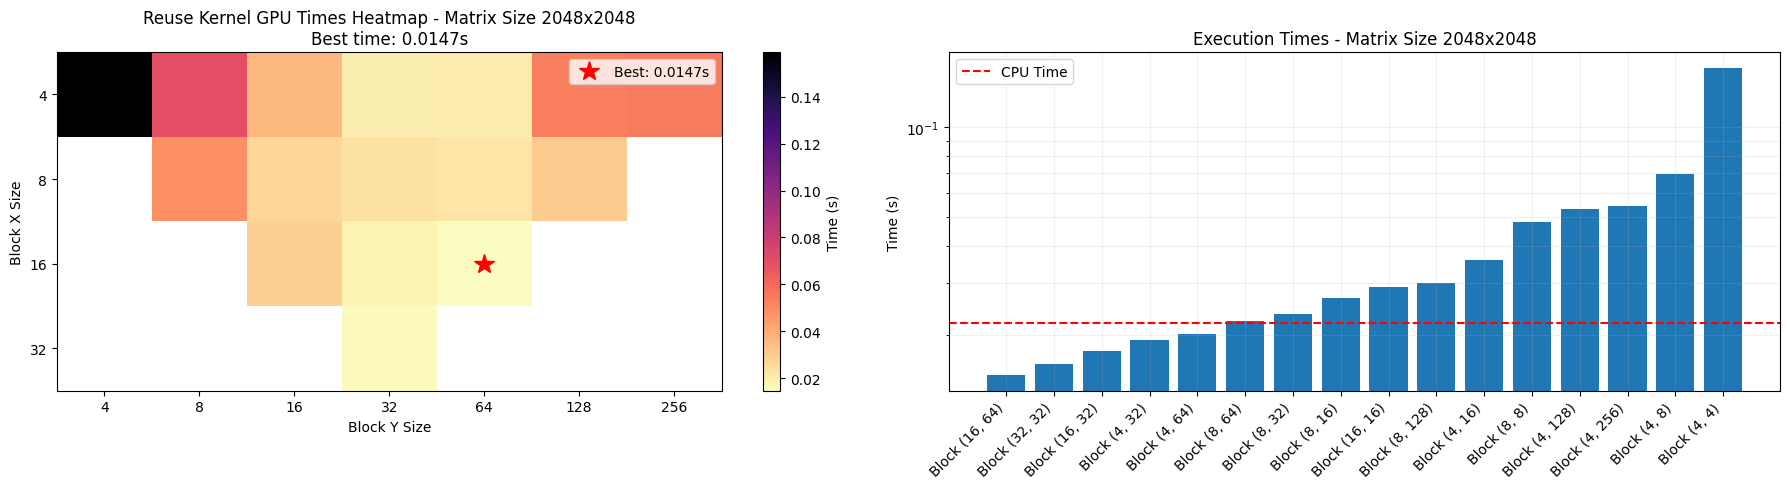

In [20]:
plot_results(results_reuse, 'Reuse Kernel')

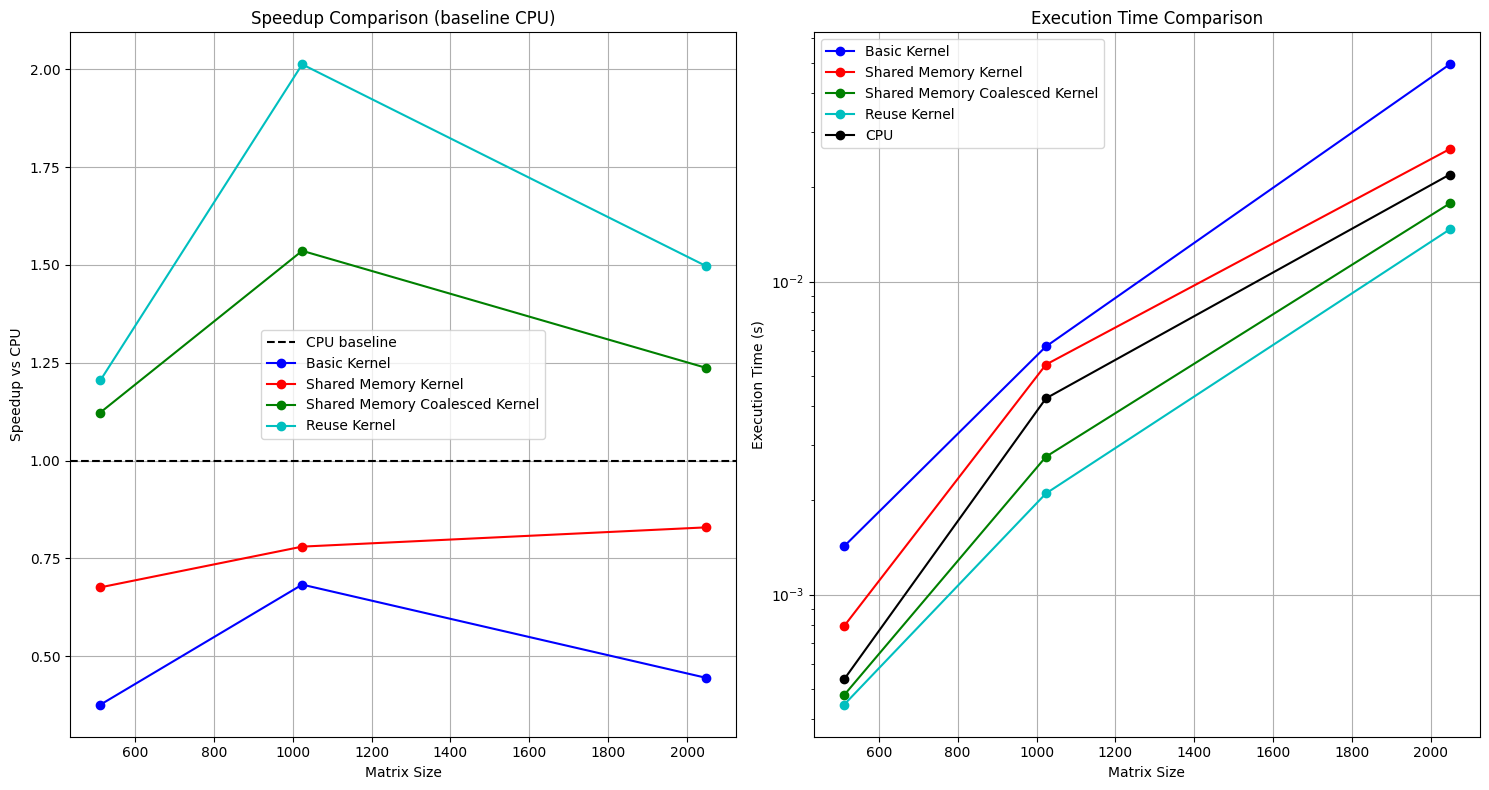


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Shared Memory Coalesced Kernel Time | Reuse Kernel Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0014    |    0.0008    |    0.0005    |    0.0004    | (16, 32)
    1024     |    0.0062    |    0.0054    |    0.0028    |    0.0021    | (16, 64)
    2048     |    0.0494    |    0.0265    |    0.0178    |    0.0147    | (16, 64)


In [21]:
best_times_reuse = {}
for N in matrix_sizes:
    shared_N = [r for r in results_reuse if r['matrix_size'] == N]
    best_times_reuse[N] = min(shared_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_shared_coalesced, best_times_reuse], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Shared Memory Coalesced Kernel', 'Reuse Kernel'],
                      matrix_sizes)

<font color='blue'>
Does it work? Yes

Is it faster? Yes

Was it worth it? I am not sure. 

Looking at the results from this and before it is interesting to see the relative speed up on 1024 x 1024 matrix. Somehow the other kernels had some non linear slowdown there, which they made up again at the bigger 2048 x 2048 matrix. 

This may be due to some very efficient thread/block assignment of the improved kernels which led to some cuda magic.

</font>

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe, welche Bottlenecks du gefunden bzw. entschärft hast.

<font color='blue'>


</font>

##### Optimization

I started off with the optimized kernel from 5.2.3 and then used the ncu profiler to find the bottlenecks. Even though it is the fastest kernel so far, I want to push it below 10ms on a 2048x2048 matrix.

NCU Profile: optimized_profile_original.ncu-rep

Profiling showed a lot, but something that stood out was theoretical occupancy.
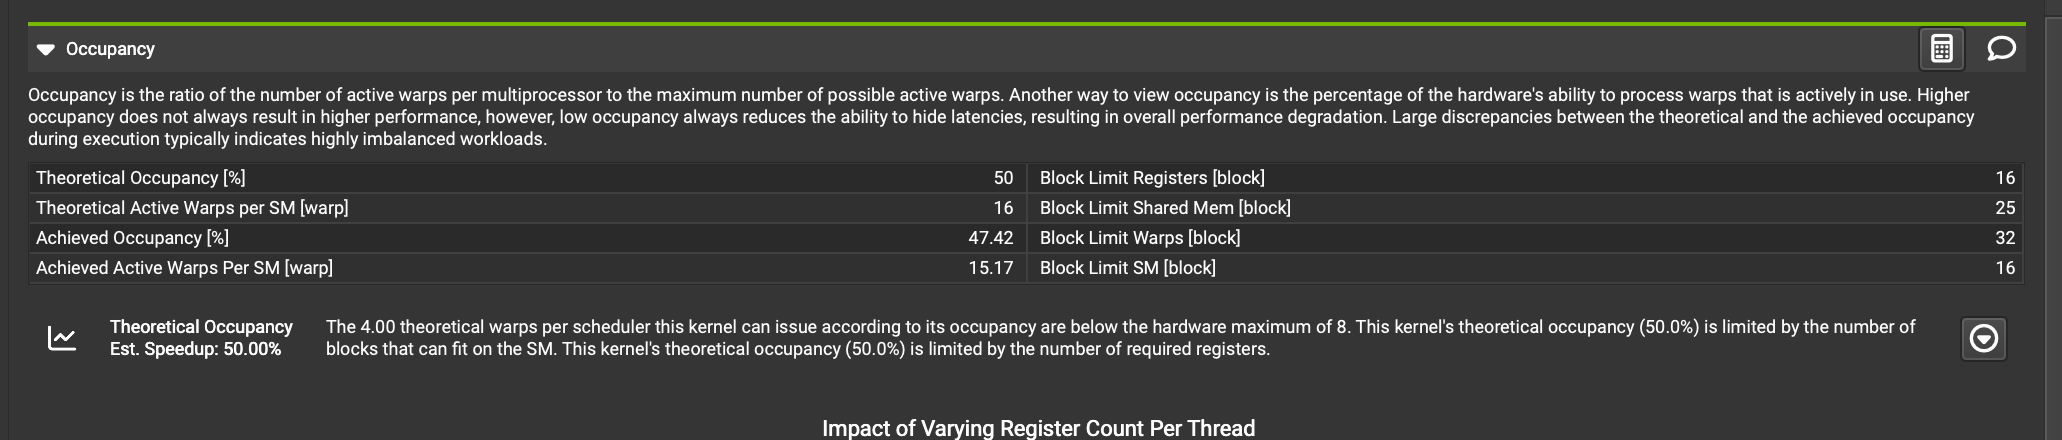

it said:
The 4.00 theoretical warps per scheduler this kernel can issue according to its occupancy are below the hardware maximum of 8. This kernel's theoretical occupancy (50.0%) is limited by the number of blocks that can fit on the SM. This kernel's theoretical occupancy (50.0%) is limited by the number of required registers.


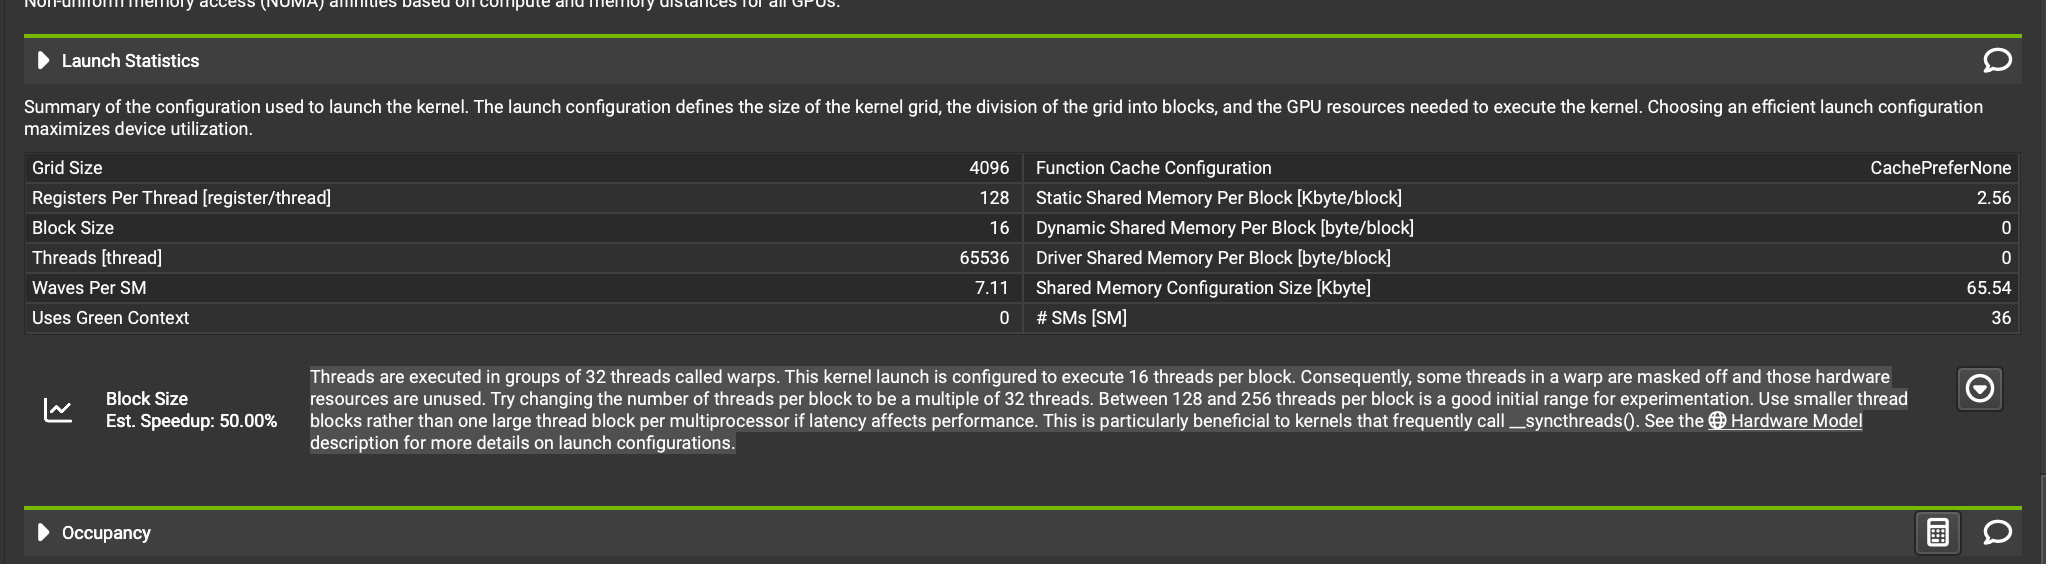


So there were not enough threads per block to fill the SM. I can fix that. 

My custom tile kernel calculates the size per thread based on the block size divided by 4. 

I can change that to divide by 8, which means a thread has half the size of the original tile kernel, therefore leading to more threads.


In [22]:

def get_kernel_tiled_v1(BM, BN):
    
    BK = int(BM / 2)
    ### The 4.00 theoretical warps per scheduler this kernel can issue according to its occupancy are below the hardware maximum of 8. This kernel's theoretical occupancy (50.0%) is limited by the number of blocks that can fit on the SM. This kernel's theoretical occupancy (50.0%) is limited by the number of required registers.
    # we will decrease the matrix per thread, therefore leading to more threads
    TM = int(BM / 8)
    TN = int(BN / 8)

    print(f"BM: {BM}, BN: {BN}, BK: {BK}, TM: {TM}, TN: {TN}")

    @cuda.jit
    def svd_reconstruct_tiled(U, S, Vt, out, M, N, K):
        """
        estimated time spent making this work dynamically: 8 hours
        Huge thanks to https://siboehm.com/articles/22/CUDA-MMM
        """

        bx = cuda.blockIdx.x
        by = cuda.blockIdx.y
        tx = cuda.threadIdx.x
        
        # This thread is responsible for TM x TN sub-results in the final C
        # We also define how many threads per block in x-dimension:
        # if total threads in a block = (BM*BN)/(TM*TN) we can find local row/col
        # But we'll keep it simpler: each block is BM x BN results, each thread produces TM x TN sub-result
        # -> we define "threadRow" & "threadCol" in that 2D sub-block:
        threads_per_block = (BM * BN) // (TM * TN)
        # safety check or assumption:
        if threads_per_block != cuda.blockDim.x:
            return  # mismatch: user must set blockDim.x to threads_per_block

        # The row "tile" in the block for this thread:
        threadRow = tx // (BN // TN)
        threadCol = tx %  (BN // TN)

        # Output tile base index:
        row_start = by * BM
        col_start = bx * BN

        # Shared memory for chunk of U, V^T
        # U-shape: BM x BK, V^T-shape: BK x BN
        U_shared = cuda.shared.array(shape=(BM, BK), dtype=float32)
        Vt_shared = cuda.shared.array(shape=(BK, BN), dtype=float32)

        # each thread accumulates TM x TN partial results
        result = cuda.local.array(shape=(TM, TN), dtype=float32)
        for r in range(TM):
            for c in range(TN):
                result[r, c] = 0.0


        # for each block tile in the K dimension
        for k_tile in range(0, K, BK):
            # each thread loads some portion of the BM x BK chunk
            load_x = tx
            # we'll stride along BM direction in increments of blockDim.x so downward 
            while load_x < BM:
                # go through the BK dimension (across the columns) ---> 
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (row_start + load_x) < M:
                        U_shared[load_x, kk] = U[row_start + load_x, real_k]
                    else:
                        U_shared[load_x, kk] = 0.0
                load_x += threads_per_block

            # load the tile of V^T into Bs
            load_y = tx
            # go through the BN dimension (across the columns) of V^T so to the right
            while load_y < BN:
                # go through the BK dimension (across the rows) of V^T so to the bottom
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (col_start + load_y) < N:
                        # we allocate the S tile here as well to save storage
                        Vt_shared[kk, load_y] = Vt[real_k, col_start + load_y] * S[real_k]
                    else:
                        Vt_shared[kk, load_y] = 0.0
                load_y += threads_per_block

            cuda.syncthreads()

            # compute partial sums for TM x TN sub-block in registers
            #  dotIdx is always across bk so inner dim
            for dotIdx in range(BK):
                # first row wise 
                for i in range(TM):
                    # row in As
                    rowA = threadRow * TM + i
                    aVal = U_shared[rowA, dotIdx]
                    # then col wise
                    for j in range(TN):
                        # col in Bs
                        colB = threadCol * TN + j
                        # calculate the partial sum for all the rows of that col in Bs within a thread
                        result[i, j] += aVal * Vt_shared[dotIdx, colB]

            cuda.syncthreads()

        # store results to global memory
        for i in range(TM):
            out_row = row_start + (threadRow * TM) + i
            if out_row < M:
                for j in range(TN):
                    out_col = col_start + (threadCol * TN) + j
                    if out_col < N:
                        out[out_row, out_col] = result[i, j]
    return svd_reconstruct_tiled

In [23]:

results_tile_v1 = []

for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']

    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        # skip configs that are below 4x4
        if block_size[0] < 8 or block_size[1] < 8:
           continue
           
        # we don't have to technically spilit as our matrix is square
        M, _ = u.shape
        _, N = vt.shape
        # Tile sizes: BM=16, BN=16 => we want grid = ceil(M/16, N/16) blocks
        BM = int(block_size[0])
        BN = int(block_size[1])
        blocks_x = math.ceil(N / BN)
        blocks_y = math.ceil(M / BM)
        
        threads_per_block = (BM * BN) // (BM / 8 * BN / 8)   # = (16*16)/(4*4) = 16


        kernel = get_kernel_tiled_v1(BM, BN)
        grid_dim = (blocks_x, blocks_y)
        block_dim = (int(threads_per_block),)
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        
        
        start_event = cuda.event()
        stop_event = cuda.event()
        # Timed run
        start_event.record()
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        stop_event.record()

        gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
        gpu_time = gpu_time_ms / 1000

        # Copy result back to host
        C_gpu = C_device.copy_to_host()
        
        # check if the result is correct
        C_cpu = np.dot(np.dot(u[:N, :k], np.diag(s[:k])), vt[:k, :N])
        assert np.allclose(C_gpu, C_cpu, atol=1e-1), "Result mismatch"
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_tile_v1.append({
            'kernel': 'shared',
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")




BM: 8, BN: 8, BK: 4, TM: 1, TN: 1
Block size (8, 8): GPU time = 0.0009s, Speedup = 0.59x
BM: 8, BN: 16, BK: 4, TM: 1, TN: 2
Block size (8, 16): GPU time = 0.0006s, Speedup = 0.94x
BM: 8, BN: 32, BK: 4, TM: 1, TN: 4
Block size (8, 32): GPU time = 0.0004s, Speedup = 1.36x
BM: 8, BN: 64, BK: 4, TM: 1, TN: 8
Block size (8, 64): GPU time = 0.0004s, Speedup = 1.26x
BM: 8, BN: 128, BK: 4, TM: 1, TN: 16
Block size (8, 128): GPU time = 0.0006s, Speedup = 0.95x
BM: 16, BN: 16, BK: 8, TM: 2, TN: 2
Block size (16, 16): GPU time = 0.0005s, Speedup = 0.99x
BM: 16, BN: 32, BK: 8, TM: 2, TN: 4
Block size (16, 32): GPU time = 0.0004s, Speedup = 1.21x
BM: 16, BN: 64, BK: 8, TM: 2, TN: 8
Block size (16, 64): GPU time = 0.0003s, Speedup = 1.60x
BM: 32, BN: 32, BK: 16, TM: 4, TN: 4
Block size (32, 32): GPU time = 0.0004s, Speedup = 1.39x
BM: 8, BN: 8, BK: 4, TM: 1, TN: 1
Block size (8, 8): GPU time = 0.0063s, Speedup = 0.68x
BM: 8, BN: 16, BK: 4, TM: 1, TN: 2
Block size (8, 16): GPU time = 0.0035s, Speedup

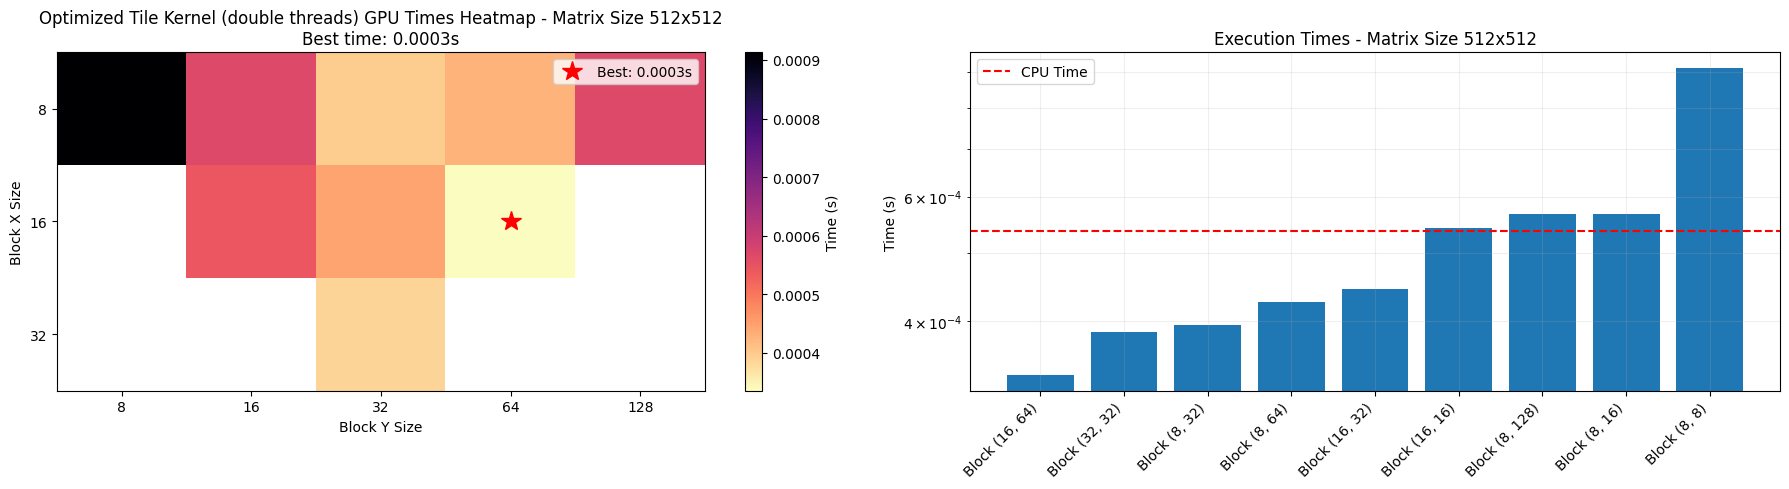

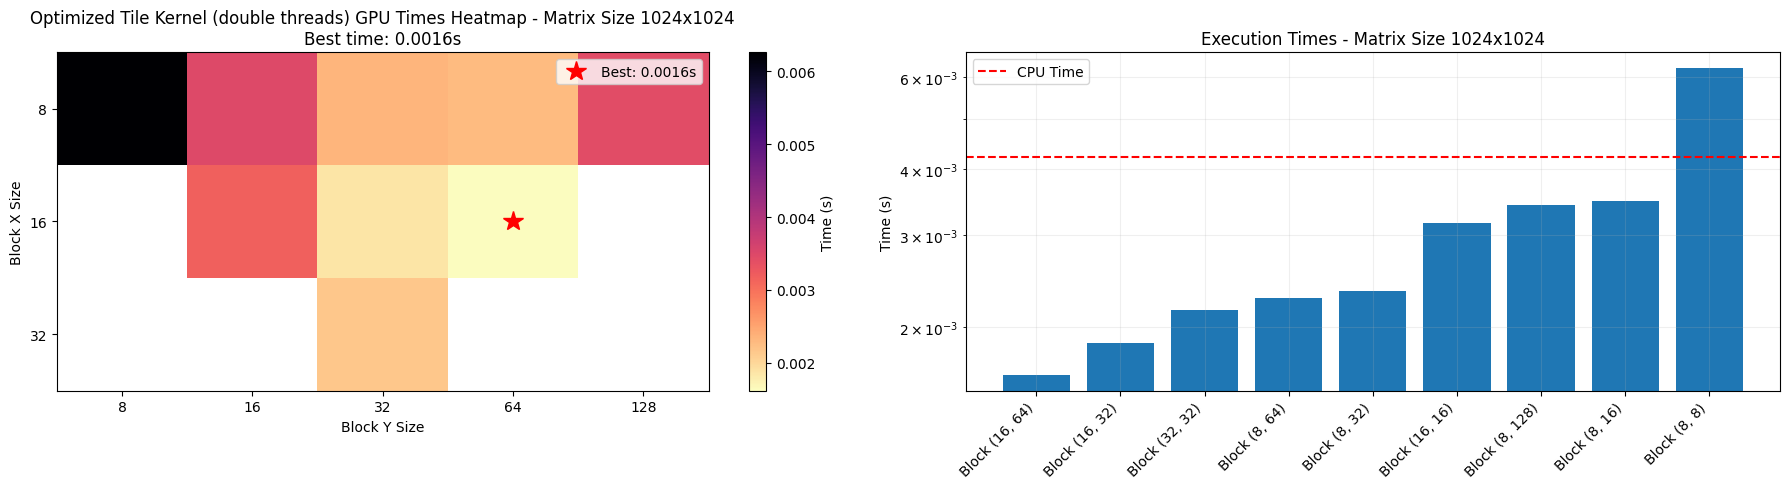

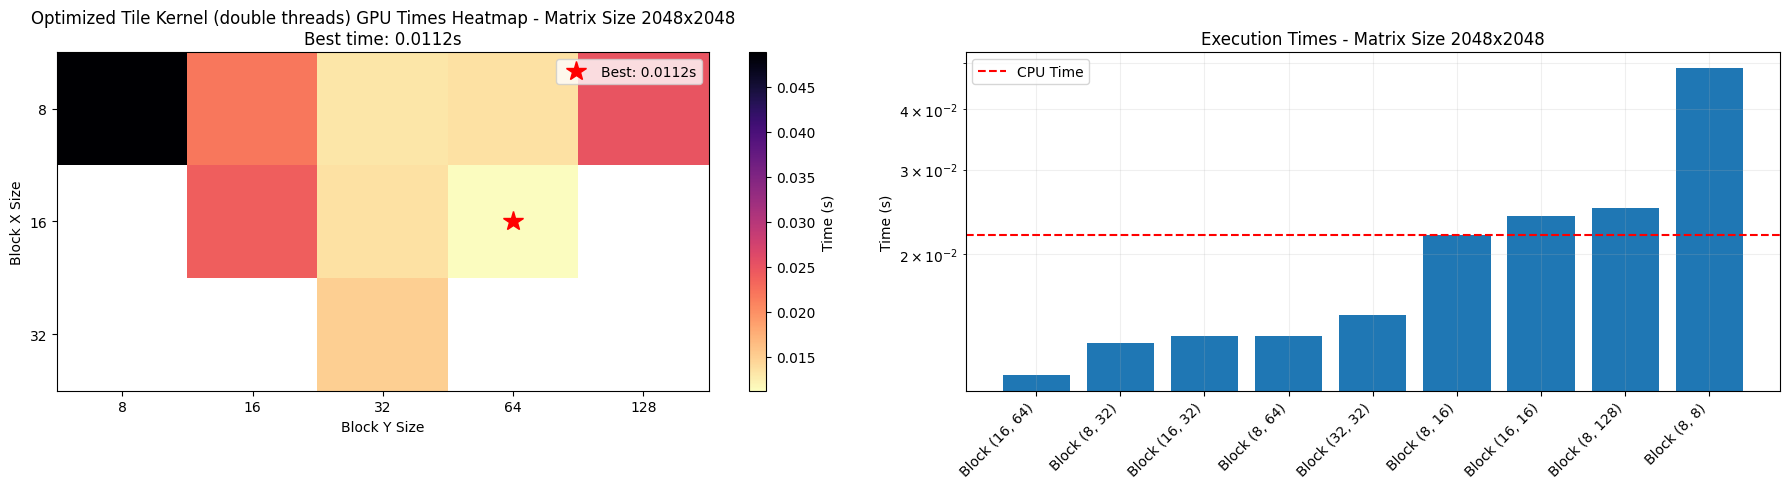

In [24]:
plot_results(results_tile_v1, 'Optimized Tile Kernel (double threads)')

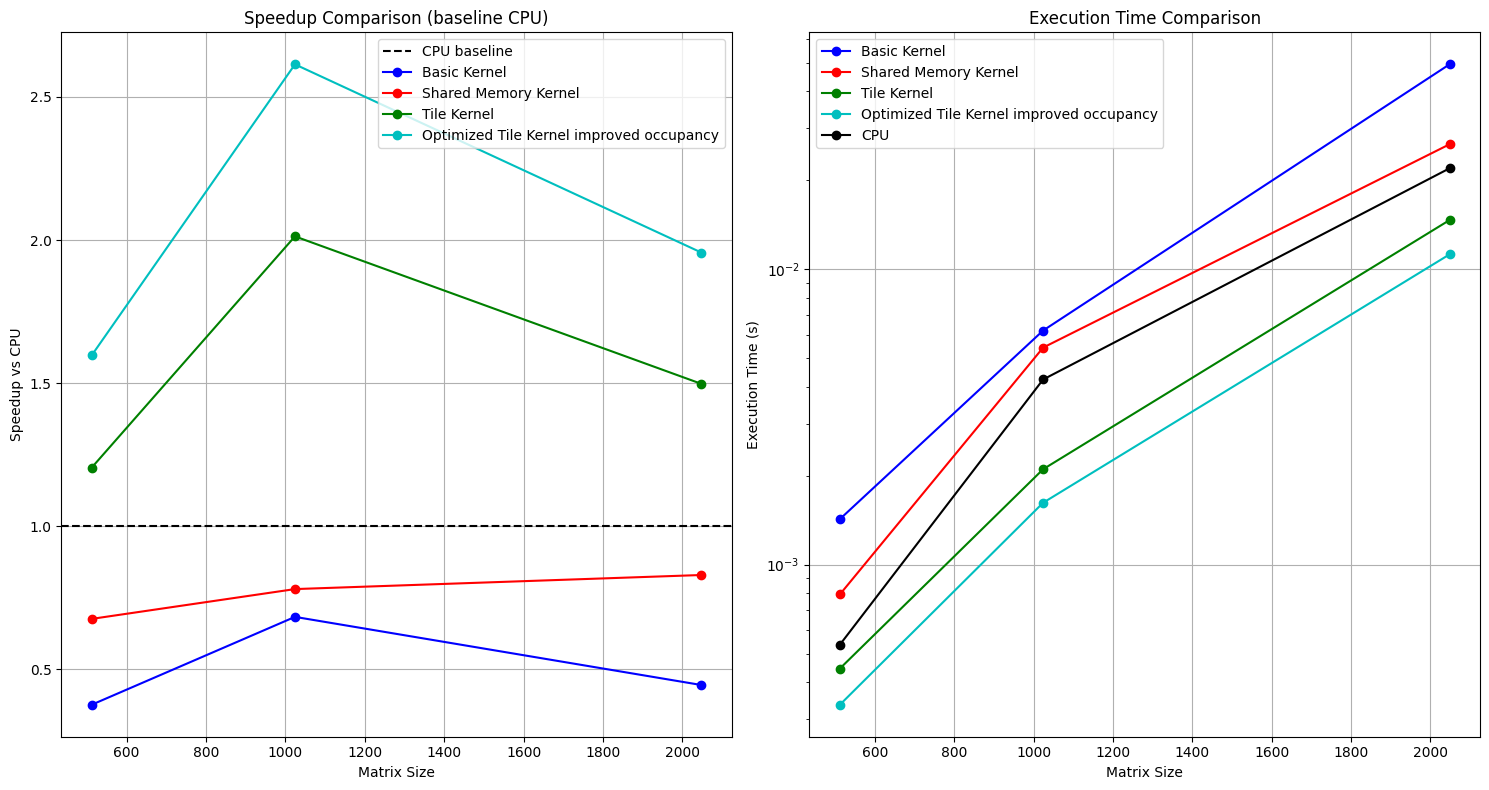


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Tile Kernel Time | Optimized Tile Kernel improved occupancy Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0014    |    0.0008    |    0.0004    |    0.0003    | (16, 64)
    1024     |    0.0062    |    0.0054    |    0.0021    |    0.0016    | (16, 64)
    2048     |    0.0494    |    0.0265    |    0.0147    |    0.0112    | (16, 64)


In [25]:
best_times_tile_v1 = {}
for N in matrix_sizes:
    optimized_tile_v1 = [r for r in results_tile_v1 if r['matrix_size'] == N]
    best_times_tile_v1[N] = min(optimized_tile_v1, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_reuse, best_times_tile_v1], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Tile Kernel', 'Optimized Tile Kernel improved occupancy'],
                      matrix_sizes) 

Looking good, I got roughly 20% speedup on 2048x2048. 

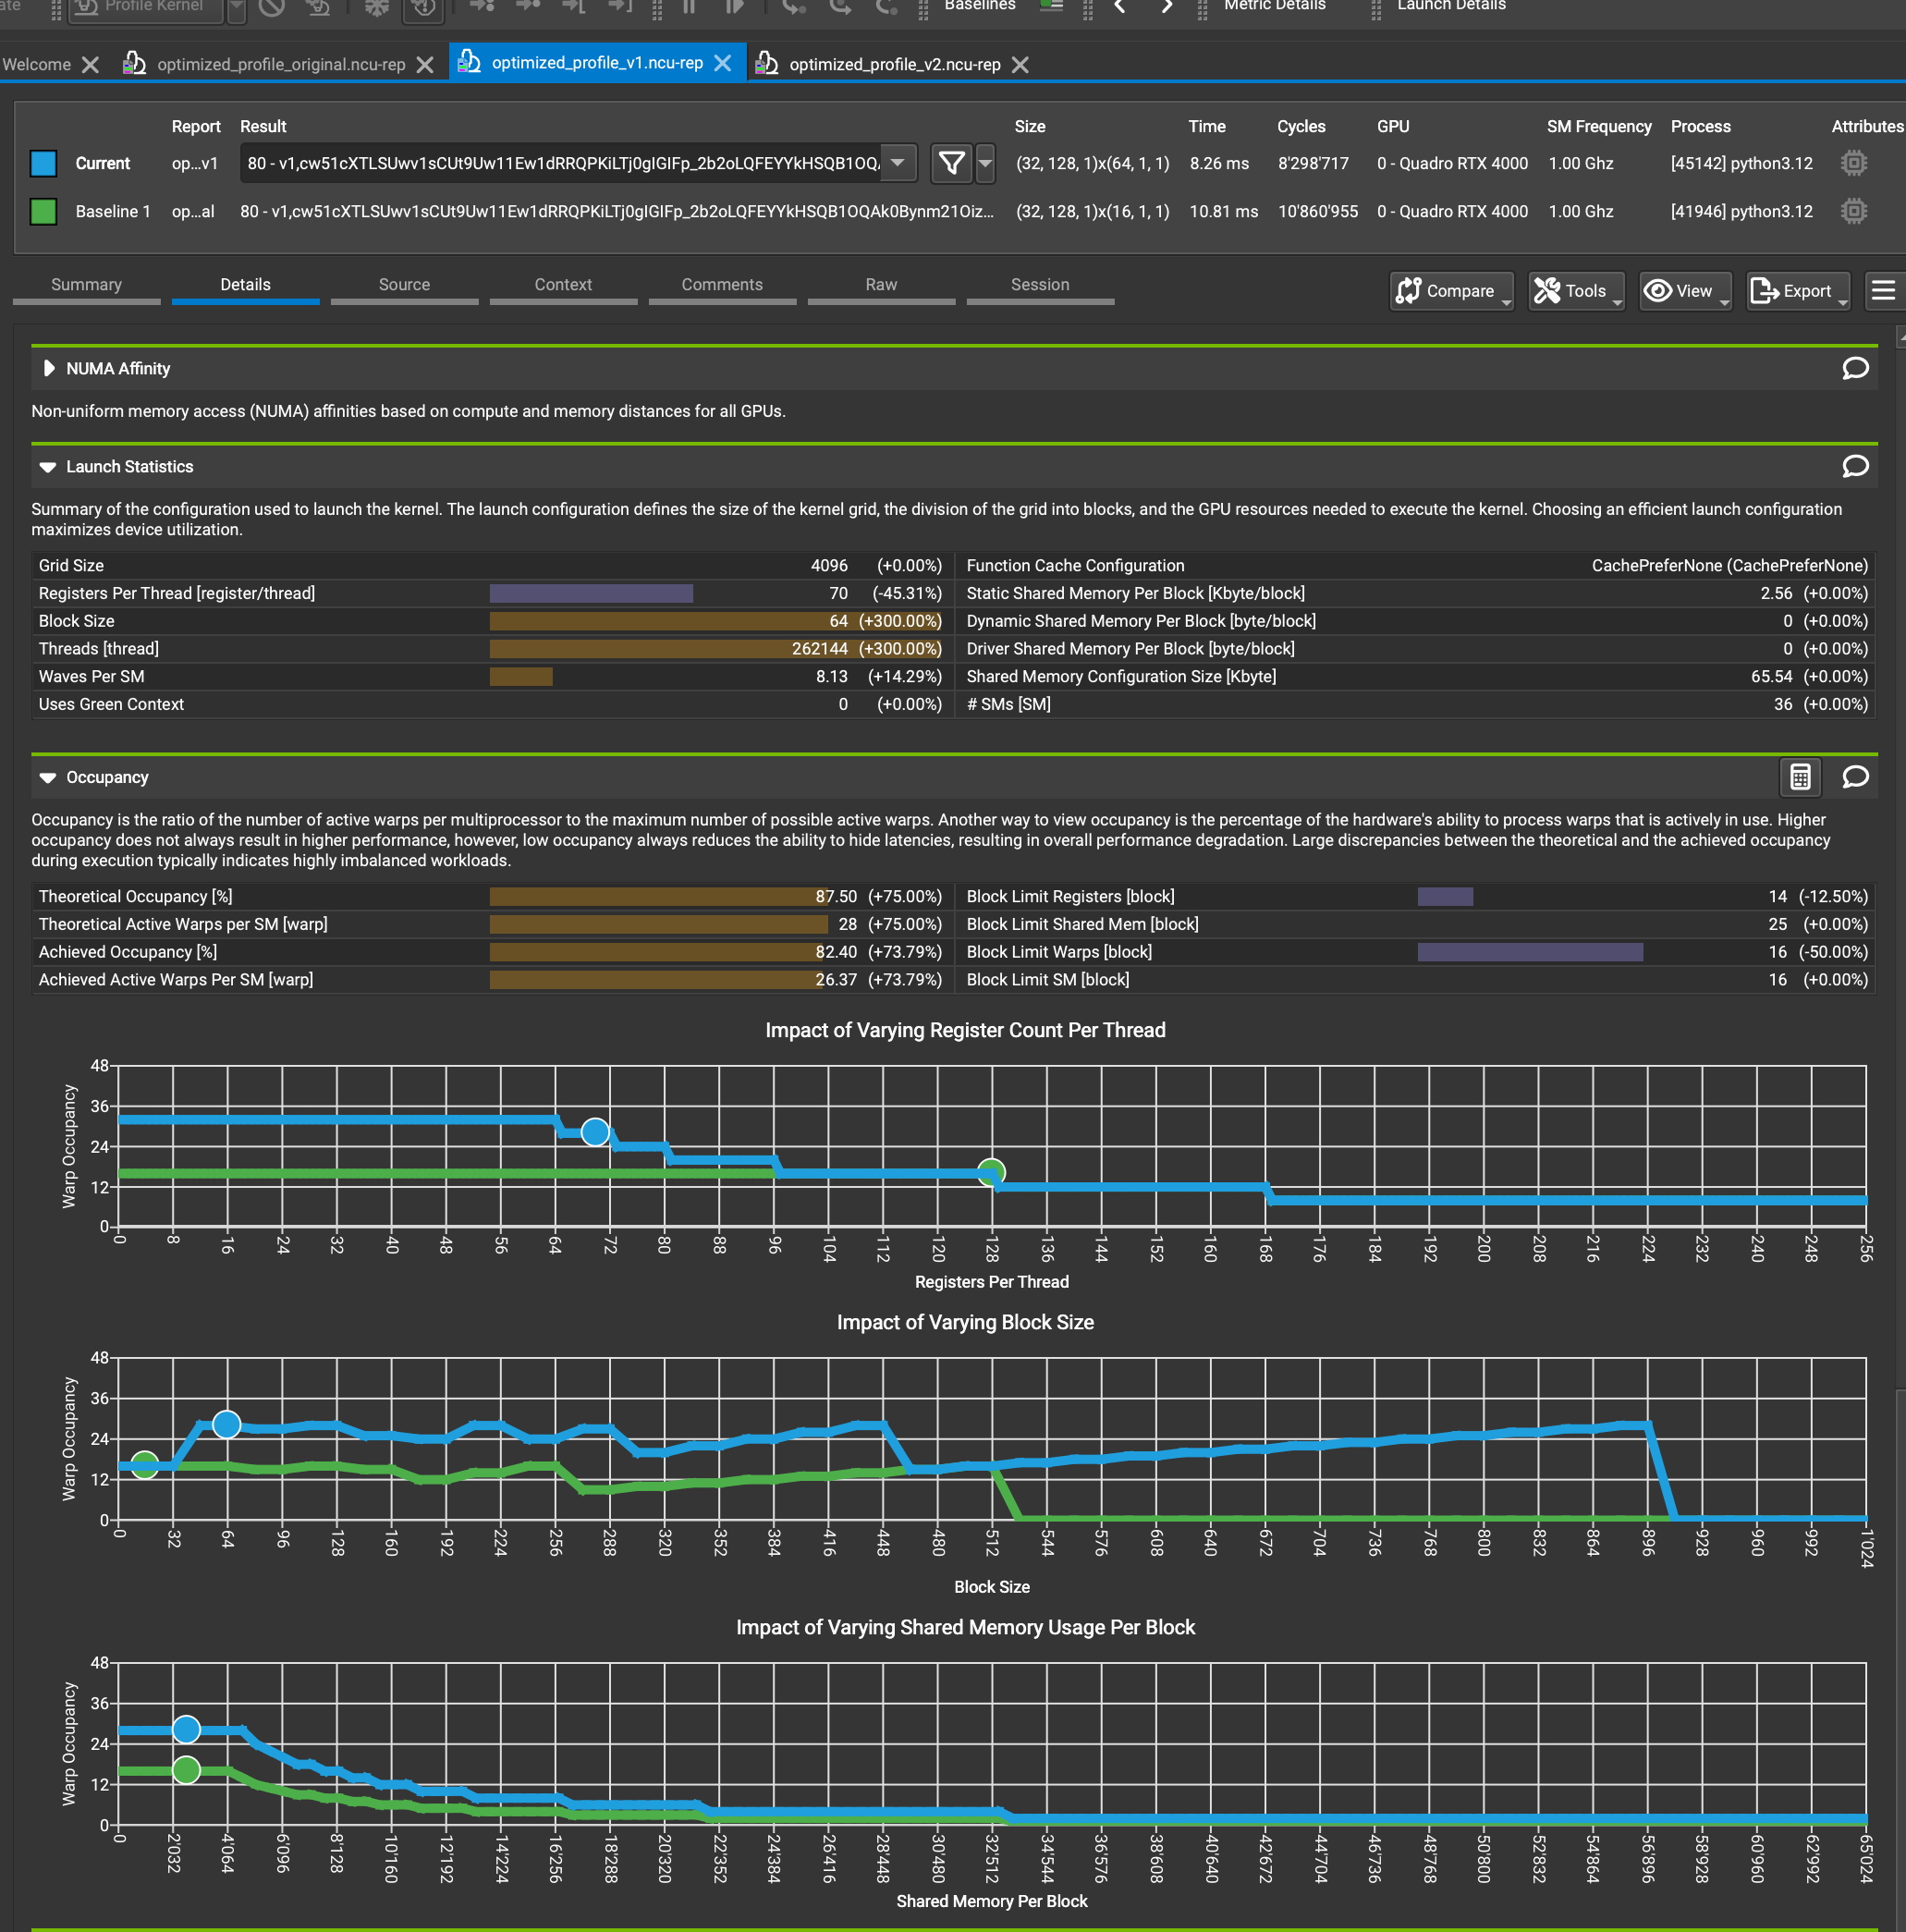



Now I looked at this new profile (optimized_profile_v1.ncu-rep) and looked for more bottlenecks. 

And found out that I have quite a few bank conflicts. 

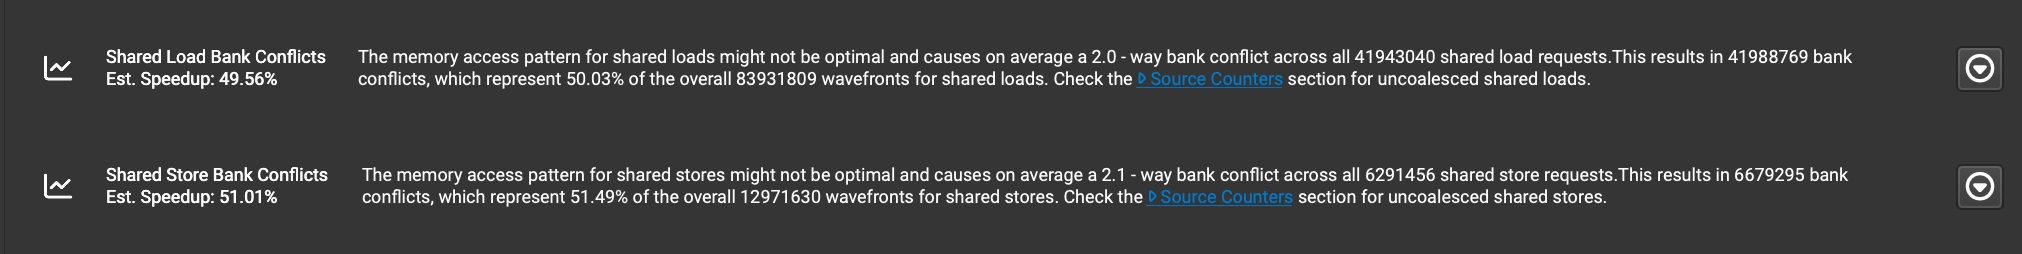

To solve this I decided to pad the shared memory arrays with 1 extra column. A bank conflict is caused when two threads try to write/read to the same memory location at the same time. The padding ensures that we can minimize the number of bank conflicts by essentially offsetting the memory access by 1 which doesn't completely solve the problem but should help

In [26]:

def get_kernel_tiled_padded(BM, BN):
    BK = int(BM / 2)
    TM = int(BM / 8)
    TN = int(BN / 8)
    # extra column for padding for shared memory
    PAD_U_COL = BK + 1
    PAD_V_COL = BN + 1

    print(f"BM: {BM}, BN: {BN}, BK: {BK}, TM: {TM}, TN: {TN} (with padding)")

    @cuda.jit(fastmath=True)
    def svd_reconstruct_tiled_padded(U, S, Vt, out, M, N, K):
        bx = cuda.blockIdx.x
        by = cuda.blockIdx.y
        tx = cuda.threadIdx.x

        threads_per_block = (BM * BN) // (TM * TN)
        if threads_per_block != cuda.blockDim.x:
            return  # mismatch

        threadRow = tx // (BN // TN)
        threadCol = tx %  (BN // TN)

        row_start = by * BM
        col_start = bx * BN

        # Notice we add 1 to BK dimension => shape=(BM, BK+1)
        U_shared = cuda.shared.array(shape=(BM, PAD_U_COL), dtype=float32)
        Vt_shared = cuda.shared.array(shape=(BK, PAD_V_COL), dtype=float32)
        
        result = cuda.local.array(shape=(TM, TN), dtype=float32)
        for r in range(TM):
            for c in range(TN):
                result[r, c] = float32(0.0)

        for k_tile in range(0, K, BK):
            load_x = tx
            while load_x < BM:
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (row_start + load_x) < M:
                        U_shared[load_x, kk] = U[row_start + load_x, real_k]
                    else:
                        U_shared[load_x, kk] = 0.0
                load_x += threads_per_block

            load_y = tx
            while load_y < BN:
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (col_start + load_y) < N:
                        # multiply in S right here
                        Vt_shared[kk, load_y] = Vt[real_k, col_start + load_y] * S[real_k]
                    else:
                        Vt_shared[kk, load_y] = 0.0
                load_y += threads_per_block

            cuda.syncthreads()

            # compute partial sums
            for dotIdx in range(BK):
                for i in range(TM):
                    rowA = threadRow * TM + i
                    aVal = U_shared[rowA, dotIdx]
                    for j in range(TN):
                        colB = threadCol * TN + j
                        result[i, j] += aVal * Vt_shared[dotIdx, colB]

            cuda.syncthreads()

        # store
        for i in range(TM):
            out_row = row_start + (threadRow * TM) + i
            if out_row < M:
                for j in range(TN):
                    out_col = col_start + (threadCol * TN) + j
                    if out_col < N:
                        out[out_row, out_col] = result[i, j]

    return svd_reconstruct_tiled_padded


In [27]:

results_tile_v2 = []

for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']

    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        # skip configs that are below 4x4
        if block_size[0] < 8 or block_size[1] < 8:
           continue
           
        # we don't have to technically spilit as our matrix is square
        M, _ = u.shape
        _, N = vt.shape
        # Tile sizes: BM=16, BN=16 => we want grid = ceil(M/16, N/16) blocks
        BM = int(block_size[0])
        BN = int(block_size[1])
        blocks_x = math.ceil(N / BN)
        blocks_y = math.ceil(M / BM)
        
        threads_per_block = (BM * BN) // (BM / 8 * BN / 8)   # = (16*16)/(4*4) = 16


        kernel = get_kernel_tiled_padded(BM, BN)
        grid_dim = (blocks_x, blocks_y)
        block_dim = (int(threads_per_block),)
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        
        
        start_event = cuda.event()
        stop_event = cuda.event()
        # Timed run
        start_event.record()
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        stop_event.record()

        gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
        gpu_time = gpu_time_ms / 1000

        # Copy result back to host
        C_gpu = C_device.copy_to_host()
        
        # check if the result is correct
        C_cpu = np.dot(np.dot(u[:N, :k], np.diag(s[:k])), vt[:k, :N])
        assert np.allclose(C_gpu, C_cpu, atol=1e-1), "Result mismatch"
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_tile_v2.append({
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")




BM: 8, BN: 8, BK: 4, TM: 1, TN: 1 (with padding)
Block size (8, 8): GPU time = 0.0009s, Speedup = 0.58x
BM: 8, BN: 16, BK: 4, TM: 1, TN: 2 (with padding)
Block size (8, 16): GPU time = 0.0006s, Speedup = 0.96x
BM: 8, BN: 32, BK: 4, TM: 1, TN: 4 (with padding)
Block size (8, 32): GPU time = 0.0004s, Speedup = 1.35x
BM: 8, BN: 64, BK: 4, TM: 1, TN: 8 (with padding)
Block size (8, 64): GPU time = 0.0004s, Speedup = 1.32x
BM: 8, BN: 128, BK: 4, TM: 1, TN: 16 (with padding)
Block size (8, 128): GPU time = 0.0006s, Speedup = 0.89x
BM: 16, BN: 16, BK: 8, TM: 2, TN: 2 (with padding)
Block size (16, 16): GPU time = 0.0005s, Speedup = 1.14x
BM: 16, BN: 32, BK: 8, TM: 2, TN: 4 (with padding)
Block size (16, 32): GPU time = 0.0003s, Speedup = 1.59x
BM: 16, BN: 64, BK: 8, TM: 2, TN: 8 (with padding)
Block size (16, 64): GPU time = 0.0003s, Speedup = 1.63x
BM: 32, BN: 32, BK: 16, TM: 4, TN: 4 (with padding)
Block size (32, 32): GPU time = 0.0003s, Speedup = 1.77x
BM: 8, BN: 8, BK: 4, TM: 1, TN: 1 (w

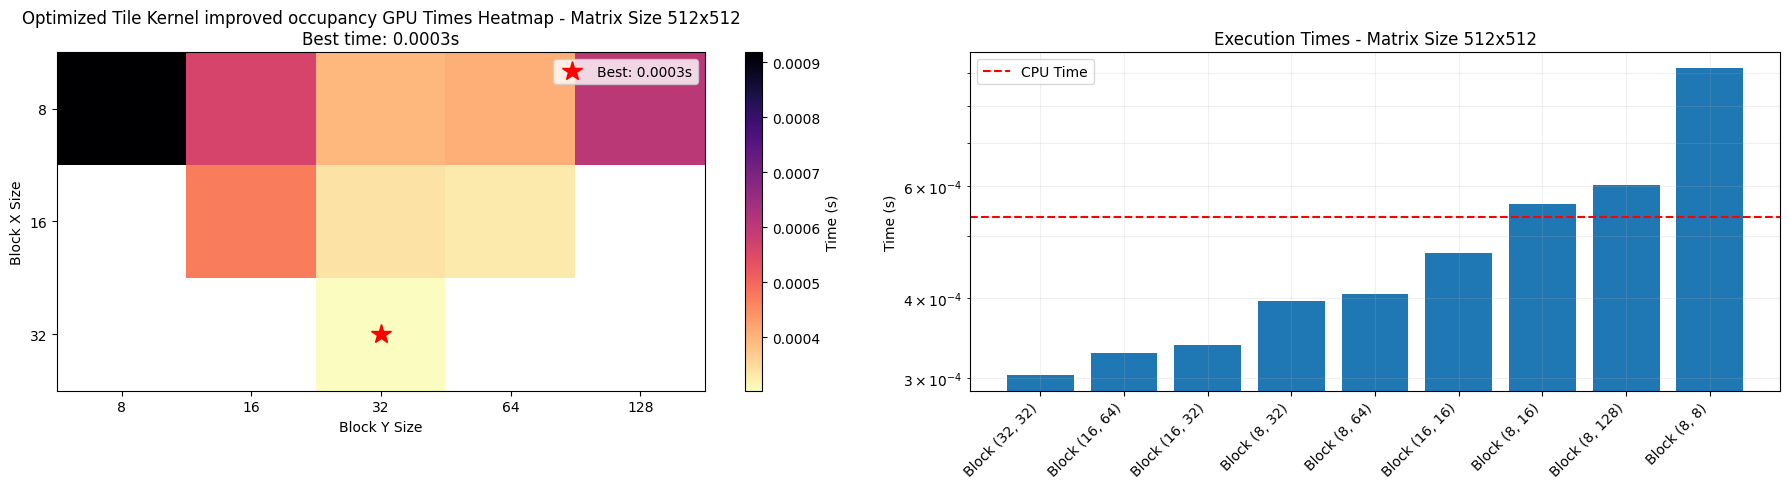

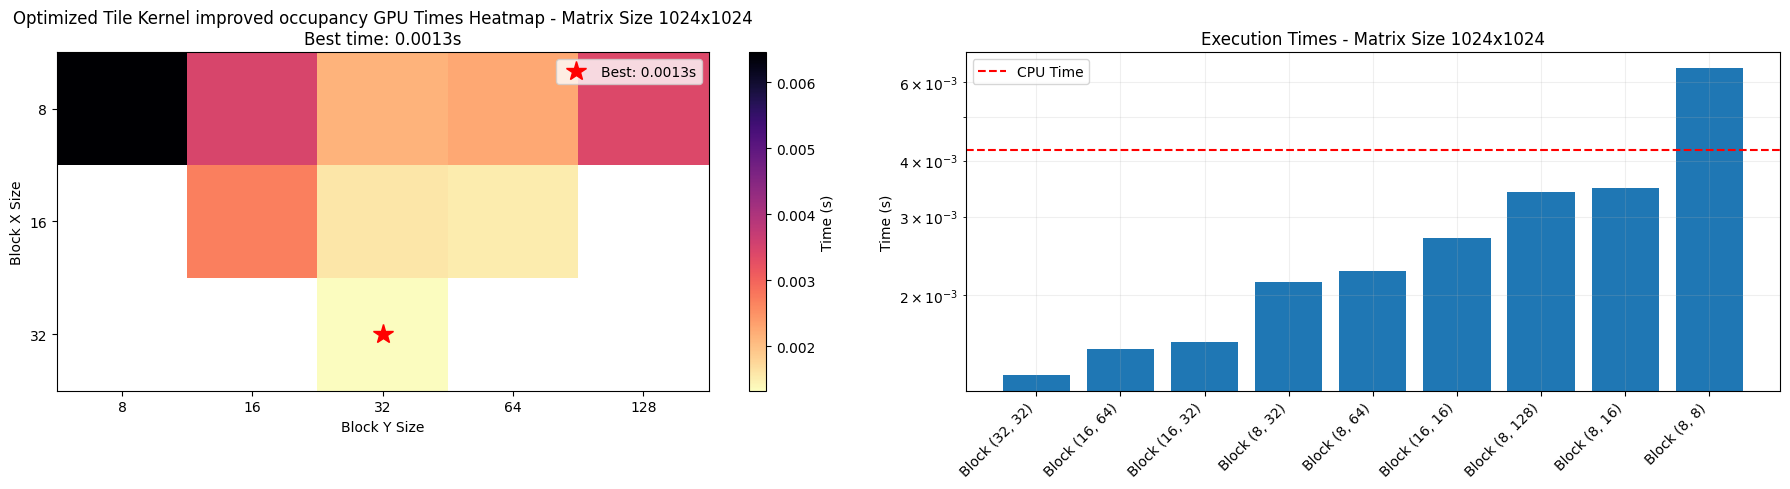

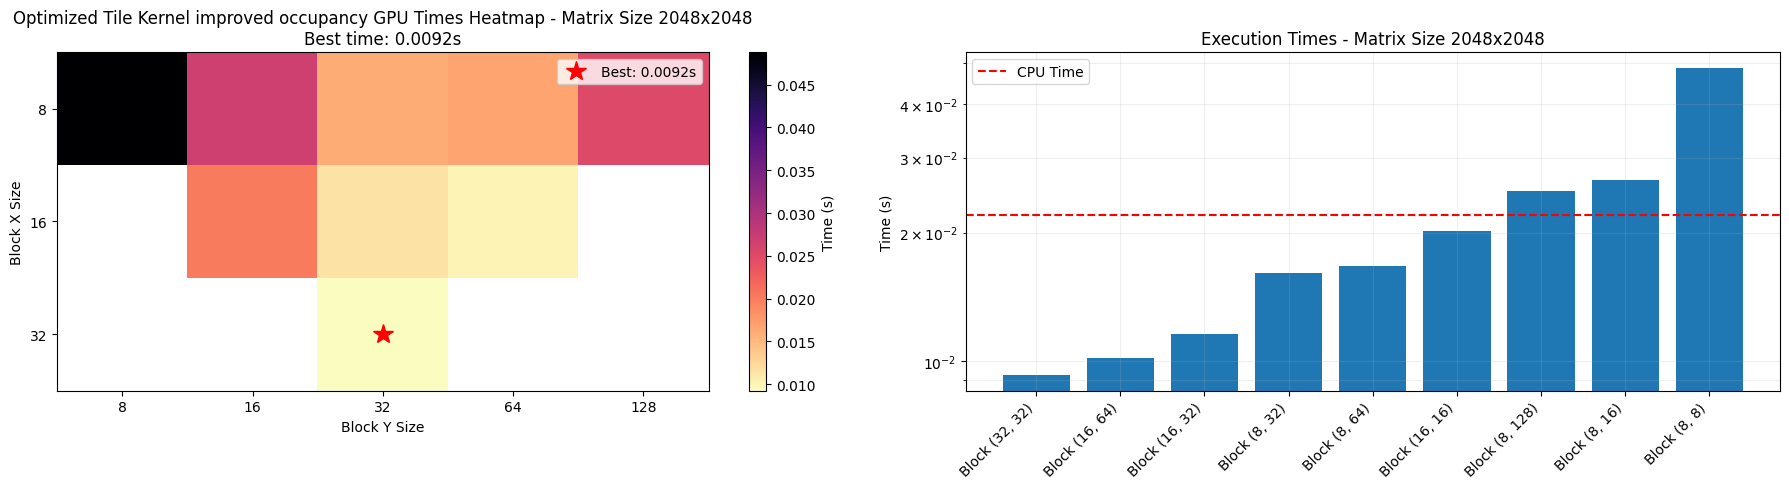

In [28]:
plot_results(results_tile_v2, 'Optimized Tile Kernel improved occupancy')

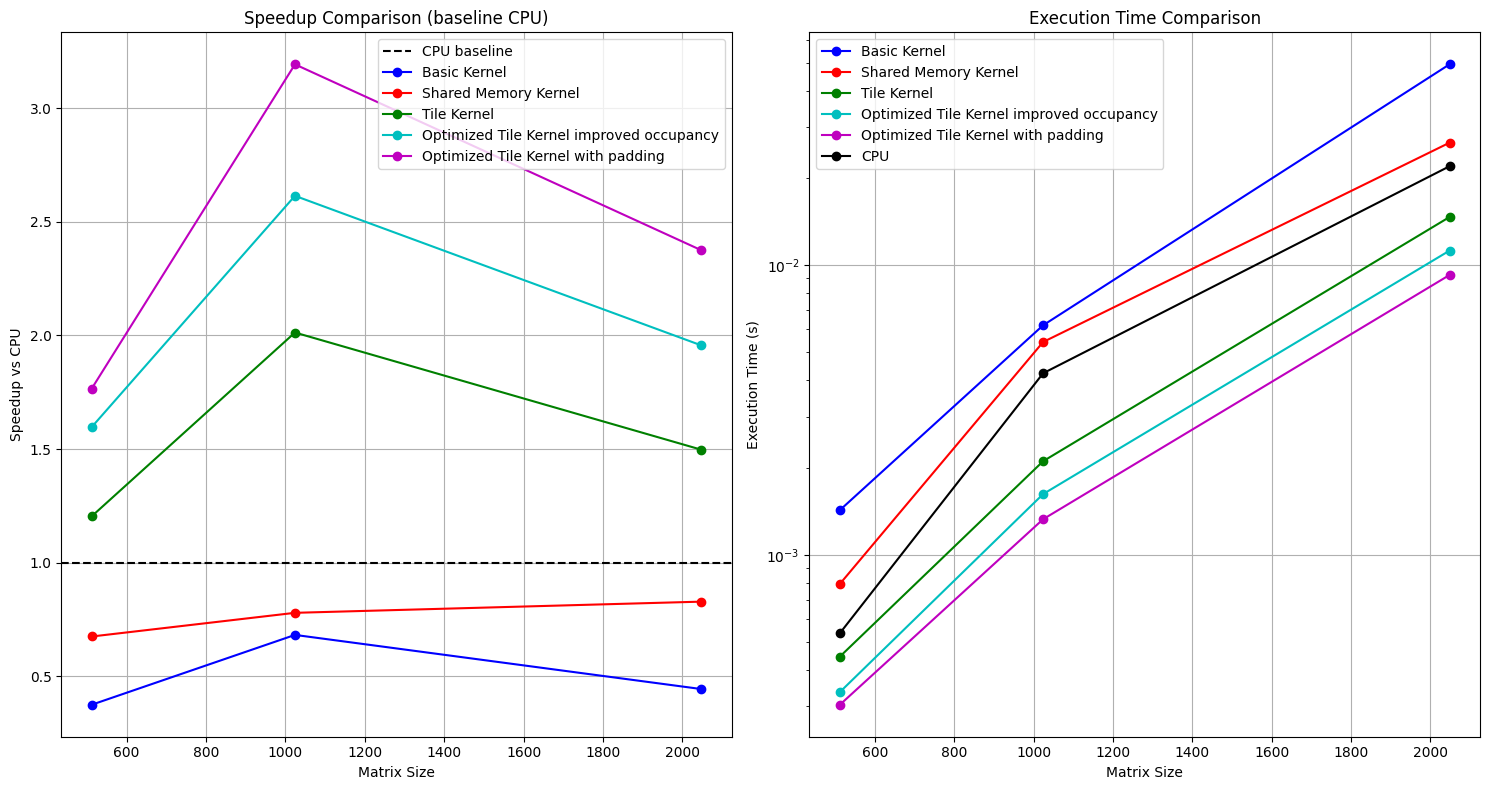


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Tile Kernel Time | Optimized Tile Kernel improved occupancy Time | Optimized Tile Kernel with padding Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0014    |    0.0008    |    0.0004    |    0.0003    |    0.0003    | (32, 32)
    1024     |    0.0062    |    0.0054    |    0.0021    |    0.0016    |    0.0013    | (32, 32)
    2048     |    0.0494    |    0.0265    |    0.0147    |    0.0112    |    0.0092    | (32, 32)


In [29]:
best_times_tile_padded = {}
for N in matrix_sizes:
    optimized_padded = [r for r in results_tile_v2 if r['matrix_size'] == N]
    best_times_tile_padded[N] = min(optimized_padded, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_reuse, best_times_tile_v1, best_times_tile_padded], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Tile Kernel', 'Optimized Tile Kernel improved occupancy', 'Optimized Tile Kernel with padding'],
                      matrix_sizes) 

The results speak for themselves. 

According to the profile the execution on 2048x2048 is now down to <7ms!

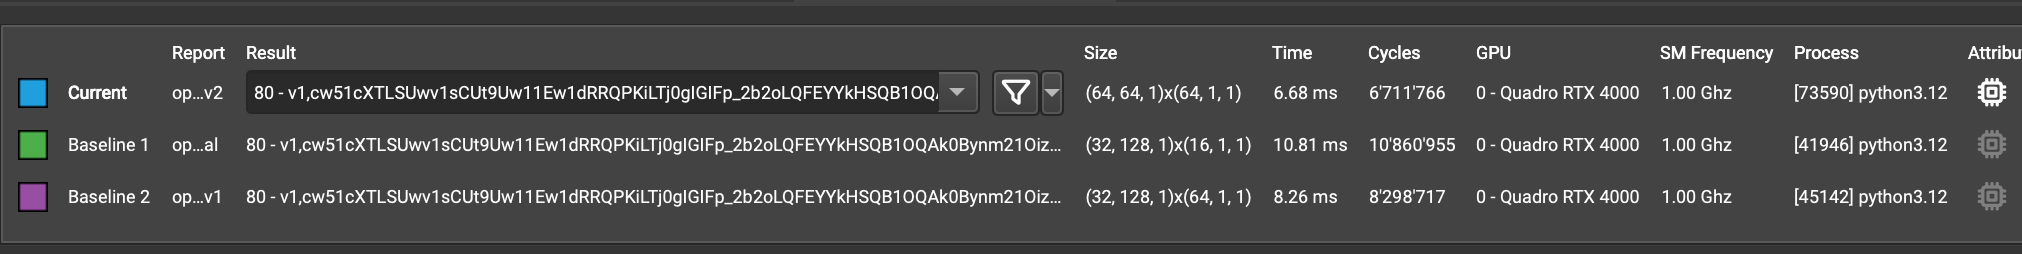


Taking a closer look at all the profiles now I noticed some interesting things.

Some basic remarks:

Blue: Padded Tile Kernel
Pink/Purple: Improved Occupancy Tile Kernel
Green: Basic Kernel

All kernels were ran with their fastest block size config, based on the implementation in this notebook.


Even though it is the fastest based on profiling, the overall Compute of the GPU is the lowest out of the three.

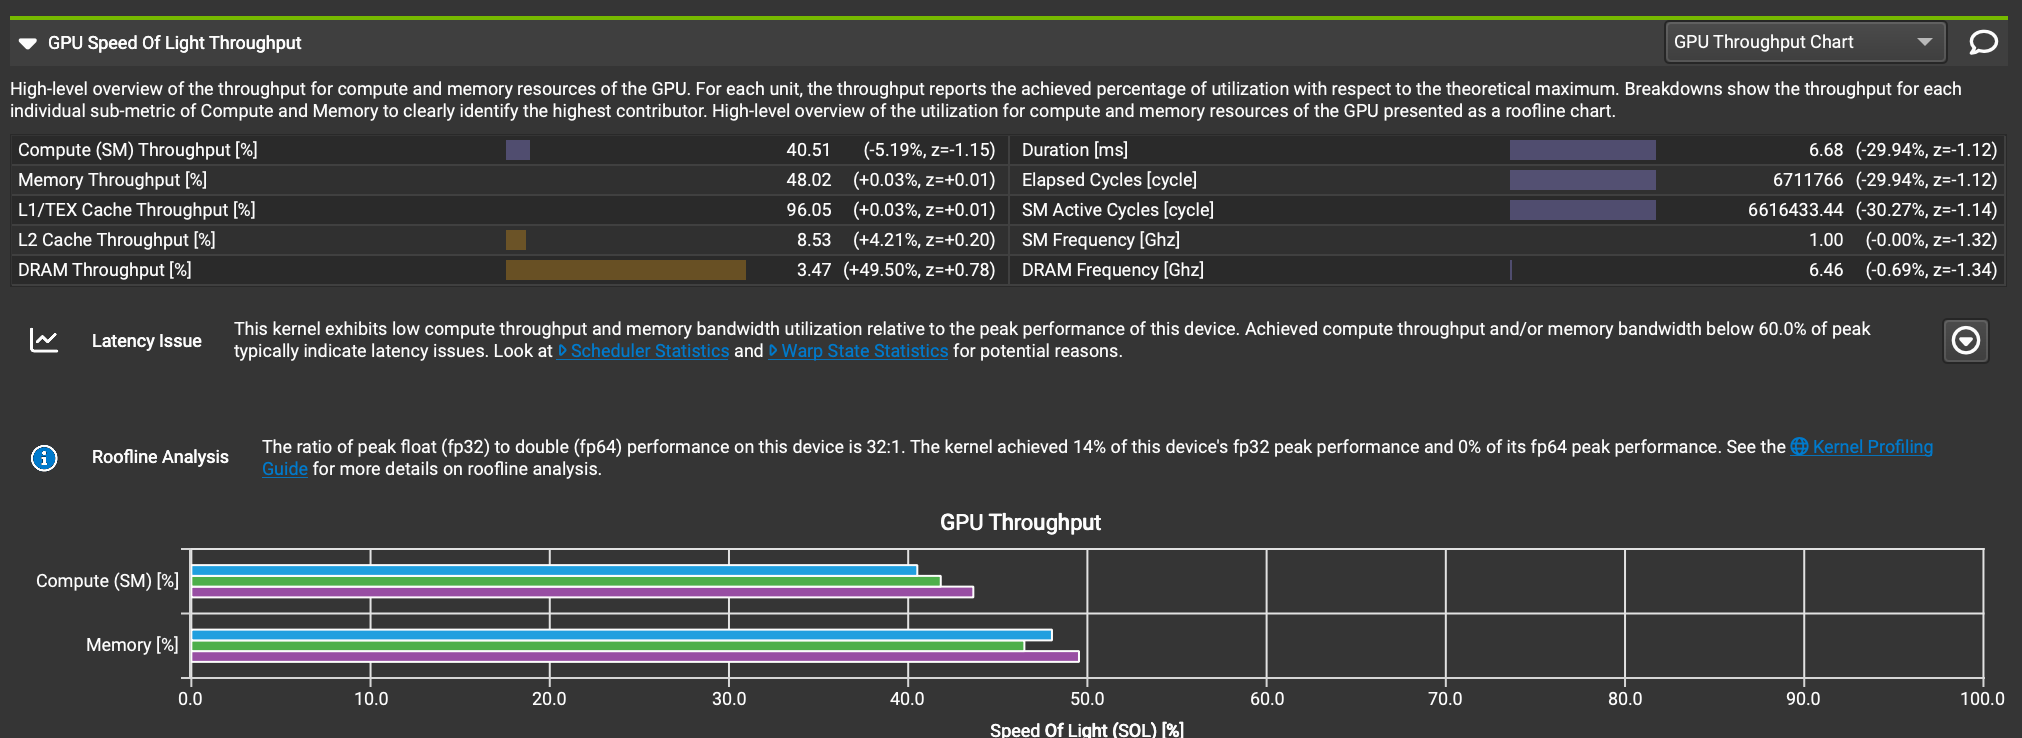


Taking a closer at the occupancy I noticed that there is still room for improvement.

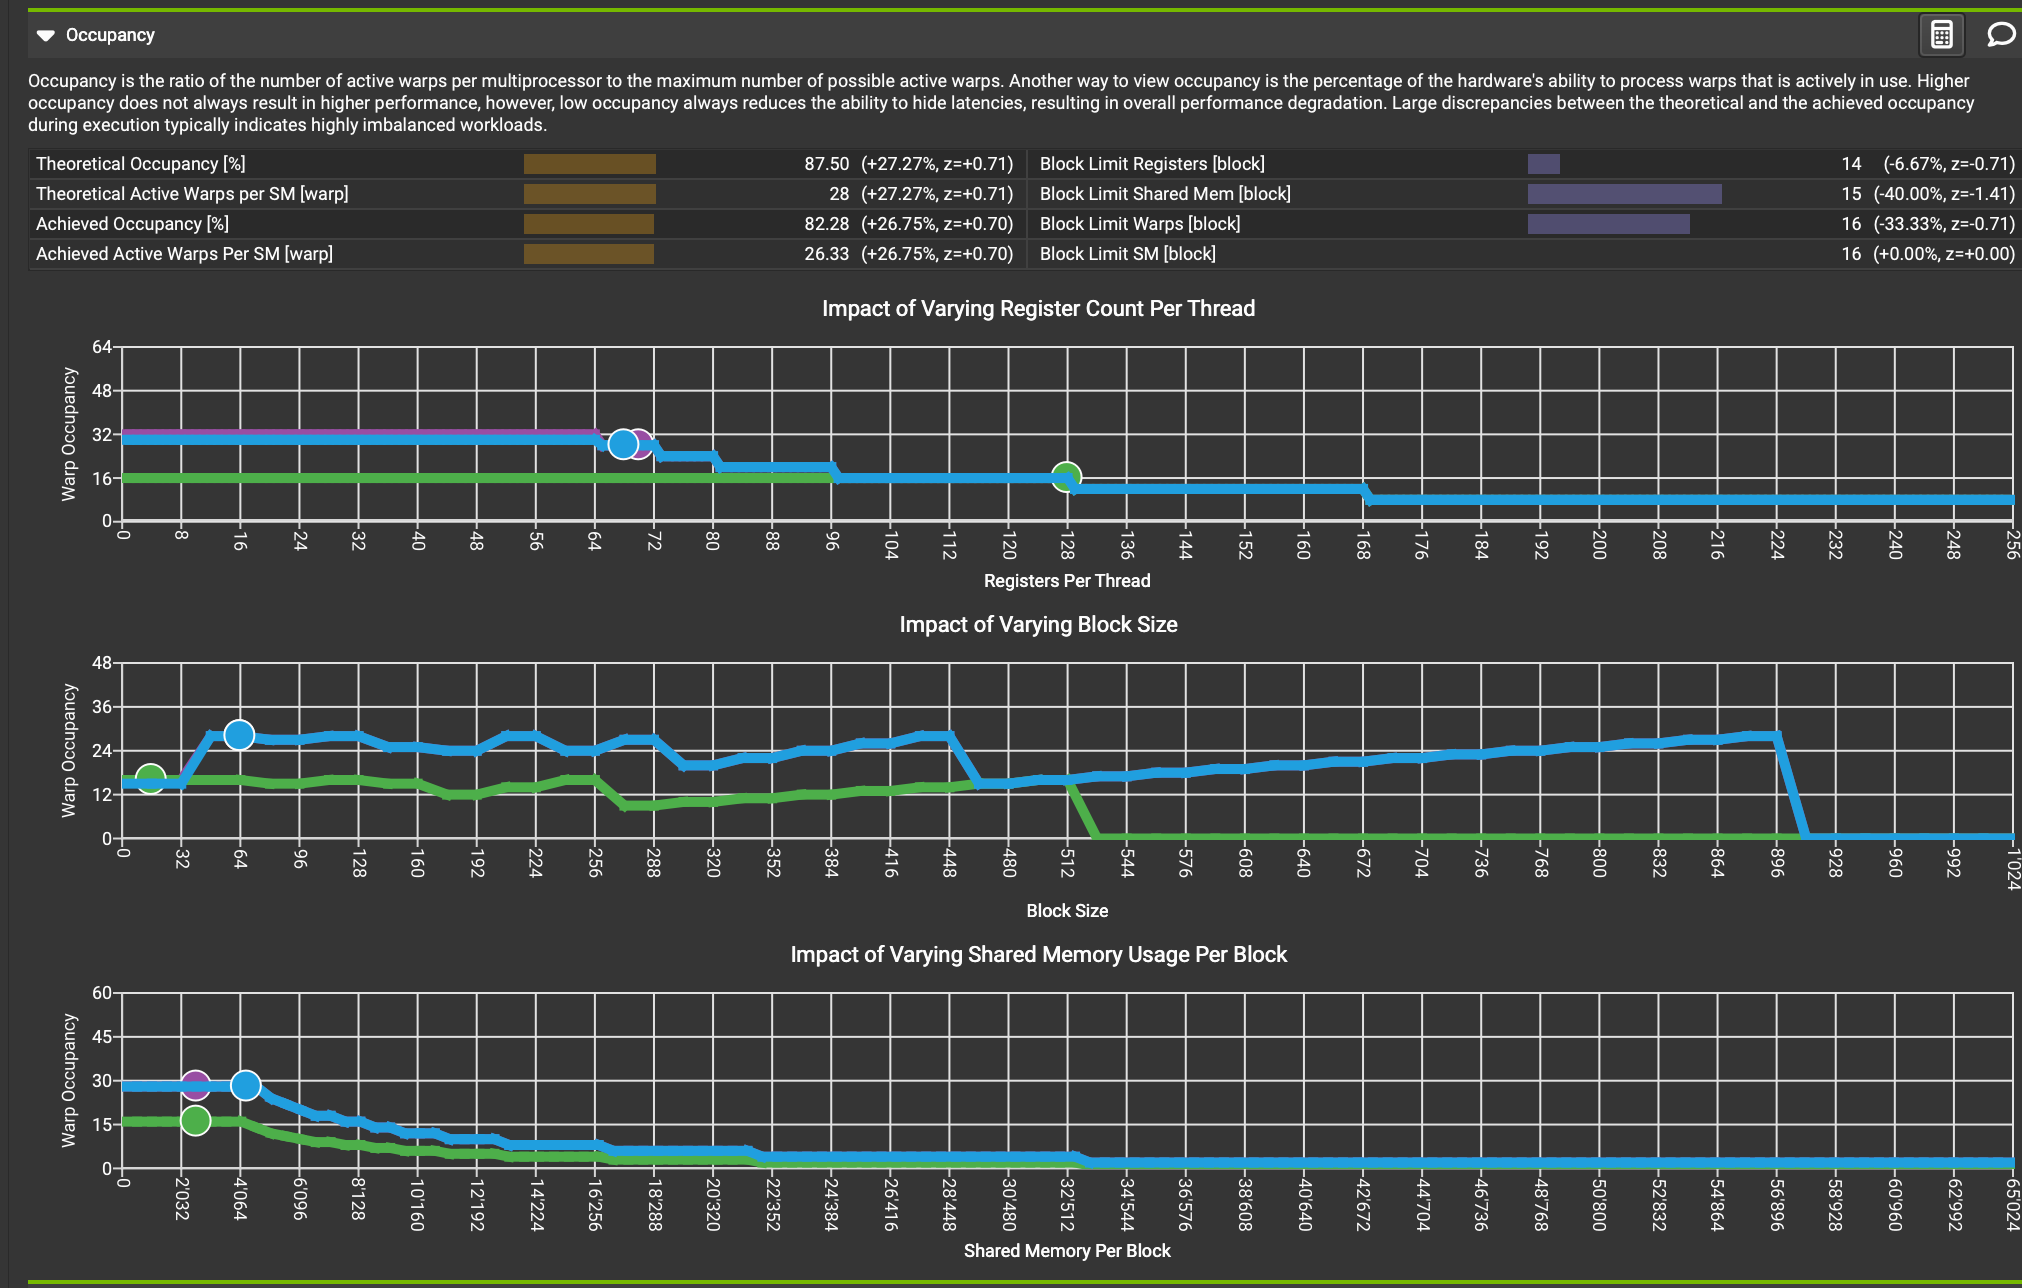

The warp occupancy could be higher, by reducing register per thread. However I wasn't able to find a way to do this without sacrificing time elsewhere.

Furthermore I see that the access pattern of the global memory is not optimal. 

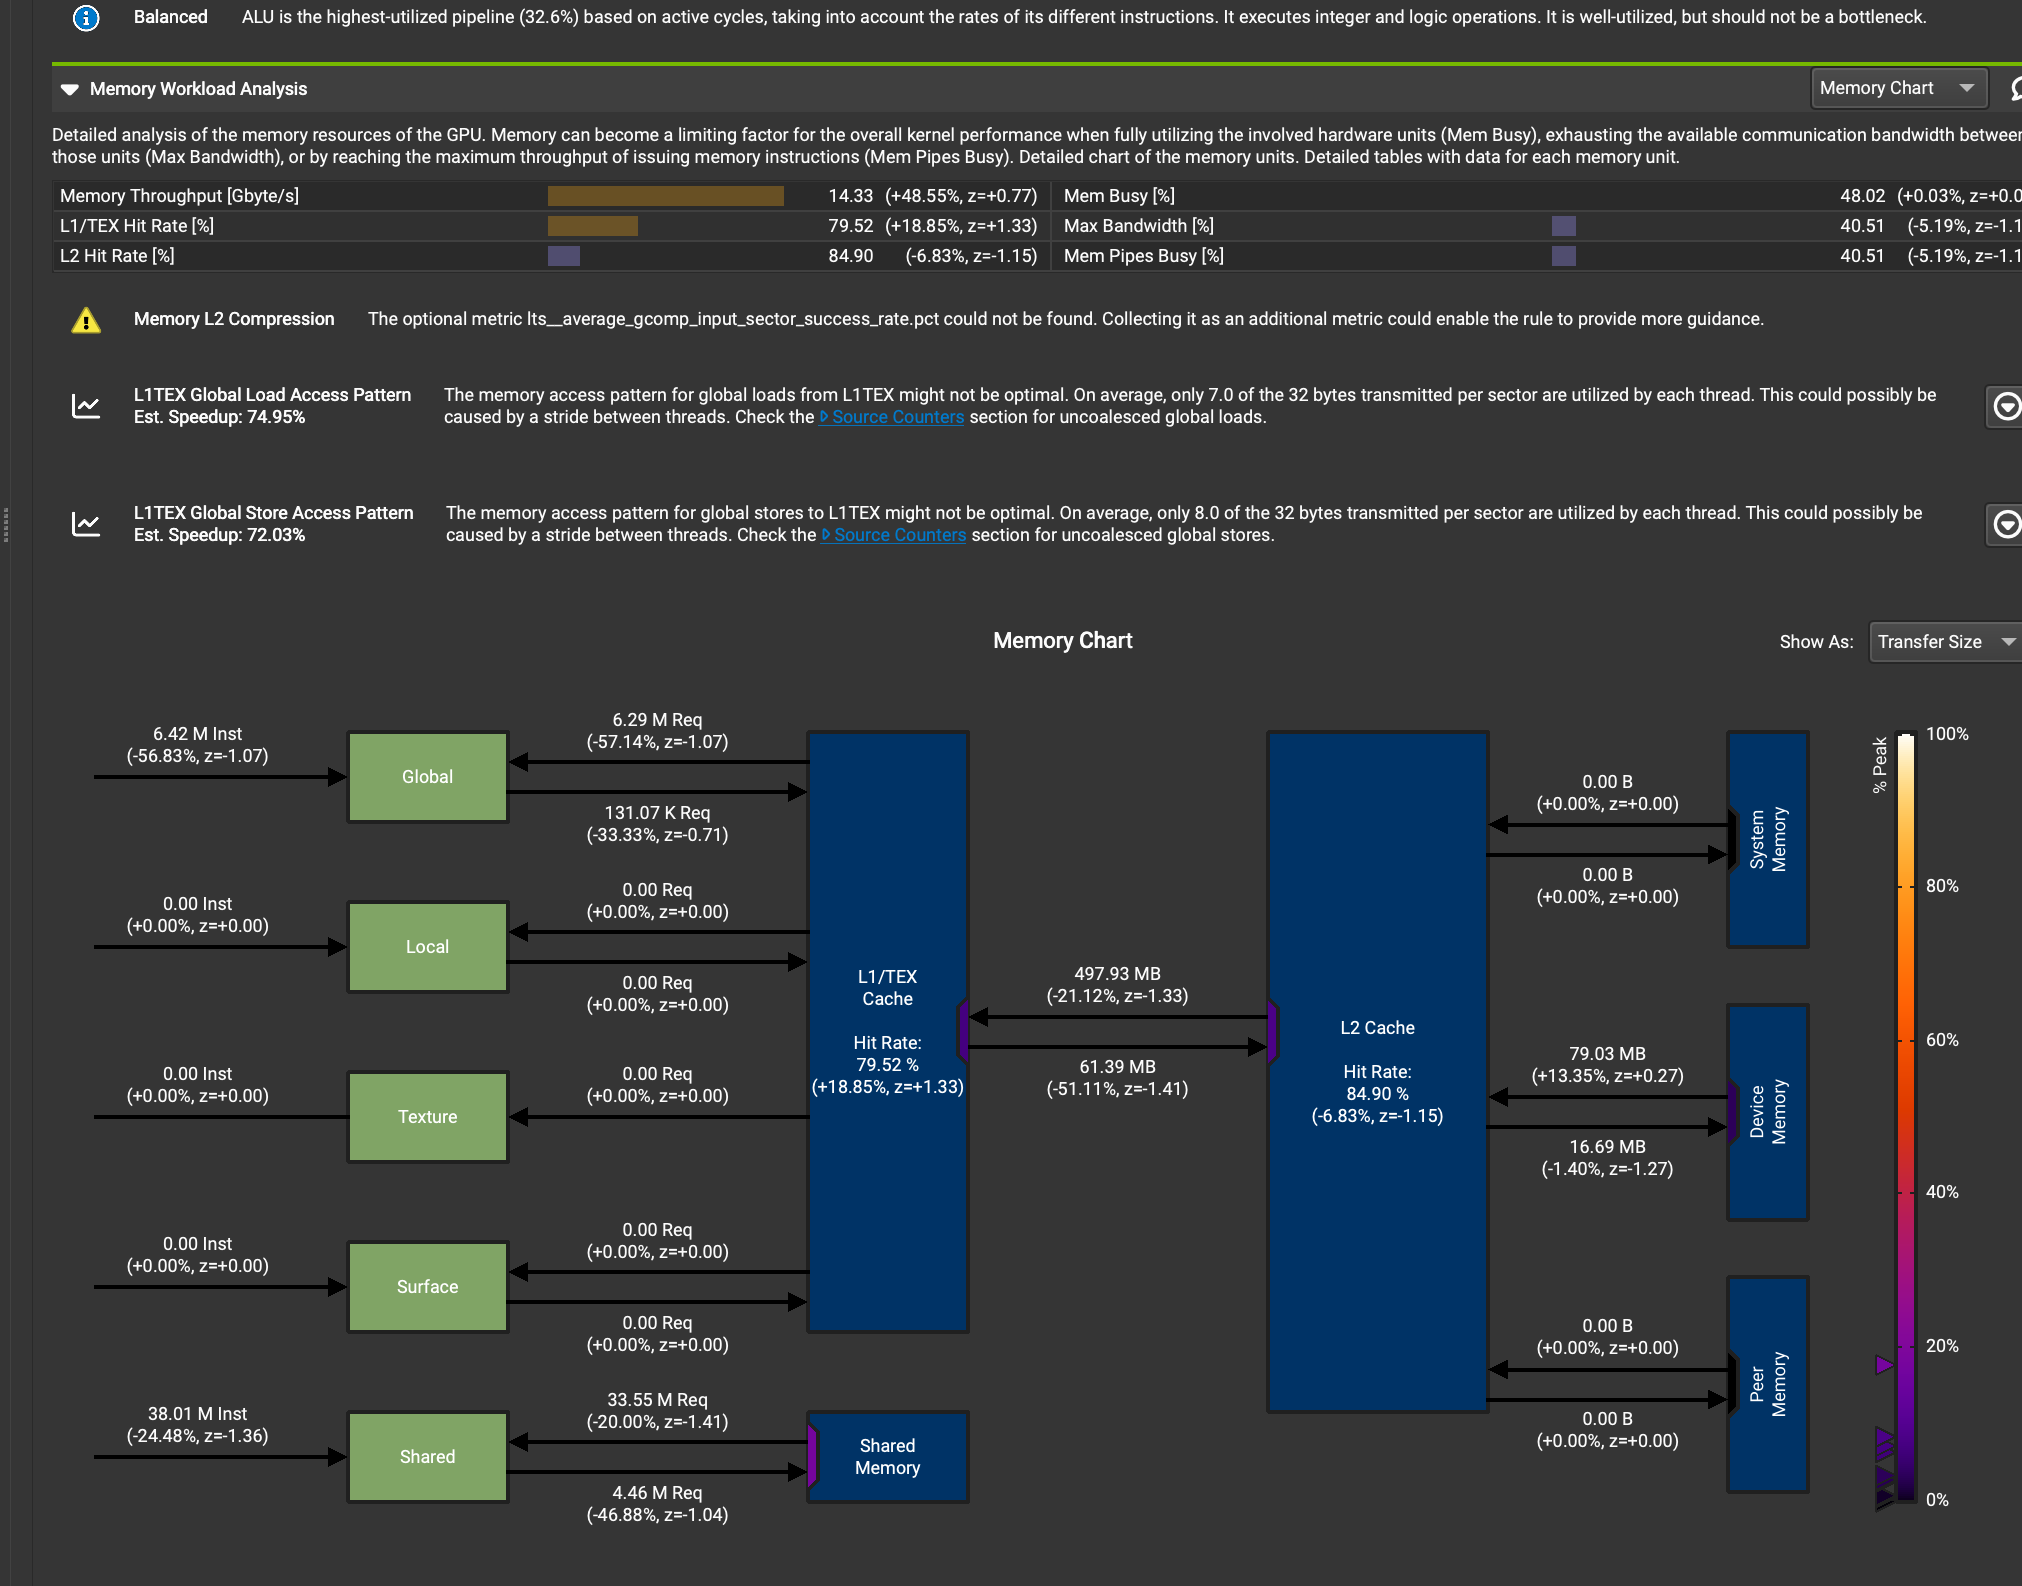


I tried to make it work with coalescing but didn't manage to do so. 

Now the final boss, my fastest implementation vs CuPy's broadcast implementation.

In [30]:
results_cp_broadcast = []
for N in matrix_sizes:
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']
     
    # move to cupy device
    u_device = cp.asarray(u, dtype=cp.float32)
    s_device = cp.asarray(s, dtype=cp.float32)
    vt_device = cp.asarray(vt, dtype=cp.float32)
    
    # allocate device memory
    C_device = cp.empty((N, N), dtype=cp.float32)
    
    # event with cupy 
    start_event = cp.cuda.Event()
    stop_event = cp.cuda.Event()
    
    start_event.record()
    reconstruct_svd_cp_broadcast(u_device, s_device, vt_device, k)
    cuda.synchronize()
    stop_event.record()
    
    gpu_time_ms = cp.cuda.get_elapsed_time(start_event, stop_event)
    gpu_time = gpu_time_ms / 1000
    
    
    speedup = svd_components[N]['cpu_time'] / gpu_time
    
    results_cp_broadcast.append({
        'matrix_size': N,
        'cpu_time': svd_components[N]['cpu_time'],
        'gpu_time': gpu_time,
        'speedup': speedup,
        'block_size': '',
    })
    

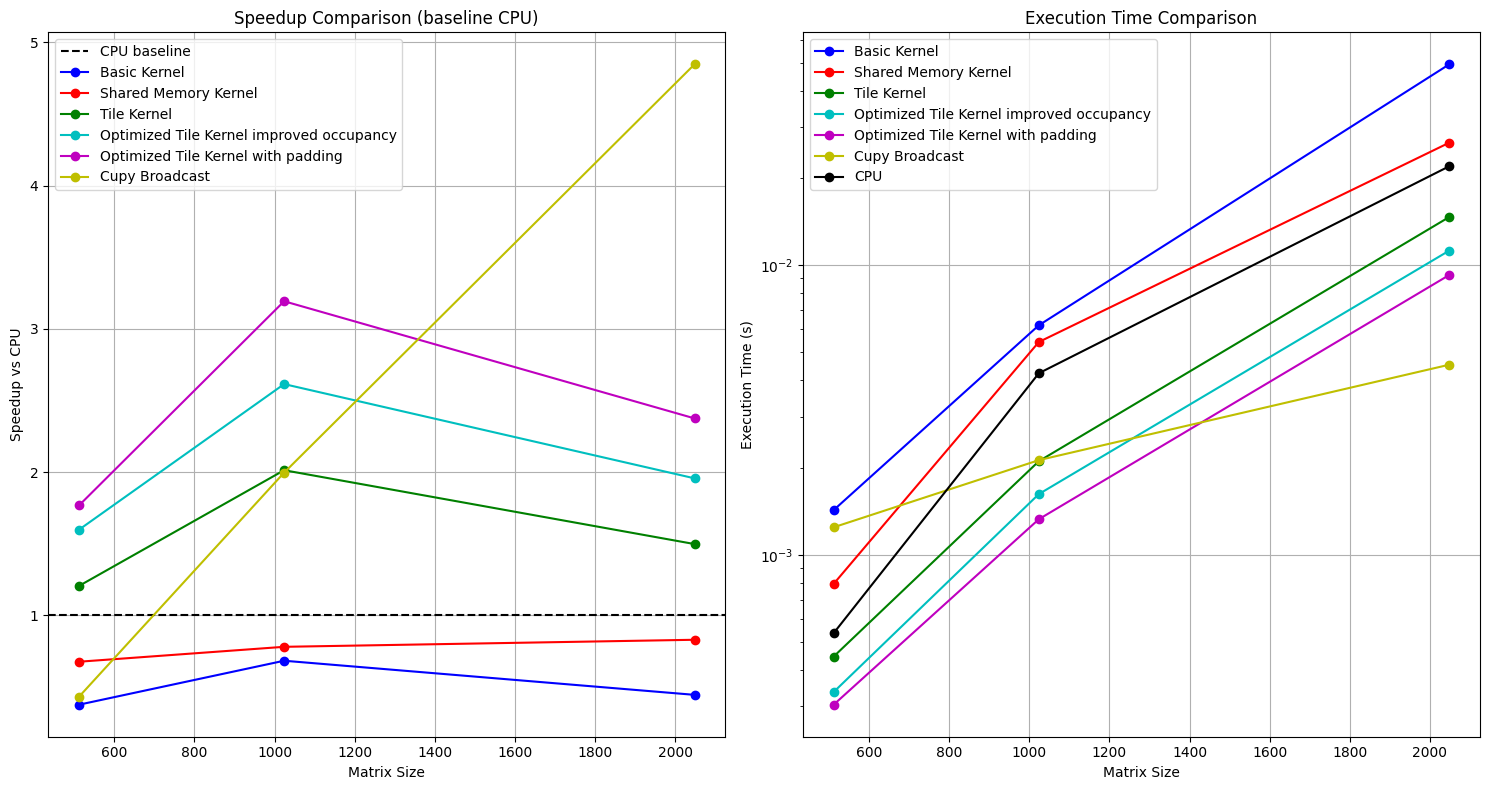


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Tile Kernel Time | Optimized Tile Kernel improved occupancy Time | Optimized Tile Kernel with padding Time | Cupy Broadcast Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0014    |    0.0008    |    0.0004    |    0.0003    |    0.0003    |    0.0012    | 
    1024     |    0.0062    |    0.0054    |    0.0021    |    0.0016    |    0.0013    |    0.0021    | 
    2048     |    0.0494    |    0.0265    |    0.0147    |    0.0112    |    0.0092    |    0.0045    | 


In [31]:
best_times_cp_broadcast = {}
for N in matrix_sizes:
    optimized_cp_broadcast = [r for r in results_cp_broadcast if r['matrix_size'] == N]
    best_times_cp_broadcast[N] = min(optimized_cp_broadcast, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_reuse, best_times_tile_v1, best_times_tile_padded, best_times_cp_broadcast], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Tile Kernel', 'Optimized Tile Kernel improved occupancy', 'Optimized Tile Kernel with padding', 'Cupy Broadcast'], matrix_sizes)

<font color='blue'>

I consider this a win. 

Comparing my implementation with the cupy implementation, I can still see that CuPy scales a lot better, but nonetheless for 1024x1024 my implementations still undercut the cupy implementation.

The final implemntation hits <10ms reconstruction times on 2048x2048 images which was my goal all along.
</font>

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Untersuche dies auch für grössere Inputs als die MRI-Bilder.

In [32]:
%%writefile profile_multiple.py
import math
import time
import threading
from queue import Queue, Empty
from dataclasses import dataclass
from typing import List, Dict
import logging

import numpy as np
from argparse import ArgumentParser
from numba import cuda, float32
from numpy.linalg import svd

# --- Configuration ---
LOG_LEVEL = logging.INFO
BLOCK_SIZE_X, BLOCK_SIZE_Y = 32, 32
TOTAL_IMAGES = 10000
IMG_SIZE = 1024
NUM_WORKERS = 4
NUM_STREAMS = 4 
IMG = np.random.rand(IMG_SIZE, IMG_SIZE).astype(np.float32)

logging.basicConfig(
    level=LOG_LEVEL,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logging.getLogger("numba.cuda.cudadrv.driver").setLevel(logging.ERROR)
logger = logging.getLogger(__name__)

BM = int(BLOCK_SIZE_X)
BN = int(BLOCK_SIZE_Y)
TM = BM // 8  # => 2
TN = BN // 8  # => 8
BK = int(BM / 2)

# Extra columns for padding
BKpad = BK + 1  # 8 + 1 = 9
BNpad = BN + 1  # 64 + 1 = 65

@cuda.jit(fastmath=True)
def svd_reconstruct_tiled_padded(U, S, Vt, out, M, N, K):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    tx = cuda.threadIdx.x

    threads_per_block = (BM * BN) // (TM * TN)
    if threads_per_block != cuda.blockDim.x:
        return

    # 2D sub-block indexing
    threadRow = tx // (BN // TN)  # => tx // 8
    threadCol = tx %  (BN // TN)  # => tx % 8

    row_start = by * BM
    col_start = bx * BN

    # Allocate padded shared arrays:
    # - We'll store up to [BM, BK], leaving the last col as padding
    U_shared  = cuda.shared.array((BM, BKpad), dtype=float32)
    # - We'll store up to [BK, BN], leaving the last col in BN for padding
    Vt_shared = cuda.shared.array((BK, BNpad), dtype=float32)

    # local accumulation
    result = cuda.local.array((TM, TN), dtype=float32)
    for i in range(TM):
        for j in range(TN):
            result[i, j] = 0.0

    # Tiling over the K dimension in increments of BK
    for k_tile in range(0, K, BK):
        # Load BM rows from U
        load_x = tx
        while load_x < BM:
            for kk in range(BK):
                real_k = k_tile + kk
                if real_k < K and (row_start + load_x) < M:
                    U_shared[load_x, kk] = U[row_start + load_x, real_k]
                else:
                    U_shared[load_x, kk] = 0.0
            # For the padded column
            U_shared[load_x, BK] = 0.0
            load_x += threads_per_block

        # Load BN columns from Vt
        load_y = tx
        while load_y < BN:
            for kk in range(BK):
                real_k = k_tile + kk
                if real_k < K and (col_start + load_y) < N:
                    Vt_shared[kk, load_y] = Vt[real_k, col_start + load_y] * S[real_k]
                else:
                    Vt_shared[kk, load_y] = 0.0
            # For the padded column
            # Actually we have BN+1, so let's null it out:
            Vt_shared[kk, BN] = 0.0
            load_y += threads_per_block

        cuda.syncthreads()

        # Dot product
        for dotIdx in range(BK):
            for i in range(TM):
                rowA = threadRow * TM + i
                aVal = U_shared[rowA, dotIdx]
                for j in range(TN):
                    colB = threadCol * TN + j
                    result[i, j] += aVal * Vt_shared[dotIdx, colB]

        cuda.syncthreads()

    # Store partial results
    for i in range(TM):
        out_row = row_start + threadRow*TM + i
        if out_row < M:
            for j in range(TN):
                out_col = col_start + threadCol*TN + j
                if out_col < N:
                    out[out_row, out_col] = result[i, j]


@dataclass
class WorkerResource:
    """
    One CPU worker controlling multiple CUDA streams. We store references
    to device memory and pinned host memory for each stream.
    """
    streams: List[cuda.stream]
    device_bufs: List[Dict[str, cuda.devicearray.DeviceNDArray]]
    host_bufs: List[Dict[str, np.ndarray]]


class Reconstructor:

    def __init__(self, shape_info: tuple):
        self.work_queue = Queue()
        self.shutdown_event = threading.Event()
        self.worker_threads: List[threading.Thread] = []

        self.num_workers = NUM_WORKERS
        self.num_streams = NUM_STREAMS
        self.worker_resources: List[WorkerResource] = []

        for worker_id in range(self.num_workers):
            logger.info(f"Allocating GPU resources for worker {worker_id}")
            resources = self._init_resources(shape_info)
            self.worker_resources.append(resources)

    def _init_resources(self, shape_info: tuple) -> WorkerResource:
        M, N, K = shape_info
        streams = []
        device_bufs = []
        host_bufs = []

        for _ in range(self.num_streams):
            streams.append(cuda.stream())
            device_dict = {
                "U": cuda.device_array((M, K), dtype=np.float32),
                "S": cuda.device_array((K,), dtype=np.float32),
                "V": cuda.device_array((K, N), dtype=np.float32),
                "C": cuda.device_array((M, N), dtype=np.float32),
            }
            host_dict = {
                "U": cuda.pinned_array((M, K), dtype=np.float32),
                "S": cuda.pinned_array((K,), dtype=np.float32),
                "V": cuda.pinned_array((K, N), dtype=np.float32),
                "C": cuda.pinned_array((M, N), dtype=np.float32),
            }
            device_bufs.append(device_dict)
            host_bufs.append(host_dict)

        return WorkerResource(streams, device_bufs, host_bufs)

    def _gpu_worker(self, worker_id: int, shape_info: tuple):
        """
        Worker thread: picks tasks from the queue, launches GPU ops, stores final data in pinned memory.
        """
        M, N, K = shape_info
        resources = self.worker_resources[worker_id]

        def on_gpu_complete(stream, status, arg):
            """
            Called after GPU completes. arg is (task_id, slot_id).
            We won't do disk saving here, only log final results if needed.
            """
            task_id, slot_id = arg
            # Data is already in resources.host_bufs[slot_id]["C"].
            logger.debug(f"[Worker {worker_id}] Task {task_id} finished on slot {slot_id}.")

        counter = 0
        logger.info(f"[Worker {worker_id}] started")
        try:
            while not self.shutdown_event.is_set():
                try:
                    task_id, decomp = self.work_queue.get(timeout=1.0)
                except Empty:
                    continue

                slot_id = counter % self.num_streams
                counter += 1

                stream = resources.streams[slot_id]
                dev = resources.device_bufs[slot_id]
                host = resources.host_bufs[slot_id]

                # Copy decomposition to pinned memory
                host["U"][:] = decomp["u"]
                host["S"][:] = decomp["s"]
                host["V"][:] = decomp["v"]

                # Transfer pinned -> device
                cuda.to_device(host["U"], to=dev["U"], stream=stream)
                cuda.to_device(host["S"], to=dev["S"], stream=stream)
                cuda.to_device(host["V"], to=dev["V"], stream=stream)

                M, _ = host["U"].shape
                _, N = host["V"].shape

                blocks_x = math.ceil(N / BN)
                blocks_y = math.ceil(M / BM)
                
                threads_per_block = (BM * BN) // (BM / 8 * BN / 8)   # = (16*16)/(4) = 4

                grid_dim = (blocks_x, blocks_y)
                block_dim = (int(threads_per_block),)

                svd_reconstruct_tiled_padded[grid_dim, block_dim, stream](dev["U"], dev["S"], dev["V"], dev["C"], M, N, K)

                dev["C"].copy_to_host(host["C"], stream=stream)

                # Callback so we know when GPU work is truly done
                stream.add_callback(on_gpu_complete, (task_id, slot_id))

                self.work_queue.task_done()
                logger.debug(f"[Worker {worker_id}] launched task {task_id} on slot {slot_id}")
        except Exception as e:
            logger.error(f"[Worker {worker_id}] error: {str(e)}", exc_info=True)
        finally:
            logger.info(f"[Worker {worker_id}] shutting down...")
            for st in resources.streams:
                st.synchronize()
            logger.info(f"[Worker {worker_id}] all streams done.")

    def start_workers(self, shape_info: tuple):
        """
        Start worker threads. Each worker does GPU tasks for multiple streams.
        """
        for w_id in range(self.num_workers):
            th = threading.Thread(target=self._gpu_worker, args=(w_id, shape_info))
            th.start()
            self.worker_threads.append(th)

    def enqueue_task(self, decomp: Dict, task_id: int):
        """
        Enqueue a GPU reconstruction task (a dict with 'u', 's', 'v').
        """
        self.work_queue.put((task_id, decomp))

    def stop(self):
        """
        Signal worker(s) to stop and wait for them to finish.
        """
        logger.info("Stop requested. Shutting down workers...")
        self.shutdown_event.set()
        self.work_queue.join()

        for th in self.worker_threads:
            th.join()
        logger.info("All workers shut down successfully.")


def main():
    parser = ArgumentParser()
    parser.add_argument("--sequential", action="store_true", help="Optional: run single-thread GPU approach.")
    args = parser.parse_args()
    logger.info(f"sequential={args.sequential}")

    # For demonstration, do a single CPU SVD of the random image
    u_mat, s_vec, vt_mat = svd(IMG, full_matrices=False)
    M, K = u_mat.shape
    K2, N = vt_mat.shape
    if K2 != K:
        raise ValueError("Mismatch in SVD shapes.")

    shape_info = (M, N, K)
    example_decomp = {"u": u_mat, "s": s_vec, "v": vt_mat}

    if args.sequential:
        logger.info("Running single-stream, no concurrency approach...")
        U_host = cuda.pinned_array((M, K), dtype=np.float32)
        S_host = cuda.pinned_array((K,),   dtype=np.float32)
        V_host = cuda.pinned_array((K, N), dtype=np.float32)
        C_host = cuda.pinned_array((M, N), dtype=np.float32)
        
        U_host[:] = example_decomp["u"]
        S_host[:] = example_decomp["s"]
        V_host[:] = example_decomp["v"]


        start_t = time.time()
        for i in range(TOTAL_IMAGES):
            # Allocate pinned arrays here (or reuse them)

            # Copy to device
            U_dev = cuda.to_device(U_host)
            S_dev = cuda.to_device(S_host)
            V_dev = cuda.to_device(V_host)
            C_dev = cuda.device_array((M, N), dtype=np.float32)

            M, _ = U_host.shape
            _, N = V_host.shape

            blocks_x = math.ceil(N / BN)
            blocks_y = math.ceil(M / BM)
            
            threads_per_block = (BM * BN) // (BM / 8 * BN / 8)

            grid_dim = (blocks_x, blocks_y)
            block_dim = (int(threads_per_block),)

            svd_reconstruct_tiled_padded[grid_dim, block_dim](U_dev, S_dev, V_dev, C_dev, M, N, K)

            C_dev.copy_to_host(C_host)

        cuda.synchronize()
        elapsed = time.time() - start_t
        logger.info(f"Sequential run took {elapsed:.2f}s => {TOTAL_IMAGES / elapsed:.2f} images/s")
        return

    # Concurrency approach
    start_t = time.time()
    manager = Reconstructor(shape_info)
    manager.start_workers(shape_info)

    # Enqueue tasks
    for i in range(TOTAL_IMAGES):
        manager.enqueue_task(example_decomp, i)

    # Wait for tasks, then stop
    manager.work_queue.join()
    manager.stop()

    end_t = time.time()
    total_time = end_t - start_t
    logger.info(f"Concurrent GPU run: {total_time:.2f}s => {TOTAL_IMAGES / total_time:.2f} images/s")


if __name__ == "__main__":
    main()

Overwriting profile_multiple.py


In [33]:
!.venv/bin/python  profile_multiple.py 

2025-01-15 17:53:41,201 - __main__ - INFO - sequential=False
2025-01-15 17:53:42,283 - __main__ - INFO - Allocating GPU resources for worker 0
2025-01-15 17:53:42,680 - __main__ - INFO - Allocating GPU resources for worker 1
2025-01-15 17:53:42,718 - __main__ - INFO - Allocating GPU resources for worker 2
2025-01-15 17:53:42,754 - __main__ - INFO - Allocating GPU resources for worker 3
2025-01-15 17:53:42,788 - __main__ - INFO - [Worker 0] started
2025-01-15 17:53:42,789 - __main__ - INFO - [Worker 1] started
2025-01-15 17:53:42,789 - __main__ - INFO - [Worker 2] started
2025-01-15 17:53:42,790 - __main__ - INFO - [Worker 3] started
2025-01-15 17:54:09,371 - __main__ - INFO - Stop requested. Shutting down workers...
2025-01-15 17:54:10,370 - __main__ - INFO - [Worker 0] shutting down...
2025-01-15 17:54:10,370 - __main__ - INFO - [Worker 3] shutting down...
2025-01-15 17:54:10,370 - __main__ - INFO - [Worker 0] all streams done.
2025-01-15 17:54:10,371 - __main__ - INFO - [Worker 1] sh

In [34]:
# due to overhead of nsys slower than above, but that is not surprising
!sudo nsys profile -o profiles/multiple_profile --trace=cuda,osrt,nvtx --cuda-memory-usage=true --force-overwrite=true --gpu-metrics-device=all .venv/bin/python  profile_multiple.py 

GPU 0: General Metrics for NVIDIA TU10x (any frequency)
2025-01-15 17:54:14,493 - __main__ - INFO - sequential=False
2025-01-15 17:54:15,348 - __main__ - INFO - Allocating GPU resources for worker 0
2025-01-15 17:54:16,270 - __main__ - INFO - Allocating GPU resources for worker 1
2025-01-15 17:54:16,310 - __main__ - INFO - Allocating GPU resources for worker 2
2025-01-15 17:54:16,349 - __main__ - INFO - Allocating GPU resources for worker 3
2025-01-15 17:54:16,388 - __main__ - INFO - [Worker 0] started
2025-01-15 17:54:16,390 - __main__ - INFO - [Worker 1] started
2025-01-15 17:54:16,391 - __main__ - INFO - [Worker 2] started
2025-01-15 17:54:16,392 - __main__ - INFO - [Worker 3] started
2025-01-15 17:54:50,295 - __main__ - INFO - Stop requested. Shutting down workers...
2025-01-15 17:54:51,290 - __main__ - INFO - [Worker 0] shutting down...
2025-01-15 17:54:51,291 - __main__ - INFO - [Worker 0] all streams done.
2025-01-15 17:54:51,293 - __main__ - INFO - [Worker 1] shutting down...
2

In [35]:
!.venv/bin/python  profile_multiple.py --sequential

2025-01-15 17:55:26,360 - __main__ - INFO - sequential=True
2025-01-15 17:55:27,624 - __main__ - INFO - Running single-stream, no concurrency approach...
2025-01-15 17:56:19,794 - __main__ - INFO - Sequential run took 51.78s => 193.13 images/s


<font color='blue'>

The above code is a setup for concurrent GPU execution of multiple images with an optional sequential mode (without streams).

Looking at the nsys profile (profile/multiple_profile.nsys-rep)

We can see that the overlap of not only memory but also the kernel execution is clearly visible.

This means that the GPU is not idle while waiting for the memory transfer to complete and is nicely occupied.

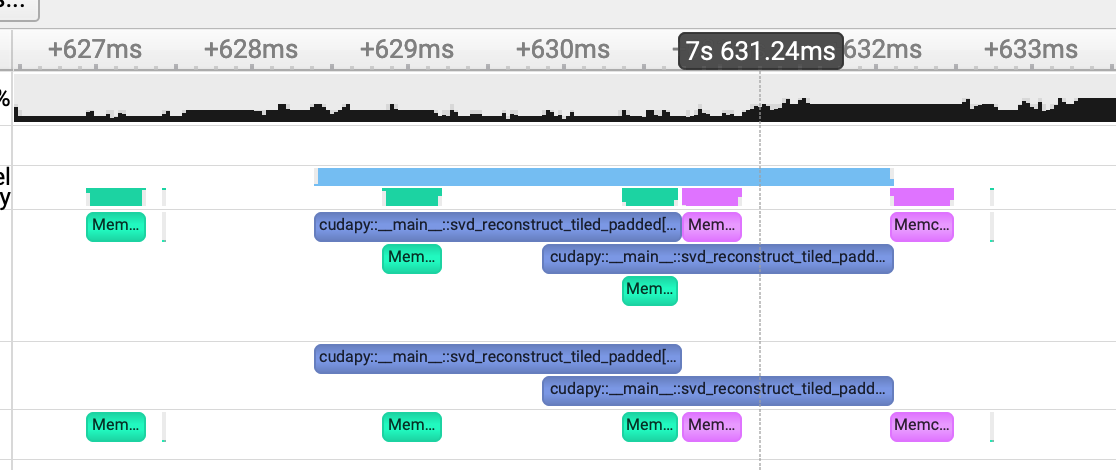

However looking at the profile I noticed that most work happens within 2 kernels and the other ones idle. I am not sure if this is a profiling issue and I did  something wrong, because the performance does vary depending on worker and streams.
</font>

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson.

<font color='blue'>
The impact of streams in concurrent execution is clearly visible.

I played around with setups but noticed that a synced setups of 4 workers with 4 streams and 2 workers with 2 streams was the best setup with roughly 350 images/s.

The sequential mode has the same setup just no concurrency or streams, resulting in roughly 180 images/s. So around a 50% speed loss in comparison to the concurrent mode.

#### Amdahl’s Law
Amdahl’s Law focuses on the fraction of an algorithm that is impossible to parallelize (the “serial fraction”). If a proportion \( p \) of the process is perfectly parallelizable and the remainder \( 1 - p \) is serial, Amdahl’s Law states that:

$$
  \text{Speedup}(n) = \frac{1}{(1 - p) + \frac{p}{n}}
$$

where \( n \) is the number of parallel units (e.g., number of streams, workers, or GPUs). Even if you make \( n \) very large, the speedup is limited by the fraction \( 1 - p \) that must run sequentially. In our pipeline, overheads like pinned memory allocation or CPU thread coordination become part of that non-parallelizable portion, capping total speedup.

---

#### Gustafson’s Law
Gustafson’s Law recognizes that, in many real-world problems, as we add more parallel resources, we can also **increase the total workload** to keep all resources busy. In this case, the law is expressed as:

$$
  \text{Speedup}(n) = n - \alpha(n - 1)
$$

where $\alpha$ is the fraction of the runtime spent on serial operations. Under Gustafson’s model, if the problem size is allowed to grow (for instance, more images or larger images), the overhead of the serial portion becomes relatively smaller compared to the total parallelizable workload—allowing speedups to approach near-linear scaling for large tasks.

Overall, these results confirm that concurrency and CUDA streams **substantially** boost throughput from ~180 images/s to ~350 images/s. Yet, HPC fundamentals like Amdahl’s and Gustafson’s laws remind us that further improvements demand reducing or masking the remaining serial tasks and possibly scaling the workload. Which was partially achieved

</font>

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


<font color='blue'>

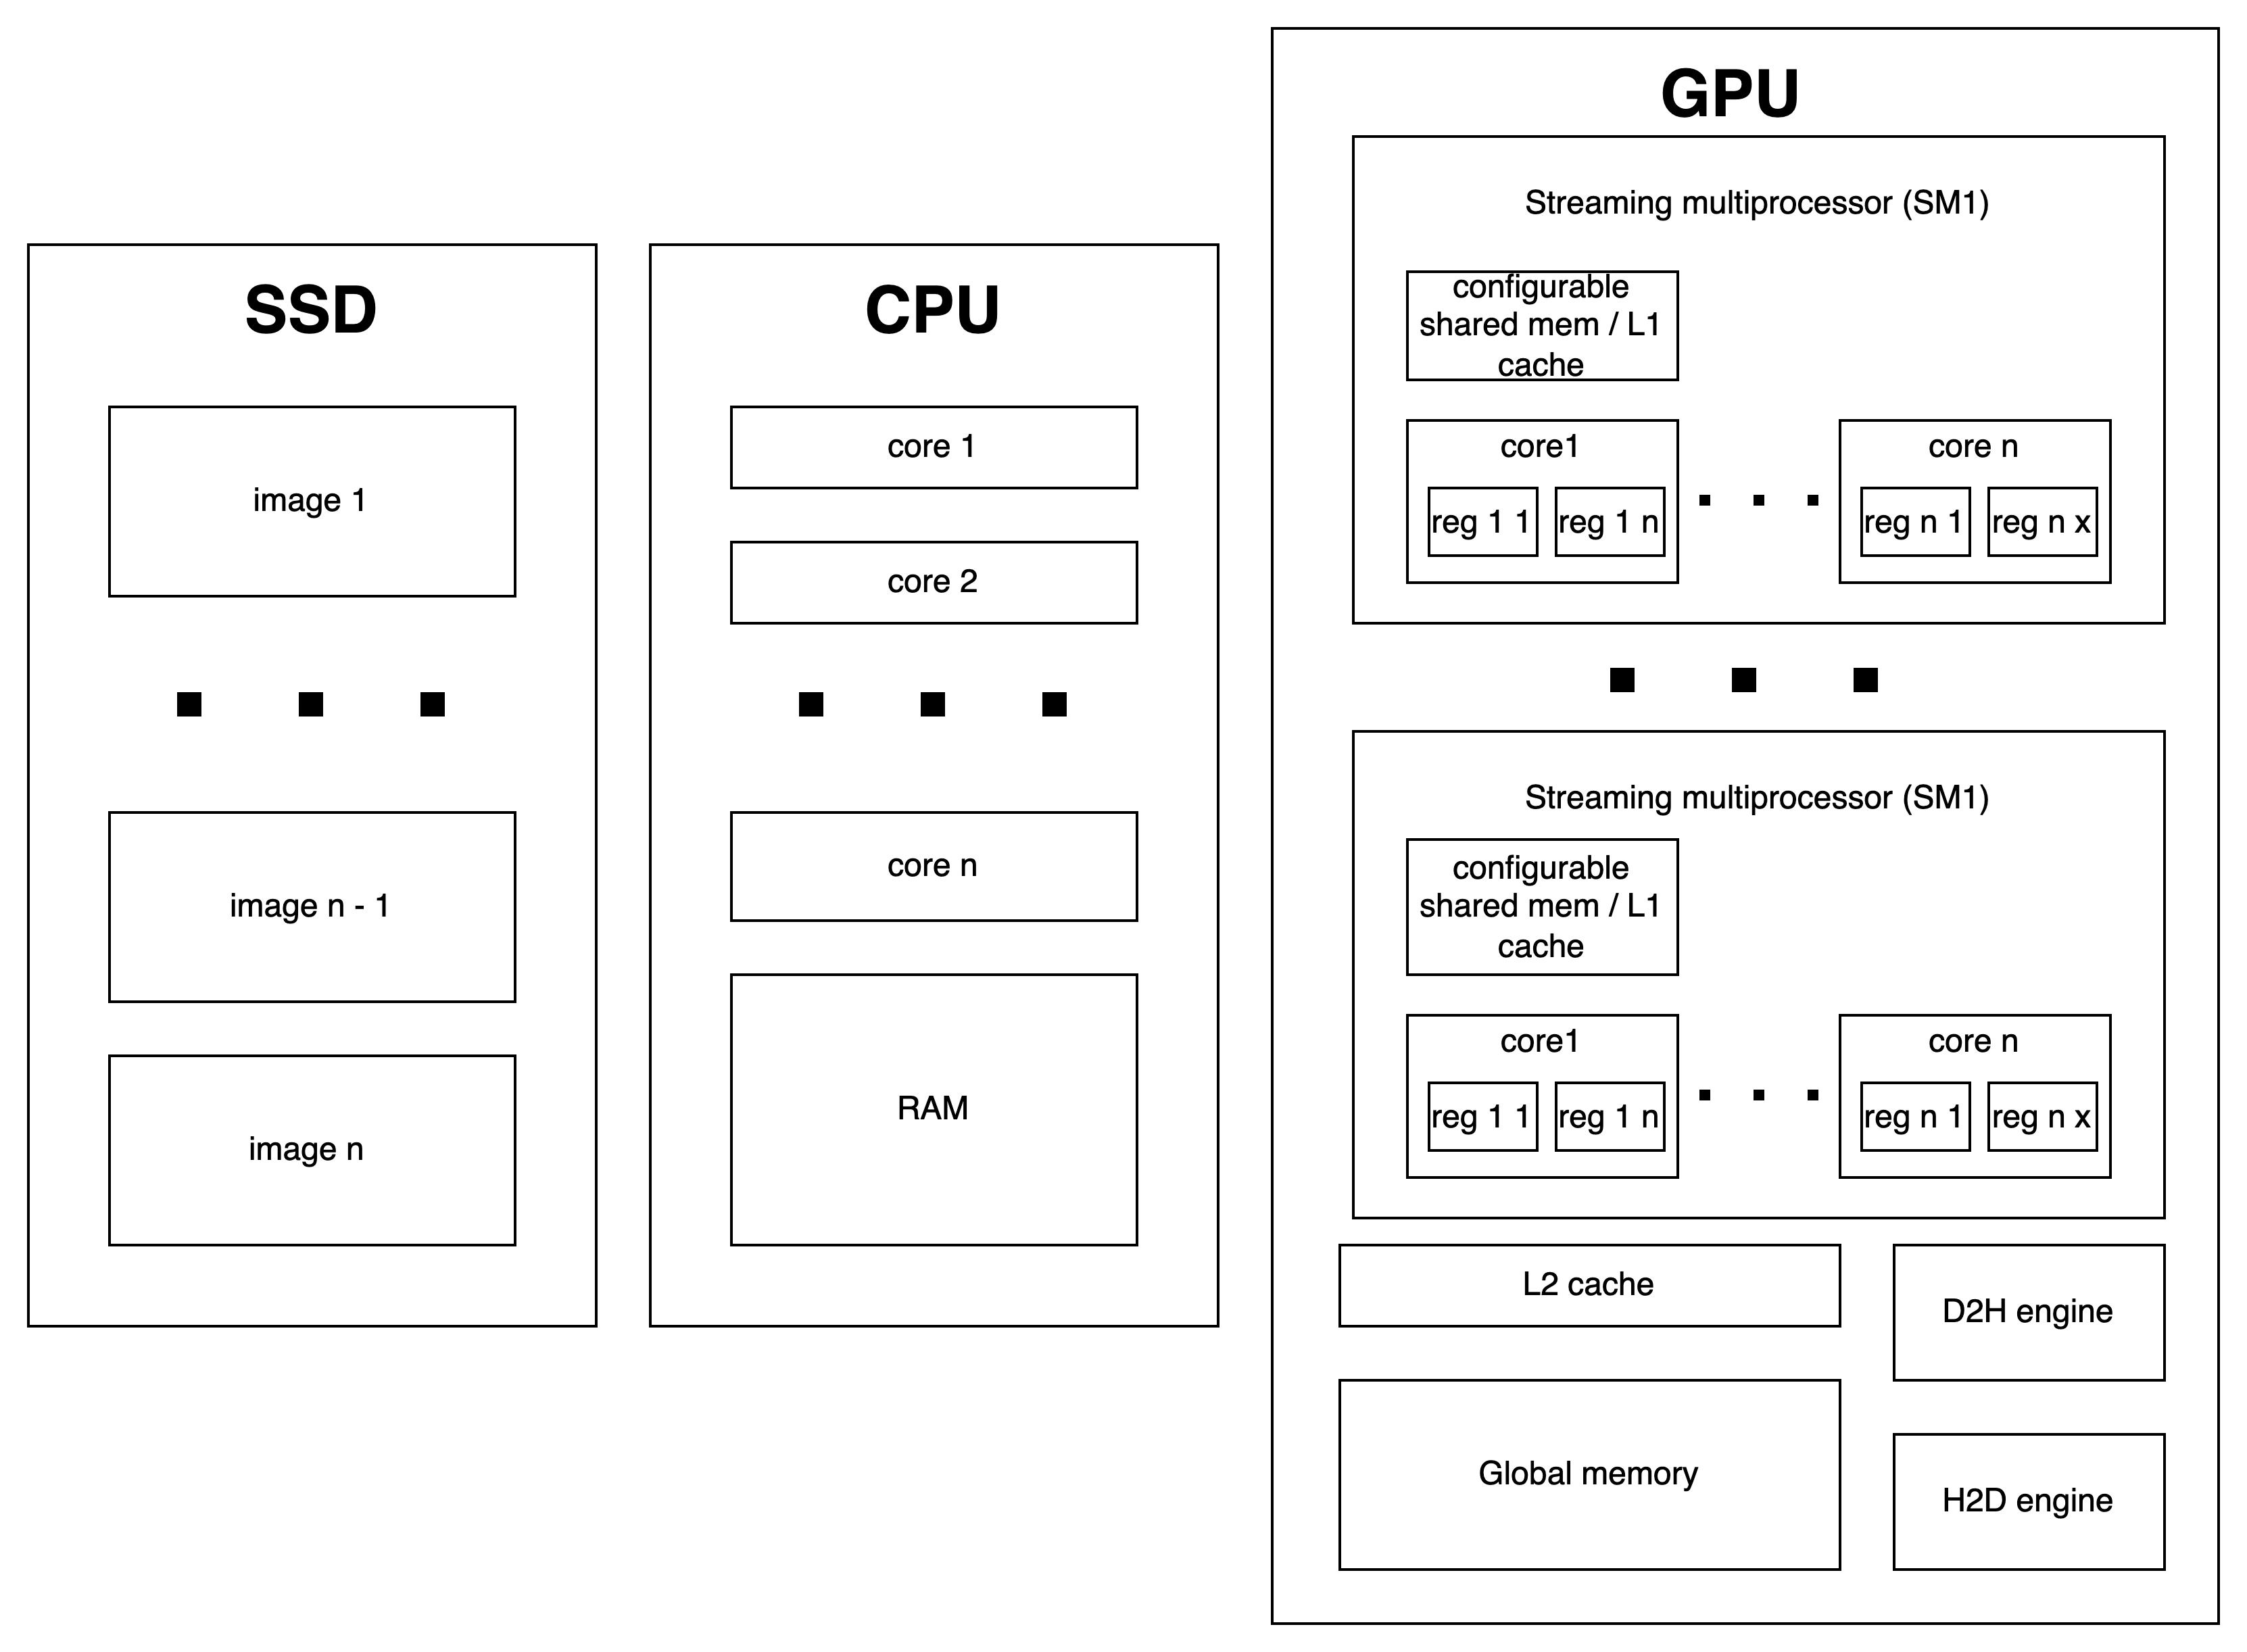

The diagram is a high-level component layout showing three main containers: an SSD, a CPU, and a GPU. In the SSD, we see various images held as stored files. The CPU contains multiple cores along with main system memory (RAM). The GPU is subdivided into several streaming multiprocessors (SMs), each housing cores, that have registers, and configurable shared memory/L1 cache per SM, along with an overarching L2 cache and global memory.

[![](https://mermaid.ink/img/pako:eNqNU02PmzAQ_SsjH1apRKME8rFwWKkK2-yhrapNs4eKi4snxFpsUxvSpVH-ewdIStJN1SKEjWfmvTcznj1LjUAWMYffK9QpxpJnlqtEAz0Ft6VMZcF1CatVDNw1y2vb4vO6sdHy2rbsbMuTrfsSzNu7OwqI4IPhAjg4qbMcwXItjAKpeIadKzmdXFdPMQhMjSqMk6U0GgZrD1YyU9yDpzedvzYlgtmhhTYmNpp-KTMPXGksMaCr8tKB1KBQGVsnugvMjSngvbGgyC6LRgxxaVfaKm3IHAwKQv1h7DPaI1kvcNmQfSH5bkNOF7pgQ6CXWH30hVyvRVk3tYAHPwbUmST5AwpNK2uR6kkQyJU741_2_I89SVdC2EkOi3X8Dkizxvwab6dc5ijghlonBG06b8AXTKtLvcu-HQtT1Od5UVxH-o2nz_-RYew_HDO8WswmGSsAd03aN5DyPP8n8D1Pt8cOgTJaUscdNBcmx7-m8cmUclMfeYQ5V_PHXXpELuq2mxpfyqstRS0SzTym0CouBU3WvjEkrNyiwoRFtBW44XTFEpboA7nyqjSrWqcsIij0WFUIXp4GkUUbnjs6pWH6akz_j6JJ7mM3ve0Qtz4s2rMXFvnheDid-UEwnQeTaej7HqvpdDKc34bh6HYajMI5vbODx362qOPhOJiE43A2CSYjfxSGM49ZU2Xb34SdrPuW9nh4-AXYdFei?type=png)](https://mermaid.live/edit#pako:eNqNU02PmzAQ_SsjH1apRKME8rFwWKkK2-yhrapNs4eKi4snxFpsUxvSpVH-ewdIStJN1SKEjWfmvTcznj1LjUAWMYffK9QpxpJnlqtEAz0Ft6VMZcF1CatVDNw1y2vb4vO6sdHy2rbsbMuTrfsSzNu7OwqI4IPhAjg4qbMcwXItjAKpeIadKzmdXFdPMQhMjSqMk6U0GgZrD1YyU9yDpzedvzYlgtmhhTYmNpp-KTMPXGksMaCr8tKB1KBQGVsnugvMjSngvbGgyC6LRgxxaVfaKm3IHAwKQv1h7DPaI1kvcNmQfSH5bkNOF7pgQ6CXWH30hVyvRVk3tYAHPwbUmST5AwpNK2uR6kkQyJU741_2_I89SVdC2EkOi3X8Dkizxvwab6dc5ijghlonBG06b8AXTKtLvcu-HQtT1Od5UVxH-o2nz_-RYew_HDO8WswmGSsAd03aN5DyPP8n8D1Pt8cOgTJaUscdNBcmx7-m8cmUclMfeYQ5V_PHXXpELuq2mxpfyqstRS0SzTym0CouBU3WvjEkrNyiwoRFtBW44XTFEpboA7nyqjSrWqcsIij0WFUIXp4GkUUbnjs6pWH6akz_j6JJ7mM3ve0Qtz4s2rMXFvnheDid-UEwnQeTaej7HqvpdDKc34bh6HYajMI5vbODx362qOPhOJiE43A2CSYjfxSGM49ZU2Xb34SdrPuW9nh4-AXYdFei)

The diagram above shows the sequence of the concurrent GPU implementation, from the perspective of the CPU.

It shows how a single image is read from the SSD, then decomposed via SVD on the CPU exactly once. Afterwards, multiple GPU reconstructions are performed using the already decomposed data (U, Sigma, V), with each reconstruction performed by GPU kernels via separate streams and callbacks. This setup leverages concurrency and pinned memory transfers to efficiently handle repeated image reconstruction on the GPU.

 
</font>

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

<font color='blue'>

One crucial principle is algorithmic efficiency: ensure you have an optimal algorithm before parallelizing. It is crazy how shifting the way for loops go has a 10x speed improvement (naive vs final tile based padded kernel).

A second is utilizing hardware capabilities, for instance by leveraging shared memory, coalesced accesses, and concurrency on the GPU.

Thirdly, profile and iterate: use profiling tools (e.g., Nsight, nvprof) to find bottlenecks and keep refining. These steps avoid wasted effort on code that is theoretically suboptimal from the start, or memory-bound, and guide the process of continuous improvement.  I made huge progress just looking at the ncu profile and identifying how to improve it. 

</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

<font color='blue'>

In the first part SISD: Reconstructions happen on the CPU sequentially.

We employed SIMD (Single Instruction Multiple Data) concepts on the GPU, where many threads execute the same instruction but on different data elements. Within each GPU kernel, there’s also a flavor of MIMD at a higher level, since multiple thread blocks can run concurrently with distinct instruction streams. Meanwhile, on the CPU side, tasks are processed in a typical SISD style if not multi-threaded, but we introduced concurrency, effectively bridging SISD on the CPU with SIMD on the GPU for the reconstructions. Therefore, we see a combination of Flynn’s taxonomy categories depending on which level (threads, blocks, CPU processes) we examine.
</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

<font color='blue'>
Overall, we’re mostly CPU-bound (or better said, compute-bound) when focusing on the actual SVD reconstruction and GPU kernel calculations: the GPU is doing heavy parallel math, and the CPU side can become a bottleneck if it cannot feed the GPU fast enough. That said, IO overhead also arises when loading MRI images from disk, but in the mini-challenge context, the main constraint is typically the GPU/CPU compute synergy. Once data is loaded, most performance effort revolves around accelerating matrix math, so we treat it mostly as a compute-bound problem. This specially because I mainly worked with my own matrices and not the adni data provided to better test out the scaling of the algorithms, which the adni images are just too small.
</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

<font color='blue'>
In a producer-consumer design, one part of the code (the producer) would fetch, preprocess, and enqueue batches of images (or SVD decompositions) into a shared queue. Another part (the consumer) would pull these tasks from the queue and perform GPU-based reconstructions, possibly returning the results to a further queue or data sink. Multiple producers and consumers could run in parallel, allowing concurrency for both the data loading (producer) and kernel execution (consumer). This approach helps keep the pipeline continuously fed and ensures minimal idle GPU time.
</font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

<font color='blue'>
The most important aspects are data movement minimization and memory optimizations like using pinned (page-locked) memory transfers, ensuring coalesced global memory access, employing shared memory effectively, and maximizing occupancy (e.g., enough threads per block). Tiling and thread-block strategies help hide latency and reuse data. Also, overlapping computation with communication via streams boosts utilization. Finally, frequent profiling is essential to uncover inefficiencies and refine the GPU’s performance.

Generally on a kernel level we want to ensure to access data in an efficient way to optimize the overall load and not underutilize threads.
</font>

6: Reflektiere die Mini-Challenge. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

<font color='blue'>

Many things worked well, particularly incrementally transitioning from naive CPU code to progressively optimized GPU kernels, which revealed each successive bottleneck. One challenge was ensuring correctness at each step with numerical checks, especially for large matrices. 

I almost broke apart doing the subtile kernel, even if in theory it is just 2 for loops, but making it dynamic and work across multiple block shapes took a lot of time and energy. 

I learned a lot, even if it is a bit heartbreaking to see all this work being for nothing since CuPy optimized function are just better at scaling.

</font>